In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 1. Reading dataset
print("Reading dataset...")
train_data_original = pd.read_csv("UNSW_NB15_training-set.csv")
test_data = pd.read_csv("UNSW_NB15_testing-set.csv")

print(f"Training set shape (original): {train_data_original.shape}")
print(f"Testing set shape: {test_data.shape}")

# 1b. APPROACH #2: Removing Fuzzers and Reconnaissance attacks from training data only
print("\nRemoving zero-day categories (Fuzzers and Reconnaissance) from training data...")
print("Attack category distribution before removal:")
print(train_data_original['attack_cat'].value_counts())

# Remove zero-day attack categories from training data
train_data = train_data_original[~train_data_original['attack_cat'].isin(['Fuzzers', 'Reconnaissance'])]
print(f"\nNumber of training data after removal: {len(train_data)}")
print(f"Number of zero-day data removed: {len(train_data_original) - len(train_data)}")

# Distribution after removal
print("\nAttack category distribution after removal:")
print(train_data['attack_cat'].value_counts())

Reading dataset...
Training set shape (original): (175341, 45)
Testing set shape: (82332, 45)

Removing zero-day categories (Fuzzers and Reconnaissance) from training data...
Attack category distribution before removal:
attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64

Number of training data after removal: 146666
Number of zero-day data removed: 28675

Attack category distribution after removal:
attack_cat
Normal       56000
Generic      40000
Exploits     33393
DoS          12264
Analysis      2000
Backdoor      1746
Shellcode     1133
Worms          130
Name: count, dtype: int64


# Pre Processing

In [3]:
# 2. Checking dataset information
print("\nTraining dataset information after zero-day removal:")
print(train_data.info())
print("\nDescriptive statistics of training dataset:")
print(train_data.describe())


Training dataset information after zero-day removal:
<class 'pandas.core.frame.DataFrame'>
Index: 146666 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 146666 non-null  int64  
 1   dur                146666 non-null  float64
 2   proto              146666 non-null  object 
 3   service            146666 non-null  object 
 4   state              146666 non-null  object 
 5   spkts              146666 non-null  int64  
 6   dpkts              146666 non-null  int64  
 7   sbytes             146666 non-null  int64  
 8   dbytes             146666 non-null  int64  
 9   rate               146666 non-null  float64
 10  sttl               146666 non-null  int64  
 11  dttl               146666 non-null  int64  
 12  sload              146666 non-null  float64
 13  dload              146666 non-null  float64
 14  sloss              146666 non-null  int64  
 15  dl

In [4]:
# 3. Handling missing values
print("\nChecking missing values...")
print(f"Missing values in training set:\n{train_data.isnull().sum()}")
print(f"Missing values in testing set:\n{test_data.isnull().sum()}")

# Fill missing values with mean
numeric_columns = train_data.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='mean')
train_data[numeric_columns] = imputer.fit_transform(train_data[numeric_columns])
test_data[numeric_columns] = imputer.transform(test_data[numeric_columns])


Checking missing values...
Missing values in training set:
id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm          

In [5]:
# 4. Handling duplicate data
print("\nChecking duplicate data...")
print(f"Number of duplicate data in training set: {train_data.duplicated().sum()}")
print(f"Number of duplicate data in testing set: {test_data.duplicated().sum()}")

# Remove duplicates if any
train_data = train_data.drop_duplicates()
test_data = test_data.drop_duplicates()


Checking duplicate data...
Number of duplicate data in training set: 0
Number of duplicate data in testing set: 0


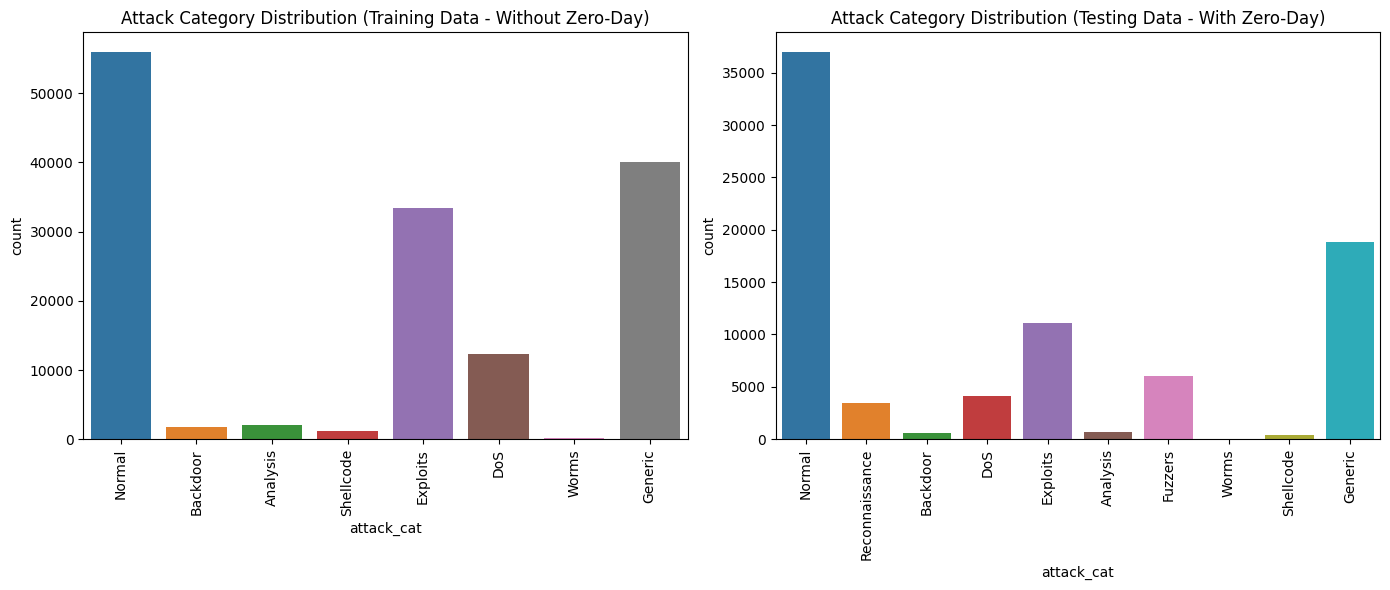

In [6]:
# 5. Class distribution visualization
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='attack_cat', data=train_data)
plt.title('Attack Category Distribution (Training Data - Without Zero-Day)')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.countplot(x='attack_cat', data=test_data)
plt.title('Attack Category Distribution (Testing Data - With Zero-Day)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [7]:
# 6. APPROACH #2: Create specific dataset for zero-day evaluation
print("\nPreparing subset data for zero-day evaluation...")

# Create a subset of test data containing only zero-day attacks and normal traffic
zero_day_attacks = test_data[test_data['attack_cat'].isin(['Fuzzers', 'Reconnaissance'])]
zero_day_attacks_count = len(zero_day_attacks)
print(f"Number of zero-day attacks (Fuzzers & Reconnaissance) in test set: {zero_day_attacks_count}")

# Add normal traffic for more realistic evaluation
normal_traffic = test_data[test_data['label'] == 0]
normal_traffic_count = len(normal_traffic)
print(f"Number of normal traffic in test set: {normal_traffic_count}")

# Combine to create a specific zero-day evaluation dataset
zero_day_test_data = pd.concat([zero_day_attacks, normal_traffic])
zero_day_test_data = zero_day_test_data.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

print(f"Zero-day evaluation dataset created with {len(zero_day_test_data)} total samples")
print(f"Proportions in zero-day evaluation dataset - Normal: {sum(zero_day_test_data['label'] == 0)/len(zero_day_test_data):.2%}, "
      f"Attack: {sum(zero_day_test_data['label'] == 1)/len(zero_day_test_data):.2%}")

# Save zero-day evaluation dataset
zero_day_test_data.to_csv('zero_day_test_data.csv', index=False)

# Add distribution information in zero-day evaluation dataset
print("\nAttack distribution in zero-day evaluation dataset:")
zero_day_attack_dist = zero_day_test_data[zero_day_test_data['label'] == 1]['attack_cat'].value_counts()
for attack_type, count in zero_day_attack_dist.items():
    print(f"- {attack_type}: {count} samples ({count/sum(zero_day_test_data['label'] == 1):.2%})")


Preparing subset data for zero-day evaluation...
Number of zero-day attacks (Fuzzers & Reconnaissance) in test set: 9558
Number of normal traffic in test set: 37000
Zero-day evaluation dataset created with 46558 total samples
Proportions in zero-day evaluation dataset - Normal: 79.47%, Attack: 20.53%

Attack distribution in zero-day evaluation dataset:
- Fuzzers: 6062 samples (63.42%)
- Reconnaissance: 3496 samples (36.58%)


In [8]:
# 7. Separating features and targets
X_train = train_data.drop(['id', 'label', 'attack_cat'], axis=1)
y_train_binary = train_data['label']
y_train_multi = train_data['attack_cat']

X_test = test_data.drop(['id', 'label', 'attack_cat'], axis=1)
y_test_binary = test_data['label']
y_test_multi = test_data['attack_cat']

X_zero_day = zero_day_test_data.drop(['id', 'label', 'attack_cat'], axis=1)
y_zero_day_binary = zero_day_test_data['label']
y_zero_day_multi = zero_day_test_data['attack_cat']

In [9]:
# 8. Preprocessing categorical features
print("\nEncoding categorical features...")
categorical_columns = X_train.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_columns:
    # Get all unique values from train, test and zero_day
    all_values = set(X_train[col].astype(str).unique()).union(
                 set(X_test[col].astype(str).unique())).union(
                 set(X_zero_day[col].astype(str).unique()))
    
    # Create mapping dictionary
    value_map = {val: idx for idx, val in enumerate(all_values)}
    
    # Apply mapping to all datasets
    X_train[col] = X_train[col].astype(str).map(value_map)
    X_test[col] = X_test[col].astype(str).map(value_map)
    X_zero_day[col] = X_zero_day[col].astype(str).map(value_map)
    
    # Save mapping for future use
    label_encoders[col] = value_map


Encoding categorical features...


In [10]:
# 9. Encoding multi-class target
print("\nEncoding multi-class target...")
le_attack = LabelEncoder()
# Make sure encoder includes all categories by fitting on combined train and test
all_attack_categories = np.concatenate([y_train_multi.astype(str), y_test_multi.astype(str)])
le_attack.fit(all_attack_categories)

# Transform training and testing data
y_train_multi_encoded = le_attack.transform(y_train_multi.astype(str))
y_test_multi_encoded = le_attack.transform(y_test_multi.astype(str))
y_zero_day_multi_encoded = le_attack.transform(y_zero_day_multi.astype(str))

print(f"Attack category mapping: {dict(zip(le_attack.classes_, range(len(le_attack.classes_))))}")


Encoding multi-class target...
Attack category mapping: {'Analysis': 0, 'Backdoor': 1, 'DoS': 2, 'Exploits': 3, 'Fuzzers': 4, 'Generic': 5, 'Normal': 6, 'Reconnaissance': 7, 'Shellcode': 8, 'Worms': 9}


In [11]:
# 10. Handling Class Imbalance - New correct method
print("\n*** Handling Class Imbalance ***")
print("Class distribution before resampling:")
print(f"  - Normal (0): {sum(y_train_binary == 0)}")
print(f"  - Attack (1): {sum(y_train_binary == 1)}")
print(f"  - Attack/normal ratio: {sum(y_train_binary == 1) / sum(y_train_binary == 0):.4f}")

# BETTER APPROACH: Add attack_cat as additional column to be resampled together
# 10.1 SMOTE
print("\nPerforming SMOTE resampling...")
# Create DataFrame with features and labels
X_train_with_cat = X_train.copy()
X_train_with_cat['attack_cat'] = y_train_multi_encoded  # Add attack_cat as additional feature

# Perform SMOTE
smote = SMOTE(random_state=42)
X_smote_resampled, y_smote_resampled = smote.fit_resample(X_train_with_cat, y_train_binary)

# Extract attack_cat back from resampling results
y_multi_smote_resampled = X_smote_resampled['attack_cat'].values
X_smote_resampled = X_smote_resampled.drop('attack_cat', axis=1)

print("\nClass distribution after SMOTE:")
print(f"  - Normal (0): {sum(y_smote_resampled == 0)}")
print(f"  - Attack (1): {sum(y_smote_resampled == 1)}")
print(f"  - Attack/normal ratio: {sum(y_smote_resampled == 1) / sum(y_smote_resampled == 0):.4f}")

# 10.2 Random Undersampling
print("\nPerforming Random Under-sampling...")
# Create DataFrame with features and multi-class labels
X_train_with_cat = X_train.copy()
X_train_with_cat['attack_cat'] = y_train_multi_encoded

# Perform undersampling
rus = RandomUnderSampler(random_state=42)
X_rus_resampled, y_rus_resampled = rus.fit_resample(X_train_with_cat, y_train_binary)

# Extract attack_cat back from resampling results
y_multi_rus_resampled = X_rus_resampled['attack_cat'].values
X_rus_resampled = X_rus_resampled.drop('attack_cat', axis=1)

print("\nClass distribution after Random Under-sampling:")
print(f"  - Normal (0): {sum(y_rus_resampled == 0)}")
print(f"  - Attack (1): {sum(y_rus_resampled == 1)}")
print(f"  - Attack/normal ratio: {sum(y_rus_resampled == 1) / sum(y_rus_resampled == 0):.4f}")

# 10.3 SMOTETomek (combination)
print("\nPerforming SMOTE+Tomek resampling...")
# Create DataFrame with features and multi-class labels
X_train_with_cat = X_train.copy()
X_train_with_cat['attack_cat'] = y_train_multi_encoded

# Perform SMOTE+Tomek
smt = SMOTETomek(random_state=42)
X_smt_resampled, y_smt_resampled = smt.fit_resample(X_train_with_cat, y_train_binary)

# Extract attack_cat back from resampling results
y_multi_smt_resampled = X_smt_resampled['attack_cat'].values
X_smt_resampled = X_smt_resampled.drop('attack_cat', axis=1)

print("\nClass distribution after SMOTE+Tomek:")
print(f"  - Normal (0): {sum(y_smt_resampled == 0)}")
print(f"  - Attack (1): {sum(y_smt_resampled == 1)}")
print(f"  - Attack/normal ratio: {sum(y_smt_resampled == 1) / sum(y_smt_resampled == 0):.4f}")

# Default: use SMOTE+Tomek as the main resampling method
X_train_resampled = X_smt_resampled
y_train_binary_resampled = y_smt_resampled
y_train_multi_resampled = y_multi_smt_resampled


*** Handling Class Imbalance ***
Class distribution before resampling:
  - Normal (0): 56000
  - Attack (1): 90666
  - Attack/normal ratio: 1.6190

Performing SMOTE resampling...

Class distribution after SMOTE:
  - Normal (0): 90666
  - Attack (1): 90666
  - Attack/normal ratio: 1.0000

Performing Random Under-sampling...

Class distribution after Random Under-sampling:
  - Normal (0): 56000
  - Attack (1): 56000
  - Attack/normal ratio: 1.0000

Performing SMOTE+Tomek resampling...

Class distribution after SMOTE+Tomek:
  - Normal (0): 86708
  - Attack (1): 86708
  - Attack/normal ratio: 1.0000


In [12]:
# 11. Normalizing numerical features
print("\nNormalizing numerical features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
X_zero_day_scaled = scaler.transform(X_zero_day)


Normalizing numerical features...



Analyzing correlation between features...


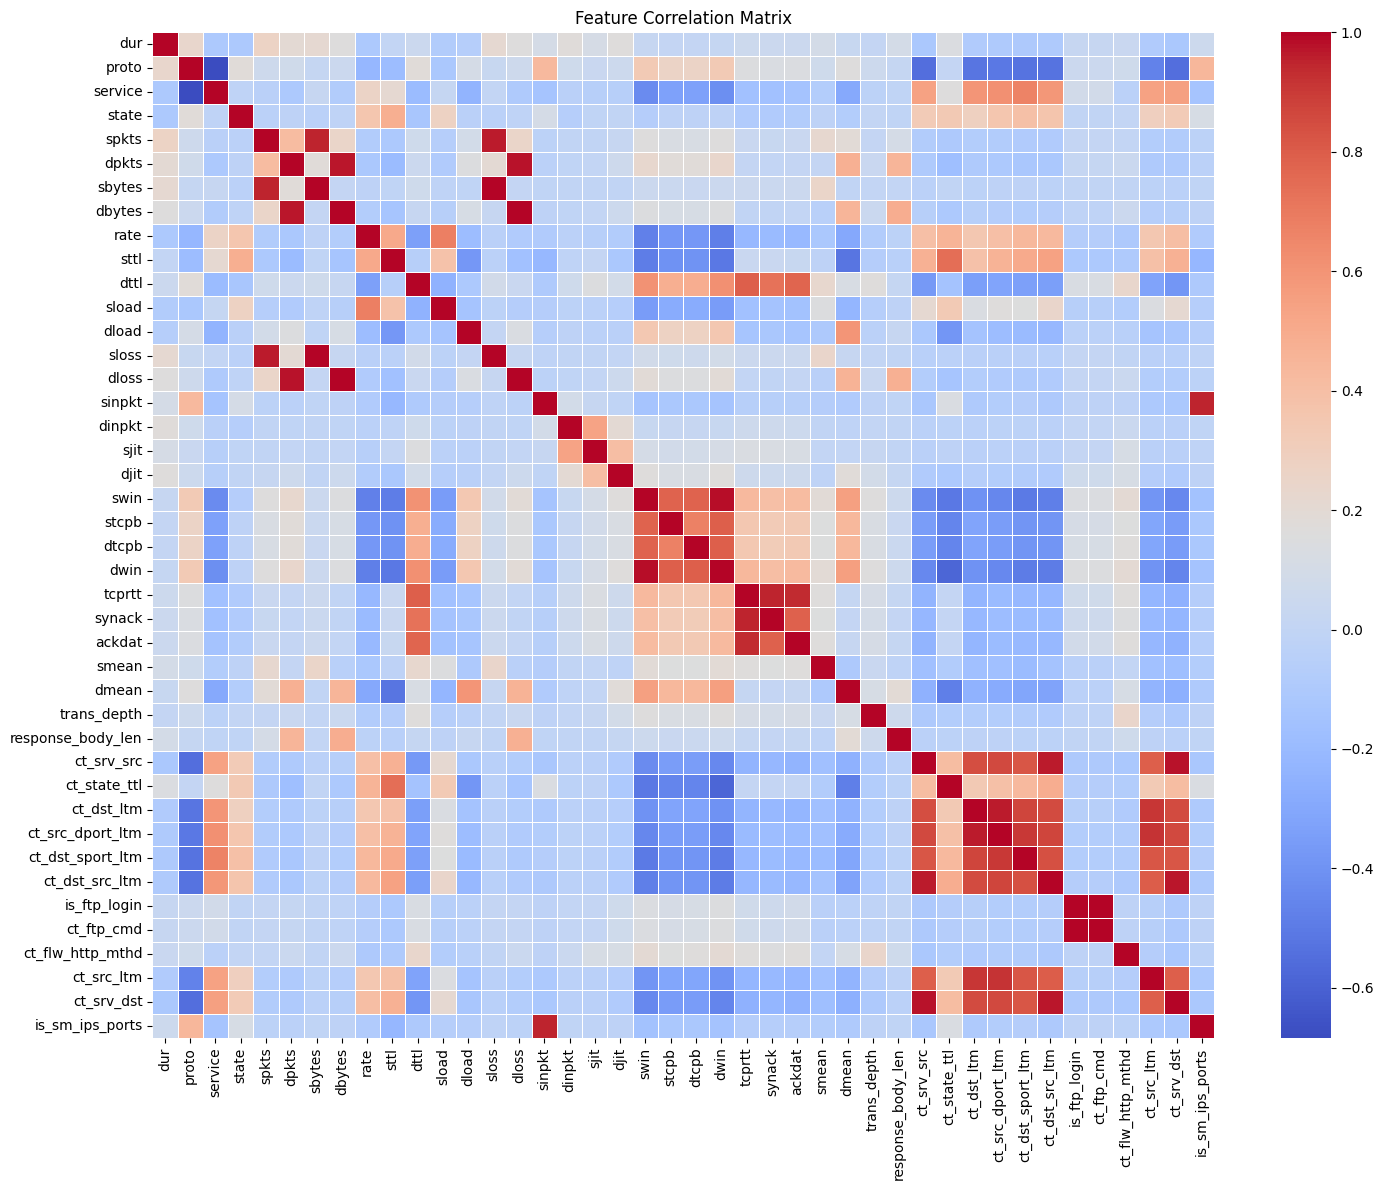


Features with high correlation (>0.9):
spkts - sbytes: 0.951138551504455
spkts - sloss: 0.9624408582623044
dpkts - dbytes: 0.970469038886989
dpkts - dloss: 0.9796464752389936
sbytes - sloss: 0.9954691406192572
dbytes - dloss: 0.9955652308070001
sinpkt - is_sm_ips_ports: 0.9479944410147124
swin - dwin: 0.9837555366556793
tcprtt - synack: 0.9502199467134054
tcprtt - ackdat: 0.9392235782039967
ct_srv_src - ct_dst_src_ltm: 0.9668503234808163
ct_srv_src - ct_srv_dst: 0.9794944652329836
ct_dst_ltm - ct_src_dport_ltm: 0.9647430065526864
ct_dst_ltm - ct_src_ltm: 0.9104055426611133
ct_src_dport_ltm - ct_dst_sport_ltm: 0.9065207734144178
ct_src_dport_ltm - ct_src_ltm: 0.9151958778824623
ct_dst_src_ltm - ct_srv_dst: 0.9702386640113376
is_ftp_login - ct_ftp_cmd: 1.0

Removing 13 highly correlated features:
- ct_src_dport_ltm
- is_sm_ips_ports
- sloss
- spkts
- dloss
- dpkts
- dwin
- ct_dst_sport_ltm
- ct_dst_ltm
- ct_dst_src_ltm
- ct_srv_dst
- tcprtt
- ct_ftp_cmd
Number of features after high cor

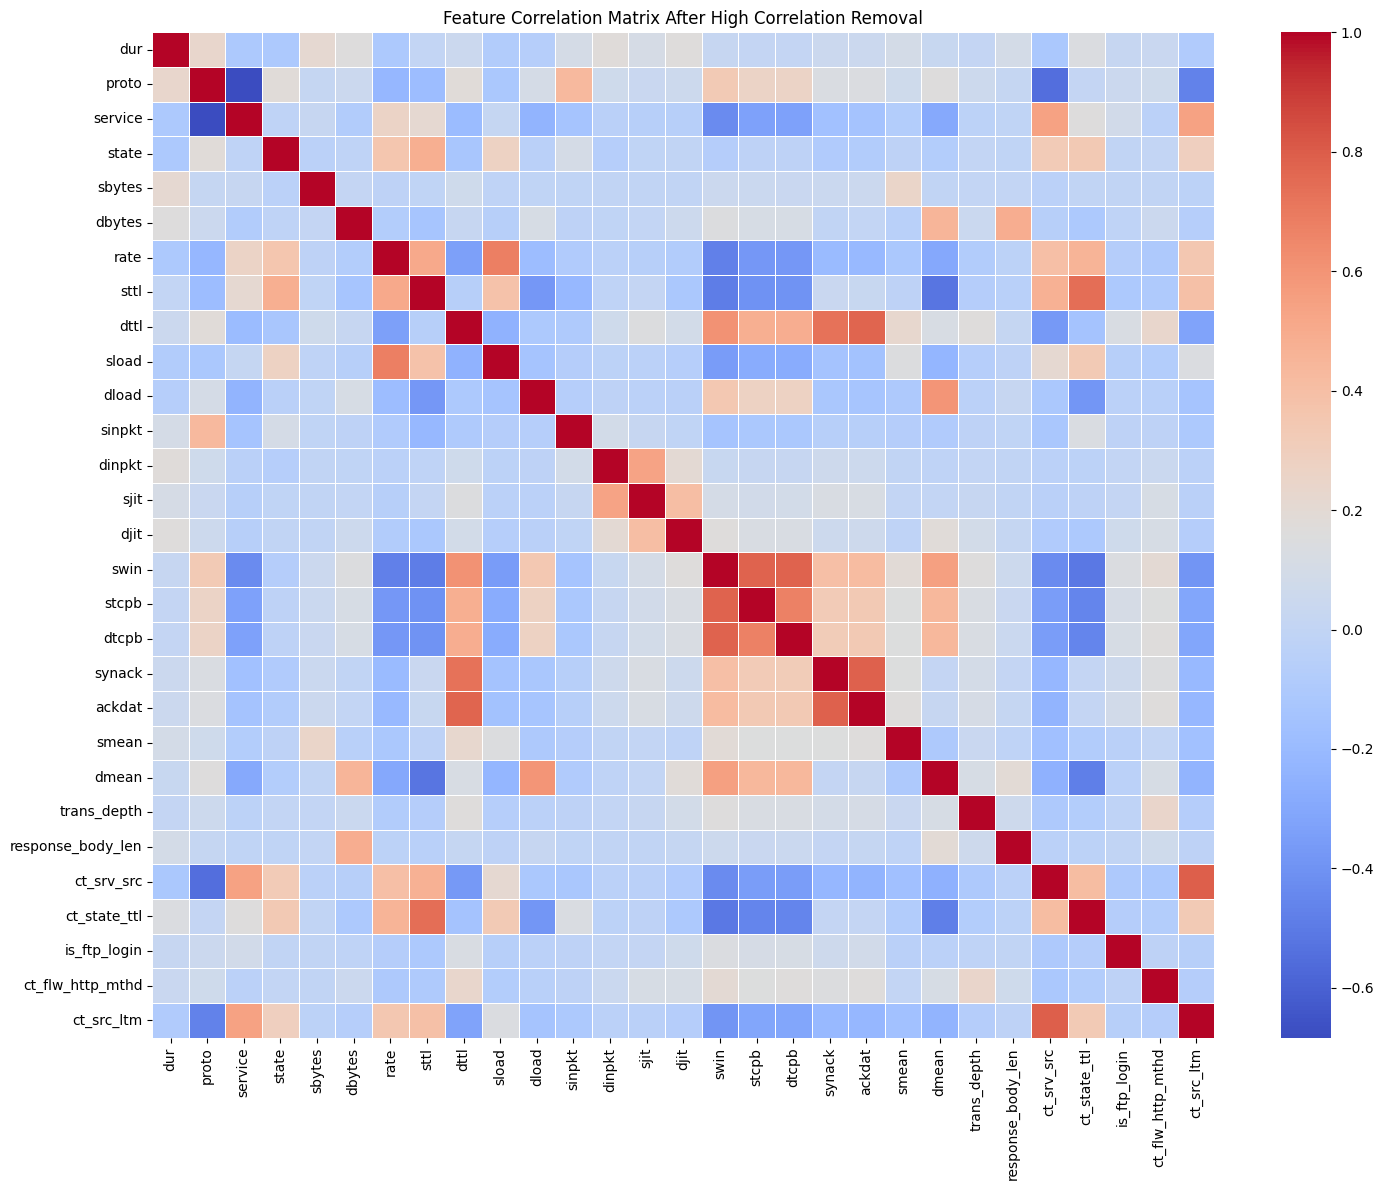

In [13]:
# 12. Correlation analysis and removal of highly correlated features
print("\nAnalyzing correlation between features...")
# Use X_train_resampled, not X_train
correlation_matrix = pd.DataFrame(X_train_resampled).corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Detect and remove features with high correlation (>0.9)
high_corr_features = []
high_corr_values = []
features_to_drop = set()

print("\nFeatures with high correlation (>0.9):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            feat1 = correlation_matrix.columns[i]
            feat2 = correlation_matrix.columns[j]
            high_corr_features.append((feat1, feat2))
            corr_value = correlation_matrix.iloc[i, j]
            high_corr_values.append(corr_value)
            print(f"{feat1} - {feat2}: {corr_value}")
            
            # Strategy: Remove feature with higher mean absolute correlation with all other features
            mean_corr1 = correlation_matrix[feat1].abs().mean()
            mean_corr2 = correlation_matrix[feat2].abs().mean()
            
            if mean_corr1 > mean_corr2:
                features_to_drop.add(feat1)
            else:
                features_to_drop.add(feat2)

# Remove features from dataset
print(f"\nRemoving {len(features_to_drop)} highly correlated features:")
for feature in features_to_drop:
    print(f"- {feature}")

# Remove features from resampled dataset
X_train_reduced = pd.DataFrame(X_train_resampled).drop(columns=list(features_to_drop))
X_test_reduced = X_test.drop(columns=list(features_to_drop))
X_zero_day_reduced = X_zero_day.drop(columns=list(features_to_drop))
print(f"Number of features after high correlation removal: {X_train_reduced.shape[1]} (from {X_train_resampled.shape[1]} initial features)")

# Normalize remaining features
print("\nNormalizing features after high correlation removal...")
scaler_reduced = StandardScaler()
X_train_reduced_scaled = scaler_reduced.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler_reduced.transform(X_test_reduced)
X_zero_day_reduced_scaled = scaler_reduced.transform(X_zero_day_reduced)

# Visualize correlation matrix after removal
plt.figure(figsize=(15, 12))
correlation_matrix_reduced = X_train_reduced.corr()
sns.heatmap(correlation_matrix_reduced, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix After High Correlation Removal')
plt.tight_layout()
plt.show()

In [14]:
# 13. Feature selection with SelectKBest on already reduced features
print("\nFeature selection using SelectKBest...")
k_best = min(20, X_train_reduced.shape[1])  # Number of features to retain
selector = SelectKBest(score_func=f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train_reduced_scaled, y_train_binary_resampled)
X_test_selected = selector.transform(X_test_reduced_scaled)
X_zero_day_selected = selector.transform(X_zero_day_reduced_scaled)

# Getting selected features
selected_features = X_train_reduced.columns[selector.get_support()]
print(f"Selected features ({k_best}):")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature}")

# Get and display feature scores
feature_scores = pd.DataFrame({
    'Feature': X_train_reduced.columns,
    'Score': selector.scores_,
    'P-value': selector.pvalues_
})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
print("\nTop features based on score:")
print(feature_scores.head(k_best))


Feature selection using SelectKBest...
Selected features (20):
1. proto
2. service
3. state
4. dbytes
5. rate
6. sttl
7. sload
8. dload
9. sinpkt
10. dinpkt
11. sjit
12. djit
13. swin
14. stcpb
15. dtcpb
16. smean
17. dmean
18. ct_srv_src
19. ct_state_ttl
20. ct_src_ltm

Top features based on score:
         Feature          Score        P-value
7           sttl  165879.226984   0.000000e+00
25  ct_state_ttl  107772.692891   0.000000e+00
3          state   57142.032843   0.000000e+00
15          swin   45246.663509   0.000000e+00
6           rate   44183.965742   0.000000e+00
28    ct_src_ltm   29430.334661   0.000000e+00
24    ct_srv_src   27259.783103   0.000000e+00
10         dload   24702.175549   0.000000e+00
2        service   24613.296131   0.000000e+00
16         stcpb   23995.353480   0.000000e+00
17         dtcpb   23542.225165   0.000000e+00
21         dmean   22861.246393   0.000000e+00
9          sload   11083.328040   0.000000e+00
11        sinpkt    4597.027448   0.0000


Visualizing attack category distribution...


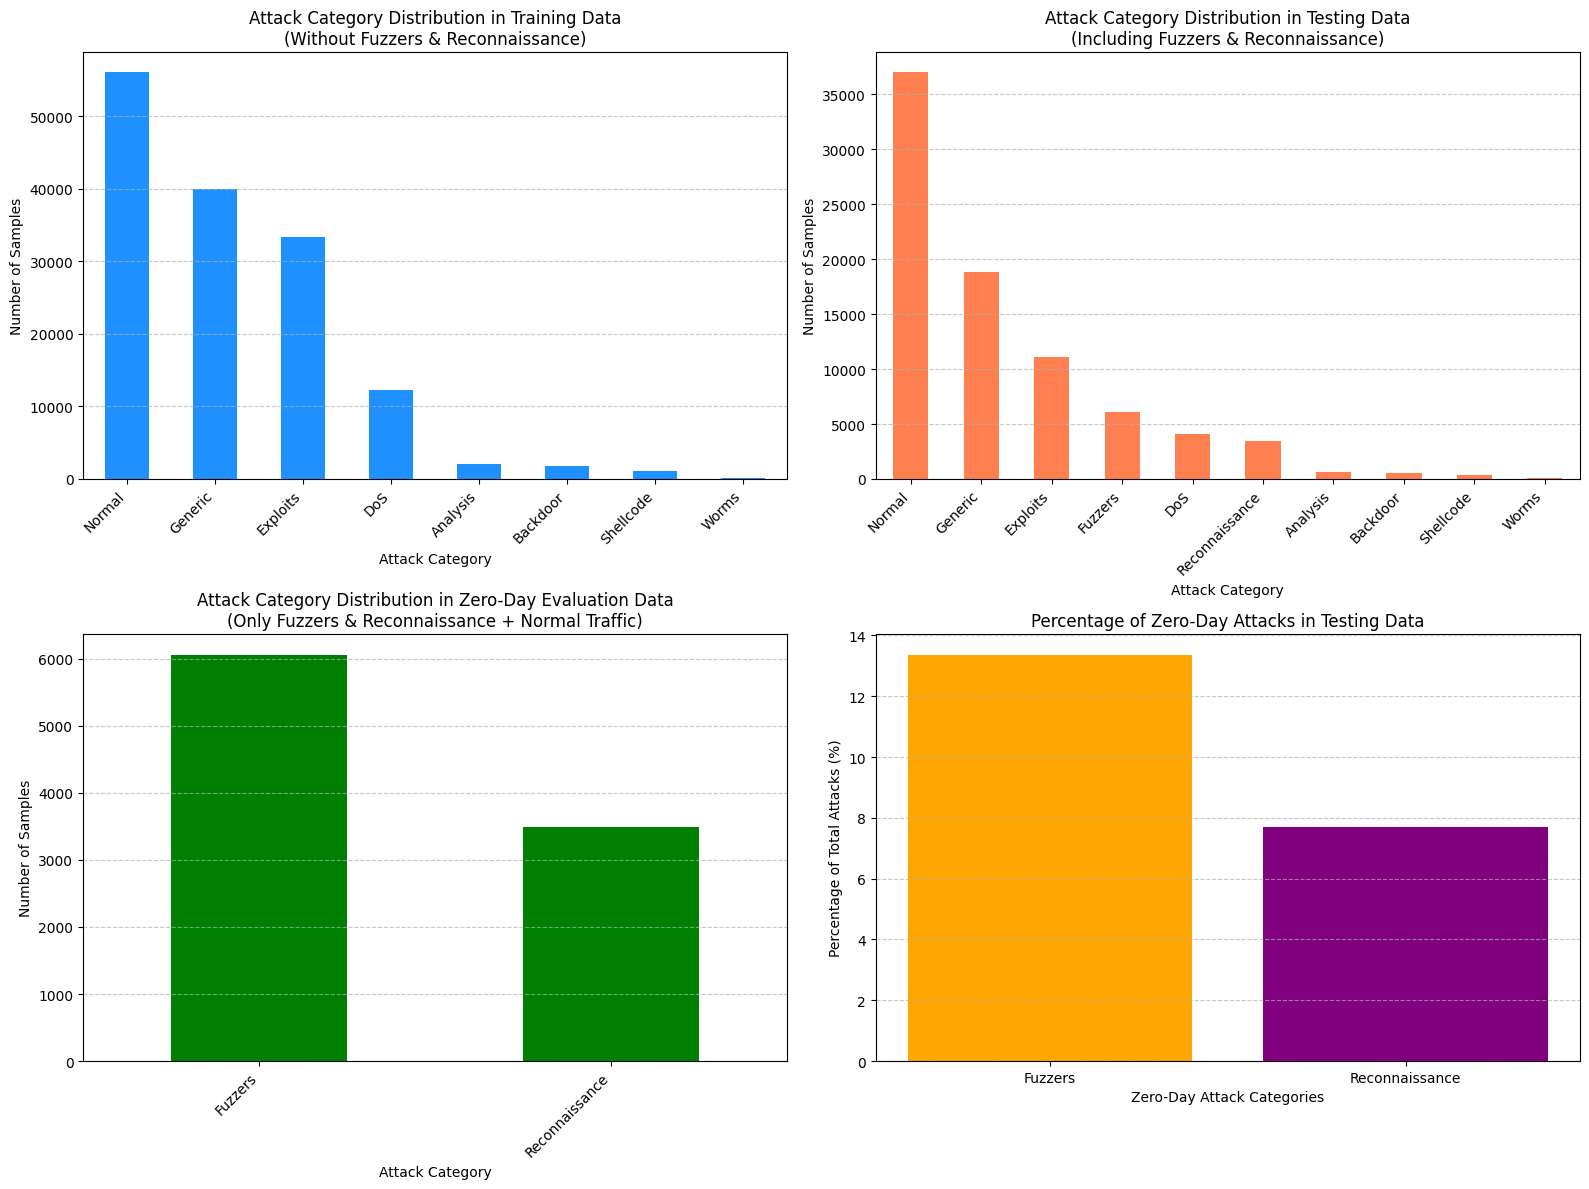

In [15]:
# 14. Visualizing attack category distribution
print("\nVisualizing attack category distribution...")
plt.figure(figsize=(16, 12))

# Plot 1: Attack category distribution in training data (without zero-day)
plt.subplot(2, 2, 1)
train_attack_dist = train_data['attack_cat'].value_counts()
train_attack_dist.plot(kind='bar', color='dodgerblue')
plt.title('Attack Category Distribution in Training Data\n(Without Fuzzers & Reconnaissance)', fontsize=12)
plt.xlabel('Attack Category')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Attack category distribution in testing data (with zero-day)
plt.subplot(2, 2, 2)
test_attack_dist = test_data['attack_cat'].value_counts()
test_attack_dist.plot(kind='bar', color='coral')
plt.title('Attack Category Distribution in Testing Data\n(Including Fuzzers & Reconnaissance)', fontsize=12)
plt.xlabel('Attack Category')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3: Attack category distribution in zero-day evaluation data
plt.subplot(2, 2, 3)
zero_day_attack_dist = zero_day_test_data[zero_day_test_data['label'] == 1]['attack_cat'].value_counts()
zero_day_attack_dist.plot(kind='bar', color='green')
plt.title('Attack Category Distribution in Zero-Day Evaluation Data\n(Only Fuzzers & Reconnaissance + Normal Traffic)', fontsize=12)
plt.xlabel('Attack Category')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 4: Comparison of zero-day attack categories between train (none) and test
plt.subplot(2, 2, 4)

# Calculate percentage of zero-day categories in test
zero_day_categories = ['Fuzzers', 'Reconnaissance']
zero_day_counts = test_data[test_data['attack_cat'].isin(zero_day_categories)]['attack_cat'].value_counts()
total_attacks = sum(test_data['label'] == 1)
zero_day_percentages = (zero_day_counts / total_attacks * 100).reindex(zero_day_categories)

# Plot percentages
plt.bar(zero_day_percentages.index, zero_day_percentages.values, color=['orange', 'purple'])
plt.title('Percentage of Zero-Day Attacks in Testing Data', fontsize=12)
plt.xlabel('Zero-Day Attack Categories')
plt.ylabel('Percentage of Total Attacks (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('attack_category_distribution_approach2.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# 15. Saving preprocessed datasets
print("\nSaving preprocessed datasets...")

# 15.1 Binary classification datasets
binary_train_data = pd.DataFrame(X_train_selected)
binary_train_data['label'] = y_train_binary_resampled
binary_train_data['attack_cat'] = y_train_multi_resampled  # Save attack_cat for analysis
binary_train_data.to_csv('preprocessed_binary_train.csv', index=False)
print("- Saved preprocessed_binary_train.csv")

binary_test_data = pd.DataFrame(X_test_selected)
binary_test_data['label'] = y_test_binary.values
binary_test_data['attack_cat'] = y_test_multi_encoded  # Save attack_cat for analysis
binary_test_data.to_csv('preprocessed_binary_test.csv', index=False)
print("- Saved preprocessed_binary_test.csv")

# 15.2 Zero-day evaluation dataset
zero_day_eval_selected = pd.DataFrame(X_zero_day_selected)
zero_day_eval_selected['label'] = y_zero_day_binary.values
zero_day_eval_selected['attack_cat'] = y_zero_day_multi_encoded  # Save attack_cat for analysis
zero_day_eval_selected.to_csv('preprocessed_zero_day_test.csv', index=False)
print("- Saved preprocessed_zero_day_test.csv")

# 15.3 Multi-class classification datasets
print("\nSaving multi-class classification datasets...")
multi_train_data = pd.DataFrame(X_train_selected)
multi_train_data['attack_cat'] = y_train_multi_resampled
multi_train_data.to_csv('preprocessed_multi_train.csv', index=False)
print("- Saved preprocessed_multi_train.csv")

multi_test_data = pd.DataFrame(X_test_selected)
multi_test_data['attack_cat'] = y_test_multi_encoded
multi_test_data.to_csv('preprocessed_multi_test.csv', index=False)
print("- Saved preprocessed_multi_test.csv")

# 15.4 Saving datasets with various balancing techniques
print("\nSaving datasets with various balancing techniques...")

# SMOTE
X_smote_resampled_reduced = pd.DataFrame(X_smote_resampled).drop(columns=list(features_to_drop))
X_smote_reduced_scaled = scaler_reduced.transform(X_smote_resampled_reduced)
smote_selected = pd.DataFrame(selector.transform(X_smote_reduced_scaled))
smote_selected['label'] = y_smote_resampled
smote_selected['attack_cat'] = y_multi_smote_resampled
smote_selected.to_csv('preprocessed_binary_train_smote.csv', index=False)
print("- Saved preprocessed_binary_train_smote.csv")

# Undersampling
X_rus_resampled_reduced = pd.DataFrame(X_rus_resampled).drop(columns=list(features_to_drop))
X_rus_reduced_scaled = scaler_reduced.transform(X_rus_resampled_reduced)
rus_selected = pd.DataFrame(selector.transform(X_rus_reduced_scaled))
rus_selected['label'] = y_rus_resampled
rus_selected['attack_cat'] = y_multi_rus_resampled
rus_selected.to_csv('preprocessed_binary_train_undersampled.csv', index=False)
print("- Saved preprocessed_binary_train_undersampled.csv")


Saving preprocessed datasets...
- Saved preprocessed_binary_train.csv
- Saved preprocessed_binary_test.csv
- Saved preprocessed_zero_day_test.csv

Saving multi-class classification datasets...
- Saved preprocessed_multi_train.csv
- Saved preprocessed_multi_test.csv

Saving datasets with various balancing techniques...
- Saved preprocessed_binary_train_smote.csv
- Saved preprocessed_binary_train_undersampled.csv


In [17]:
# 16. Saving preprocessing models for future use
print("\nSaving preprocessing models...")
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(scaler_reduced, 'scaler_reduced.pkl')
joblib.dump(selector, 'feature_selector.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(le_attack, 'attack_label_encoder.pkl')
joblib.dump(smote, 'smote_resampler.pkl')
joblib.dump(smt, 'smotetomek_resampler.pkl')
joblib.dump(list(features_to_drop), 'features_to_drop.pkl')

print("\nUNSW-NB15 dataset pre-processing completed!")
print("\nShape of preprocessed data subsets:")
print(f"Binary Train Data: {binary_train_data.shape}")
print(f"Binary Test Data: {binary_test_data.shape}")
print(f"Zero-day Evaluation Data: {zero_day_eval_selected.shape}")
print(f"Multi-class Train Data: {multi_train_data.shape}")
print(f"Multi-class Test Data: {multi_test_data.shape}")


Saving preprocessing models...

UNSW-NB15 dataset pre-processing completed!

Shape of preprocessed data subsets:
Binary Train Data: (173416, 22)
Binary Test Data: (82332, 22)
Zero-day Evaluation Data: (46558, 22)
Multi-class Train Data: (173416, 21)
Multi-class Test Data: (82332, 21)


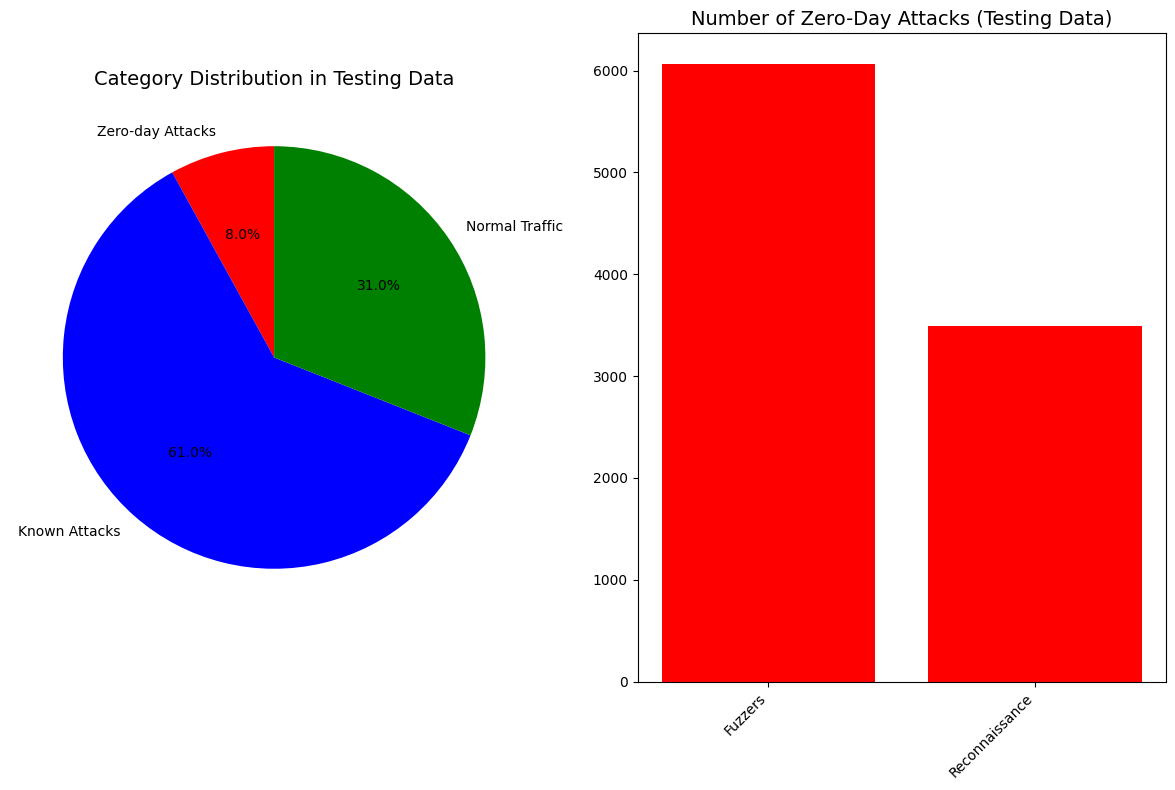


Pre-processing completed! Data is ready for model training and evaluation.


In [18]:
# 17. Additional: Visualizing distribution of zero-day vs non-zero-day categories
plt.figure(figsize=(12, 8))

# Datasets for visualization
zero_day_categories = ['Fuzzers', 'Reconnaissance']
non_zero_day_categories = [cat for cat in test_data['attack_cat'].unique() 
                          if cat in train_data['attack_cat'].unique() and cat != 'normal']

# Distribution in test set
zero_day_count = test_data[test_data['attack_cat'].isin(zero_day_categories)].shape[0]
non_zero_day_count = test_data[test_data['attack_cat'].isin(non_zero_day_categories)].shape[0]
normal_count = test_data[test_data['label'] == 0].shape[0]

# Plot pie chart
plt.subplot(1, 2, 1)
plt.pie([zero_day_count, non_zero_day_count, normal_count], 
        labels=['Zero-day Attacks', 'Known Attacks', 'Normal Traffic'],
        autopct='%1.1f%%', startangle=90, colors=['red', 'blue', 'green'])
plt.title('Category Distribution in Testing Data', fontsize=14)

# Plot comparison of zero-day vs non-zero-day attacks
plt.subplot(1, 2, 2)
zero_day_dist = test_data[test_data['attack_cat'].isin(zero_day_categories)]['attack_cat'].value_counts()
plt.bar(zero_day_dist.index, zero_day_dist.values, color='red')
plt.title('Number of Zero-Day Attacks (Testing Data)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('zero_day_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPre-processing completed! Data is ready for model training and evaluation.")

# Model Development

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, 
                            f1_score, precision_recall_curve, roc_curve, auc, 
                            precision_score, recall_score)
import joblib
from tqdm import tqdm

# ENVIRONMENT DEFINITION

In [20]:
# ===== 1. Environment and Agent Definition =====

class NetworkTrafficEnvironment:
    """
    Environment representing anomaly detection with a simple reward structure.
    """
    
    def __init__(self, X, y, n_states=30, state_clusters=None, random_state=42):
        self.X = X
        self.y = y
        self.n_states = n_states
        self.n_actions = 2  # 0: Normal, 1: Anomaly
        
        # Still use clustering for discretization (required for tabular Q-learning)
        if state_clusters is None:
            print("Performing clustering for state representation...")
            self.state_clusters = MiniBatchKMeans(
                n_clusters=n_states, 
                random_state=random_state,
                batch_size=1000,
                max_iter=300,
                n_init=10
            )
            self.state_clusters.fit(X)
            
            # Check cluster balance
            cluster_labels = self.state_clusters.predict(X)
            unique, counts = np.unique(cluster_labels, return_counts=True)
            cluster_sizes = dict(zip(unique, counts))
            print(f"Cluster distribution: Min={min(counts)}, Max={max(counts)}, Avg={np.mean(counts):.1f}")
        else:
            self.state_clusters = state_clusters
            print("Using a pre-trained clusterer...")
        
        # Map each sample to a state (cluster)
        self.states = self.state_clusters.predict(X)
        
        # Store current position in the dataset
        self.current_index = 0
        self.reset()
        
    def reset(self):
        """Reset environment to the initial state and return the initial state."""
        self.current_index = 0
        state = self._get_current_state()
        return state
        
    def step(self, action):
        """
        Take an action in the environment and get the result.
        Simple reward structure for pure Q-learning.
        """
        # Get the true label of the current sample
        true_label = self.y[self.current_index]
        
        # Simple reward function
        if action == true_label:
            reward = 1.0  # Correct
        else:
            reward = -1.0  # Incorrect
        
        # Move to the next sample
        self.current_index += 1
        done = self.current_index >= len(self.X)
        
        # If reached the end of the dataset, prevent out of bounds
        if done:
            next_state = None
            info = {
                'true_label': true_label,
                'prediction': action
            }
        else:
            next_state = self._get_current_state()
            info = {
                'true_label': true_label,
                'prediction': action
            }
        
        return next_state, reward, done, info
    
    def _get_current_state(self):
        """Get the state representation of the current sample."""
        if self.current_index >= len(self.X):
            return None
        return self.states[self.current_index]

class QLearningAgent:
    """
    Agent using the pure Q-Learning algorithm.
    """
    
    def __init__(self, n_states, n_actions, alpha=0.1, gamma=0.95, epsilon=0.8, 
                 epsilon_decay=0.995, epsilon_min=0.1):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha  # Fixed learning rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Initialize Q-Table with zeros (no bias)
        self.q_table = np.zeros((n_states, n_actions))
        
        # For policy extraction
        self.policy = np.zeros(n_states, dtype=int)
        
        # Simple tracking metrics
        self.rewards_history = []
        self.epsilon_history = []
        self.accuracy_history = []
    
    def choose_action(self, state, training=True):
        """
        Choose an action using simple epsilon-greedy (not state-dependent)
        """
        if training and np.random.random() < self.epsilon:
            # Exploration: Choose a random action
            return np.random.randint(0, self.n_actions)
        else:
            # Exploitation: Choose the best action based on Q-table
            return np.argmax(self.q_table[state])
    
    def learn(self, state, action, reward, next_state):
        """
        Update the Q-table using the standard Q-learning formula and fixed learning rate
        """
        if next_state is not None:
            # Standard Q-Learning formula
            best_next_value = np.max(self.q_table[next_state])
            target = reward + self.gamma * best_next_value
        else:
            # Terminal state
            target = reward
        
        # Update Q-value with fixed learning rate
        self.q_table[state, action] += self.alpha * (target - self.q_table[state, action])
    
    def decay_epsilon(self):
        """Decrease epsilon to reduce exploration over time."""
        if self.epsilon > self.epsilon_min:
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
    
    def extract_policy(self):
        """Extract policy from the Q-table."""
        self.policy = np.argmax(self.q_table, axis=1)
        return self.policy

# Q Learning MODEL

In [21]:
class QLearningAgent:
    """
    Agent using the pure Q-Learning algorithm.
    """
    
    def __init__(self, n_states, n_actions, alpha=0.1, gamma=0.95, epsilon=0.8, 
                 epsilon_decay=0.995, epsilon_min=0.1):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha  # Fixed learning rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Initialize Q-Table with zeros (no bias)
        self.q_table = np.zeros((n_states, n_actions))
        
        # For policy extraction
        self.policy = np.zeros(n_states, dtype=int)
        
        # Simple tracking metrics
        self.rewards_history = []
        self.epsilon_history = []
        self.accuracy_history = []
    
    def choose_action(self, state, training=True):
        """
        Choose an action using simple epsilon-greedy (not state-dependent)
        """
        if training and np.random.random() < self.epsilon:
            # Exploration: Choose a random action
            return np.random.randint(0, self.n_actions)
        else:
            # Exploitation: Choose the best action based on Q-table
            return np.argmax(self.q_table[state])
    
    def learn(self, state, action, reward, next_state):
        """
        Update the Q-table using the standard Q-learning formula and fixed learning rate
        """
        if next_state is not None:
            # Standard Q-Learning formula
            best_next_value = np.max(self.q_table[next_state])
            target = reward + self.gamma * best_next_value
        else:
            # Terminal state
            target = reward
        
        # Update Q-value with fixed learning rate
        self.q_table[state, action] += self.alpha * (target - self.q_table[state, action])
    
    def decay_epsilon(self):
        """Decrease epsilon to reduce exploration over time."""
        if self.epsilon > self.epsilon_min:
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
    
    def extract_policy(self):
        """Extract policy from the Q-table."""
        self.policy = np.argmax(self.q_table, axis=1)
        return self.policy

# Memory Monitoring Functions

In [22]:
import psutil
import time
import sys
import numpy as np

# Class Memory Monitor
class MemoryMonitor:
    """Class untuk monitoring penggunaan memori"""
    
    def __init__(self):
        self.process = psutil.Process()
        self.initial_memory = self.get_current_memory()
        self.peak_memory = self.initial_memory
        
    def get_current_memory(self):
        """Dapatkan penggunaan RAM saat ini dalam MB"""
        return self.process.memory_info().rss / 1024 / 1024
    
    def update_peak(self):
        """Update peak memory usage"""
        current_ram = self.get_current_memory()
        
        self.peak_memory = max(self.peak_memory, current_ram)
        
        return {
            'current_ram_mb': current_ram,
            'peak_ram_mb': self.peak_memory,
            'ram_usage_from_start_mb': current_ram - self.initial_memory
        }

def get_qtable_size(agent):
    """Hitung ukuran Q-table dalam MB"""
    # Q-table size in bytes = rows * columns * 8 bytes (float64)
    qtable_size_bytes = agent.q_table.shape[0] * agent.q_table.shape[1] * 8
    # Convert to MB
    qtable_size_mb = qtable_size_bytes / (1024 * 1024)
    return qtable_size_mb

def measure_inference_speed(agent, states, n_iterations=1000):
    """Ukur kecepatan inferensi"""
    # Ensure states is an array
    if not isinstance(states, np.ndarray):
        states = np.array(states)
    
    # Warm up
    for i in range(10):
        state_idx = i % len(states)
        _ = agent.choose_action(states[state_idx], training=False)
    
    # Measure inference time
    start_time = time.time()
    for i in range(n_iterations):
        state_idx = i % len(states)
        _ = agent.choose_action(states[state_idx], training=False)
    end_time = time.time()
    
    total_time = end_time - start_time
    avg_inference_time = total_time / n_iterations
    samples_per_second = n_iterations / total_time
    
    return {
        'avg_inference_time_ms': avg_inference_time * 1000,
        'samples_per_second': samples_per_second,
        'total_time_seconds': total_time
    }

def create_memory_comparison_table(results_df):
    """
    Buat tabel memory footprint untuk Q-Learning
    """
    if 'memory_metrics' not in results_df.attrs:
        print("Memory metrics tidak tersedia. Jalankan training dengan monitoring dulu.")
        return
    
    memory_metrics = results_df.attrs['memory_metrics']
    
    # Ambil scheme terbaik (berdasarkan zero-day recall)
    best_scheme_idx = results_df['zero_day_recall'].idxmax()
    best_memory = memory_metrics[best_scheme_idx]
    
    # Buat tabel untuk Q-Learning
    comparison_data = {
        'Metrik': [
            'Training Time (seconds)',
            'Training Time (minutes)', 
            'Peak RAM Usage (MB)',
            'Q-Table Size (MB)',
            'Total Memory Footprint (MB)',
            'Avg Inference Time (ms)',
            'Inference Speed (samples/sec)',
            'Memory Efficiency (samples/MB)'
        ],
        'Q-Learning (Best Scheme)': [
            f"{best_memory['training_time_seconds']:.1f}",
            f"{best_memory['training_time_seconds']/60:.2f}",
            f"{best_memory['peak_ram_mb']:.1f}",
            f"{best_memory['qtable_size_mb']:.4f}",
            f"{best_memory['peak_ram_mb']:.1f}",
            f"{best_memory['avg_inference_time_ms']:.2f}",
            f"{best_memory['samples_per_second']:.1f}",
            f"{1000/best_memory['peak_ram_mb']:.1f}"
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + "="*80)
    print("Q-LEARNING MEMORY FOOTPRINT ANALYSIS")
    print("="*80)
    print(comparison_df.to_string(index=False))
    
    # Tambahkan analisis tambahan
    print("\n" + "="*80)
    print("DETAILED MEMORY ANALYSIS")
    print("="*80)
    print(f"Best Scheme: Scheme {best_scheme_idx + 1}")
    print(f"Alpha: {best_memory['alpha']}")
    print(f"Gamma: {best_memory['gamma']}")
    print(f"Epsilon: {best_memory['epsilon']}")
    print(f"\nMemory Breakdown:")
    print(f"  - Q-Table Size: {best_memory['qtable_size_mb']:.4f} MB")
    print(f"  - Peak RAM Usage: {best_memory['peak_ram_mb']:.1f} MB")
    print(f"\nPerformance Metrics:")
    print(f"  - Training Time: {best_memory['training_time_seconds']:.1f} seconds ({best_memory['training_time_seconds']/60:.2f} minutes)")
    print(f"  - Inference Speed: {best_memory['samples_per_second']:.1f} samples/second")
    print(f"  - Average Inference Time: {best_memory['avg_inference_time_ms']:.2f} ms per sample")
    
    return comparison_df

# TRAINING FUNCTIONS

In [23]:
def train_qlearning_agent(env, agent, n_episodes=500, evaluation_env=None, zero_day_env=None):
    """
    Train a Q-learning agent in the environment.
    """
    
    # Tracking metrics
    episode_rewards = []
    episode_accuracies = []
    episode_epsilons = []
    evaluation_accuracies = []
    evaluation_detection_rates = []
    evaluation_f1s = []
    
    # Add these lists for zero-day evaluation metrics tracking
    zero_day_evaluation_accuracies = []
    zero_day_evaluation_detection_rates = []
    zero_day_evaluation_f1s = []
    
    best_detection_rate = 0
    best_agent = None
    
    for episode in tqdm(range(n_episodes), desc="Training Q-Learning Agent"):
        state = env.reset()
        done = False
        total_reward = 0
        predictions = []
        true_labels = []
        
        # Iterate through one episode (the entire dataset)
        while not done:
            # Choose action based on state
            action = agent.choose_action(state)
            
            # Take action in the environment
            next_state, reward, done, info = env.step(action)
            
            # Agent learns from experience
            agent.learn(state, action, reward, next_state)
            
            # Update state
            state = next_state
            
            # Accumulate reward and predictions
            total_reward += reward
            predictions.append(action)
            true_labels.append(info['true_label'])
        
        # After the episode ends
        agent.decay_epsilon()
        
        # Calculate episode accuracy
        episode_accuracy = accuracy_score(true_labels, predictions)
        
        # Save metrics
        episode_rewards.append(total_reward)
        episode_accuracies.append(episode_accuracy)
        episode_epsilons.append(agent.epsilon)
        
        # Evaluate on test data if provided
        if evaluation_env is not None and (episode + 1) % 5 == 0:
            eval_metrics = evaluate_agent(evaluation_env, agent)
            evaluation_accuracies.append(eval_metrics['accuracy'])
            evaluation_detection_rates.append(eval_metrics['detection_rate'])
            evaluation_f1s.append(eval_metrics['f1_score'])
            
            # Save agent with the best detection rate
            if eval_metrics['detection_rate'] > best_detection_rate:
                best_detection_rate = eval_metrics['detection_rate']
                best_agent = agent.q_table.copy()
        
        # Add evaluation on zero-day data
        if zero_day_env is not None :
            zd_metrics = evaluate_agent(zero_day_env, agent)
            zero_day_evaluation_accuracies.append(zd_metrics['accuracy'])
            zero_day_evaluation_detection_rates.append(zd_metrics['detection_rate'])
            zero_day_evaluation_f1s.append(zd_metrics['f1_score'])
        
        # Print progress every 5 episodes
        if (episode + 1) % 5 == 0:
            print(f"Episode {episode+1}/{n_episodes}, "
                  f"Reward: {total_reward:.2f}, "
                  f"Train Accuracy: {episode_accuracy:.4f}, "
                  f"Epsilon: {agent.epsilon:.4f}")
            if evaluation_env is not None and len(evaluation_accuracies) > 0:
                print(f"  Test Accuracy: {evaluation_accuracies[-1]:.4f}, "
                      f"Test Detection Rate: {evaluation_detection_rates[-1]:.4f}, "
                      f"Test F1: {evaluation_f1s[-1]:.4f}")
            if zero_day_env is not None and len(zero_day_evaluation_accuracies) > 0:
                print(f"  Zero-day Accuracy: {zero_day_evaluation_accuracies[-1]:.4f}, "
                      f"Zero-day Detection Rate: {zero_day_evaluation_detection_rates[-1]:.4f}, "
                      f"Zero-day F1: {zero_day_evaluation_f1s[-1]:.4f}")
    
    # Save history to agent
    agent.rewards_history = episode_rewards
    agent.accuracy_history = episode_accuracies
    agent.epsilon_history = episode_epsilons
    
    # If best_agent is found, use it
    if best_agent is not None:
        print(f"Using agent with the best detection rate: {best_detection_rate:.4f}")
        agent.q_table = best_agent
    
    # Extract optimal policy from Q-table
    policy = agent.extract_policy()
    
    metrics = {
        'rewards': episode_rewards,
        'accuracies': episode_accuracies,
        'epsilons': episode_epsilons,
        'evaluation_accuracies': evaluation_accuracies,
        'evaluation_detection_rates': evaluation_detection_rates,
        'evaluation_f1s': evaluation_f1s,
        'zero_day_evaluation_accuracies': zero_day_evaluation_accuracies,
        'zero_day_evaluation_detection_rates': zero_day_evaluation_detection_rates,
        'zero_day_evaluation_f1s': zero_day_evaluation_f1s
    }
    
    return agent, metrics

# EVALUATION FUNCTIONS

In [24]:
# ===== 3. Evaluation and Zero-Day Analysis Functions =====

def evaluate_agent(env, agent):
    """
    Evaluate agent performance in the environment.
    """
    state = env.reset()
    done = False
    predictions = []
    true_labels = []
    q_values = []
    
    # Use the agent to make predictions
    while not done:
        action = agent.choose_action(state, training=False)  # Use greedy policy
        q_val = agent.q_table[state].copy()  # Save Q-values for ROC analysis
        next_state, _, done, info = env.step(action)
        state = next_state
        
        predictions.append(action)
        true_labels.append(info['true_label'])
        q_values.append(q_val)
    
    # Convert to arrays for easier calculation
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    q_values = np.array(q_values)
    
    # Calculate basic metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, zero_division=0)
    recall = recall_score(true_labels, predictions, zero_division=0)
    f1 = f1_score(true_labels, predictions, zero_division=0)
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Ensure confusion matrix is 2x2
    if conf_matrix.shape == (2, 2):
        tn, fp, fn, tp = conf_matrix.ravel()
    else:
        # If only one class in predictions, create custom confusion matrix
        tn = np.sum((true_labels == 0) & (predictions == 0))
        fp = np.sum((true_labels == 0) & (predictions == 1))
        fn = np.sum((true_labels == 1) & (predictions == 0))
        tp = np.sum((true_labels == 1) & (predictions == 1))

    # Calculate TPR, FPR, and TNR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate (Detection Rate)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate (Specificity)
    
    # For ROC curve, use probability of action 1 (anomaly) from Q-values
    # Normalize Q-values to get probabilities
    q_probs = q_values[:, 1] / np.sum(q_values, axis=1)
    
    # Calculate ROC curve and AUC
    fpr_curve, tpr_curve, _ = roc_curve(true_labels, q_probs)
    roc_auc = auc(fpr_curve, tpr_curve)

    # Calculate Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(true_labels, q_probs)
    
    # Classification report
    try:
        report = classification_report(true_labels, predictions, output_dict=True, zero_division=0)
    except Exception:
        # If error (e.g., only one class), create report manually
        report = {
            "0": {"precision": tn/(tn+fn) if (tn+fn)>0 else 0, "recall": tn/(tn+fp) if (tn+fp)>0 else 0},
            "1": {"precision": tp/(tp+fp) if (tp+fp)>0 else 0, "recall": tp/(tp+fn) if (tp+fn)>0 else 0}
        }
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'detection_rate': tpr,
        'false_positive_rate': fpr,
        'true_negative_rate': tnr,
        'roc_auc': roc_auc,
        'fpr_curve': fpr_curve,
        'tpr_curve': tpr_curve,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve,
        'classification_report': report
    }
    
    return metrics

# HYPERPARAMETER SEARCH

In [25]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def specific_scheme_search_qlearning(X_train, y_train, X_test, y_test, zero_day_data, zero_day_labels):
    """
    Function to evaluate 5 specific hyperparameter schemes for Q-Learning with memory monitoring
    """
    # Define 5 specific hyperparameter schemes for Q-Learning
    specific_params = [
        {'alpha': 0.01, 'gamma': 0.8, 'epsilon': 1.0, 'epsilon_decay': 0.8, 'epsilon_min': 0.05},
        {'alpha': 0.1, 'gamma': 0.95, 'epsilon': 1.0, 'epsilon_decay': 0.95, 'epsilon_min': 0.2},
        {'alpha': 0.03, 'gamma': 0.99, 'epsilon': 0.8, 'epsilon_decay': 0.99, 'epsilon_min': 0.3},
        {'alpha': 0.5, 'gamma': 0.9, 'epsilon': 0.7, 'epsilon_decay': 0.9, 'epsilon_min': 0.1},
        {'alpha': 0.2, 'gamma': 0.7, 'epsilon': 0.9, 'epsilon_decay': 0.85, 'epsilon_min': 0.01}
    ]
    
    # Setup for tracking results
    results = []
    memory_results = []  # Add memory results tracking
    best_detection_rate = 0
    best_agent = None
    best_metrics = None
    best_params = None
    
    # Store metrics for visualization
    all_test_metrics = []
    all_zero_day_metrics = []
    all_training_metrics = []
    
    print(f"Evaluating 5 specific hyperparameter schemes for Q-Learning")
    
    # Setup environment once
    n_states = 30
    sample_size = int(len(X_train) * 0.5)  # Use 50% of data for speed
    indices = np.random.choice(len(X_train), sample_size, replace=False)
    X_train_sample = X_train.iloc[indices].values
    y_train_sample = y_train[indices]
    
    print(f"Using {sample_size} samples from {len(X_train)} original data (50.0%)")
    
    # Evaluate each scheme
    for i, params in enumerate(tqdm(specific_params, desc="Evaluating Schemes")):
        print(f"\nScheme {i+1}/5: {params}")
        
        # Initialize memory monitor untuk scheme ini
        scheme_memory_monitor = MemoryMonitor()
        start_time = time.time()
        
        # Add variation in data sampling and random seed
        sample_size = int(len(X_train) * 0.5)
        indices = np.random.choice(len(X_train), sample_size, replace=False)
        X_train_sample = X_train.iloc[indices].values
        y_train_sample = y_train[indices]
        
        random_state = 42

        # Create environment with larger clustering variation
        train_env = NetworkTrafficEnvironment(
            X_train_sample, 
            y_train_sample, 
            n_states=n_states,
            random_state=random_state
        )
        test_env = NetworkTrafficEnvironment(X_test.values, y_test, state_clusters=train_env.state_clusters)
        zero_day_env = NetworkTrafficEnvironment(zero_day_data.values, zero_day_labels, 
                                            n_states=train_env.n_states, 
                                            state_clusters=train_env.state_clusters)
        
        # Initialize agent with current parameters
        agent = QLearningAgent(
            n_states=train_env.n_states,
            n_actions=2,
            **params
        )
        
        # Monitor memory at start
        memory_stats = scheme_memory_monitor.update_peak()
        
        # Train agent
        try:
            trained_agent, training_metrics = train_qlearning_agent(
                train_env,
                agent,
                n_episodes=30,
                evaluation_env=test_env,
                zero_day_env=zero_day_env
            )
            
            end_time = time.time()
            training_time = end_time - start_time
            
            all_training_metrics.append(training_metrics)
            
            # Evaluate on test data
            test_metrics = evaluate_agent(test_env, trained_agent)
            
            # Evaluate on zero-day data using standard evaluation
            zero_day_metrics = evaluate_agent(zero_day_env, trained_agent)
            
            # Save full metrics for visualization
            all_test_metrics.append(test_metrics)
            all_zero_day_metrics.append(zero_day_metrics)
            
            # Measure inference speed
            test_states = train_env.states[:min(1000, len(train_env.states))]
            inference_metrics = measure_inference_speed(trained_agent, test_states)
            
            # Get Q-table size
            qtable_size_mb = get_qtable_size(trained_agent)
            
            # Update final memory stats
            final_memory_stats = scheme_memory_monitor.update_peak()
            
            # Collect memory metrics
            memory_result = {
                'scheme': f"Scheme {i+1}",
                'training_time_seconds': training_time,
                'peak_ram_mb': final_memory_stats['peak_ram_mb'],
                'qtable_size_mb': qtable_size_mb,
                'avg_inference_time_ms': inference_metrics['avg_inference_time_ms'],
                'samples_per_second': inference_metrics['samples_per_second'],
                **params  # Include all hyperparameters
            }
            memory_results.append(memory_result)
            
            # Record results
            result = {
                **params,
                'scheme': f"Scheme {i+1}",
                'training_time_seconds': training_time,
                'test_accuracy': test_metrics['accuracy'],
                'test_precision': test_metrics['precision'],
                'test_recall': test_metrics['detection_rate'],
                'test_f1': test_metrics['f1_score'],
                'test_fpr': test_metrics['false_positive_rate'],
                'test_auc': test_metrics['roc_auc'],
                'zero_day_accuracy': zero_day_metrics['accuracy'],
                'zero_day_precision': zero_day_metrics['precision'],
                'zero_day_recall': zero_day_metrics['detection_rate'],
                'zero_day_f1': zero_day_metrics['f1_score'],
                'zero_day_fpr': zero_day_metrics['false_positive_rate'],
                'zero_day_auc': zero_day_metrics.get('roc_auc', 0.5),
                # Add memory metrics
                'peak_ram_mb': final_memory_stats['peak_ram_mb'],
                'qtable_size_mb': qtable_size_mb,
                'inference_time_ms': inference_metrics['avg_inference_time_ms']
            }
            results.append(result)
            
            # Update best model if performance on zero-day is better
            if zero_day_metrics['detection_rate'] > best_detection_rate:
                best_detection_rate = zero_day_metrics['detection_rate']
                # For Q-Learning, we save the Q-table rather than the agent itself
                best_agent = {
                    'q_table': trained_agent.q_table.copy(),
                    'policy': trained_agent.policy.copy()
                }
                best_metrics = training_metrics
                best_params = params
                print(f"Best model updated! Zero-day detection rate: {best_detection_rate:.4f}")
            
        except Exception as e:
            print(f"Error in scheme {i+1}: {e}")
            continue
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Store metrics as attributes
    results_df.attrs['test_metrics'] = all_test_metrics
    results_df.attrs['zero_day_metrics'] = all_zero_day_metrics
    results_df.attrs['training_metrics'] = all_training_metrics
    results_df.attrs['memory_metrics'] = memory_results  # Add memory metrics
    
    # Display summary of results
    print("\n" + "="*80)
    print("SCHEME EVALUATION RESULTS")
    print("="*80)
    print(f"Total schemes successfully evaluated: {len(results)}")
    print(f"Best parameters: {best_params}")
    print(f"Best zero-day detection rate: {best_detection_rate:.4f}")
    
    # Display scheme rankings based on detection rate
    print("\nScheme ranking based on zero-day detection rate:")
    sorted_results = results_df.sort_values('zero_day_recall', ascending=False)
    for i, (_, row) in enumerate(sorted_results.iterrows()):
        print(f"{i+1}. {row['scheme']} - Zero-day Recall: {row['zero_day_recall']:.4f}, F1: {row['zero_day_f1']:.4f}")
    
    # Print memory comparison table
    print("\n" + "="*80)
    print("MEMORY FOOTPRINT COMPARISON")
    print("="*80)
    memory_df = pd.DataFrame(memory_results)
    print(memory_df.to_string(index=False))
    
    # Create a new agent with the best parameters if we need to return a trained agent
    if best_params:
        best_trained_agent = QLearningAgent(
            n_states=train_env.n_states,
            n_actions=2,
            **best_params
        )
        best_trained_agent.q_table = best_agent['q_table']
        best_trained_agent.policy = best_agent['policy']
    else:
        best_trained_agent = None
    
    return results_df, best_trained_agent, best_metrics

# VISUALIZATION FUNCTIONS

In [ ]:
def visualize_validation_performance(results_file, plot_all_schemes=False):
    """
    Visualize the validation performance of Q-learning models during training.
    
    Parameters:
    - results_file: Path to the pickle file containing evaluation results
    - plot_all_schemes: Boolean to display all schemes or only the best scheme
    """
    try:
        # Load evaluation results
        results_df = pd.read_pickle(results_file)
        
        if plot_all_schemes:
            # Create separate plots for each scheme
            for i in range(len(results_df)):
                scheme_name = f"Scheme {i+1}"
                
                if ('training_metrics' not in results_df.attrs or 
                    i >= len(results_df.attrs['training_metrics'])):
                    continue
                
                # Get metrics for this scheme
                metrics = results_df.attrs['training_metrics'][i]
                
                # Create new figure for this scheme
                plt.figure(figsize=(12, 8))
                
                # Plot training accuracy
                train_accuracy = metrics['accuracies']
                train_episodes = range(len(train_accuracy))
                plt.plot(train_episodes, train_accuracy, 'r-', 
                         label='Training Accuracy', linewidth=1.5)
                
                # Plot validation accuracy
                if 'evaluation_accuracies' in metrics and len(metrics['evaluation_accuracies']) > 0:
                    eval_accuracy = metrics['evaluation_accuracies']
                    eval_episodes = np.arange(0, len(train_accuracy), 5)[:len(eval_accuracy)]
                    plt.plot(eval_episodes, eval_accuracy, 'b-', 
                             label='Validation Accuracy', linewidth=2)
                
                # Plot detection rate (recall)
                if 'evaluation_detection_rates' in metrics and len(metrics['evaluation_detection_rates']) > 0:
                    detection_rates = metrics['evaluation_detection_rates']
                    plt.plot(eval_episodes, detection_rates, 'g-', 
                             label='Detection Rate', linewidth=2)
                
                # Plot F1-score
                if 'evaluation_f1s' in metrics and len(metrics['evaluation_f1s']) > 0:
                    f1_scores = metrics['evaluation_f1s']
                    plt.plot(eval_episodes, f1_scores, 'm-', 
                             label='F1 Score', linewidth=2)
                
                plt.title(f'Performance Metrics: {scheme_name}')
                plt.xlabel('Episode')
                plt.ylabel('Score')
                plt.legend()
                plt.grid(alpha=0.3)
                plt.tight_layout()
                plt.savefig(f'validation_performance_scheme_{i+1}.png', dpi=300)
                plt.show()
        
        else:
            # Show only the best scheme
            best_scheme_idx = results_df['zero_day_recall'].idxmax()
            best_scheme = best_scheme_idx + 1  # Schemes start from 1
            
            if ('training_metrics' in results_df.attrs and 
                best_scheme_idx < len(results_df.attrs['training_metrics'])):
                
                # Get metrics for the best scheme
                metrics = results_df.attrs['training_metrics'][best_scheme_idx]
                
                # 1. Create plot for accuracy comparison
                plt.figure(figsize=(14, 8))
                
                # Plot training accuracy
                train_accuracy = metrics['accuracies']
                train_episodes = range(len(train_accuracy))
                plt.plot(train_episodes, train_accuracy, 'r-', 
                         label='Training Accuracy', linewidth=2)
                
                # Plot validation metrics
                if 'evaluation_accuracies' in metrics and len(metrics['evaluation_accuracies']) > 0:
                    eval_accuracy = metrics['evaluation_accuracies']
                    eval_episodes = np.arange(0, len(train_accuracy), 5)[:len(eval_accuracy)]
                    plt.plot(eval_episodes, eval_accuracy, 'b-', 
                             label='Validation Accuracy', linewidth=2.5, marker='o')
                
                # Plot zero-day accuracy if available
                if 'zero_day_evaluation_accuracies' in metrics and len(metrics['zero_day_evaluation_accuracies']) > 0:
                    zd_accuracy = metrics['zero_day_evaluation_accuracies']
                    # Make sure data lengths match
                    if len(zd_accuracy) == len(eval_episodes):
                        plt.plot(eval_episodes, zd_accuracy, 'g-', 
                                 label='Zero-day Accuracy', linewidth=2, marker='s')
                
                # Detect overfitting
                if 'evaluation_accuracies' in metrics and len(metrics['evaluation_accuracies']) > 3:
                    eval_acc = metrics['evaluation_accuracies']
                    for i in range(3, len(eval_acc)):
                        # If validation accuracy decreases while training accuracy increases
                        if (eval_acc[i] < eval_acc[i-1] and 
                            train_accuracy[eval_episodes[i]] > train_accuracy[eval_episodes[i-1]]):
                            plt.axvline(x=eval_episodes[i], color='r', linestyle='--', alpha=0.5)
                            plt.text(eval_episodes[i], 0.5, "Possible Overfitting", 
                                     rotation=90, verticalalignment='center')
                            break
                
                plt.title(f'Validation Performance: Scheme {best_scheme} (Best Scheme)', fontsize=14)
                plt.xlabel('Episode', fontsize=12)
                plt.ylabel('Accuracy', fontsize=12)
                plt.grid(alpha=0.3)
                plt.legend()
                plt.tight_layout()
                plt.savefig('accuracy_comparison_best_scheme.png', dpi=300)
                plt.show()
                
                # 2. Create separate plot for Detection Rate and F1 Score
                plt.figure(figsize=(14, 8))
                
                # Plot detection rate (recall)
                if 'evaluation_detection_rates' in metrics and len(metrics['evaluation_detection_rates']) > 0:
                    detection_rates = metrics['evaluation_detection_rates']
                    plt.plot(eval_episodes, detection_rates, 'g-', 
                             label='Detection Rate (Recall)', linewidth=2, marker='o')
                
                # Plot F1-score
                if 'evaluation_f1s' in metrics and len(metrics['evaluation_f1s']) > 0:
                    f1_scores = metrics['evaluation_f1s']
                    plt.plot(eval_episodes, f1_scores, 'm-', 
                             label='F1 Score', linewidth=2, marker='s')
                
                plt.title(f'Detection Rate and F1 Score Metrics: Scheme {best_scheme}', fontsize=14)
                plt.xlabel('Episode', fontsize=12)
                plt.ylabel('Score', fontsize=12)
                plt.grid(alpha=0.3)
                plt.legend()
                plt.tight_layout()
                plt.savefig('detection_f1_metrics_best_scheme.png', dpi=300)
                plt.show()
                
                # 3. Create separate plot for Learning Curve
                plt.figure(figsize=(14, 8))
                
                # Plot epsilon curve (exploration vs exploitation)
                if 'epsilons' in metrics and len(metrics['epsilons']) > 0:
                    epsilons = metrics['epsilons']
                    plt.plot(train_episodes, epsilons, 'b-', 
                             label='Epsilon (Exploration Rate)', linewidth=2)
                
                # Plot rewards
                if 'rewards' in metrics and len(metrics['rewards']) > 0:
                    rewards = metrics['rewards']
                    min_reward = min(rewards)
                    max_reward = max(rewards)
                    normalized_rewards = [(r - min_reward) / (max_reward - min_reward + 1e-9) for r in rewards]
                    plt.plot(train_episodes, normalized_rewards, 'g-', 
                            label='Normalized Rewards', linewidth=2, alpha=0.7)
                
                plt.title(f'Learning Curve: Scheme {best_scheme} (Best Scheme)', fontsize=14)
                plt.xlabel('Episode', fontsize=12)
                plt.ylabel('Value', fontsize=12)
                plt.grid(alpha=0.3)
                plt.legend()
                plt.tight_layout()
                plt.savefig('learning_curve_best_scheme.png', dpi=300)
                plt.show()
            
            else:
                print("Training metrics data not available for best scheme.")
    
    except Exception as e:
        print(f"Error in validation visualization: {str(e)}")
        import traceback
        traceback.print_exc()

# Example usage:
# visualize_validation_performance('qlearning_scheme_evaluation_20250513-123456.pkl')
# visualize_validation_performance('qlearning_scheme_evaluation_20250513-123456.pkl', plot_all_schemes=True)

In [26]:
def get_confusion_matrix_qlearning(scheme_idx, is_zeroday=False, results_df=None):
    """
    Create confusion matrix from actual prediction results
    """
    if results_df is None:
        raise ValueError("results_df must be provided to access actual predictions")
    
    if is_zeroday:
        if 'zero_day_metrics' not in results_df.attrs or scheme_idx >= len(results_df.attrs['zero_day_metrics']):
            raise ValueError(f"Zero-day metrics not available for scheme {scheme_idx}")
        
        metrics = results_df.attrs['zero_day_metrics'][scheme_idx]
        if 'confusion_matrix' in metrics:
            return metrics['confusion_matrix']
        else:
            # If no confusion matrix stored, recreate from predictions if available
            true_labels = metrics.get('true_labels', [])
            predictions = metrics.get('predictions', [])
            if len(true_labels) > 0 and len(predictions) > 0:
                return confusion_matrix(true_labels, predictions, labels=[0, 1])
            else:
                raise ValueError(f"Predictions not available for scheme {scheme_idx}")
    else:
        if 'test_metrics' not in results_df.attrs or scheme_idx >= len(results_df.attrs['test_metrics']):
            raise ValueError(f"Test metrics not available for scheme {scheme_idx}")
        
        metrics = results_df.attrs['test_metrics'][scheme_idx]
        if 'confusion_matrix' in metrics:
            return metrics['confusion_matrix']
        else:
            # If no confusion matrix stored, recreate from predictions if available
            true_labels = metrics.get('true_labels', [])
            predictions = metrics.get('predictions', [])
            if len(true_labels) > 0 and len(predictions) > 0:
                return confusion_matrix(true_labels, predictions, labels=[0, 1])
            else:
                raise ValueError(f"Predictions not available for scheme {scheme_idx}")


def plot_confusion_matrices_qlearning(results_df):
    """
    Plot confusion matrices for all schemes using actual prediction results
    """
    plt.figure(figsize=(15, 10))
    
    # Plots for test data
    for i in range(len(results_df)):
        plt.subplot(2, 5, i+1)
        try:
            cm = get_confusion_matrix_qlearning(i, is_zeroday=False, results_df=results_df)
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
            accuracy = results_df['test_accuracy'].iloc[i]
            recall = results_df['test_recall'].iloc[i]
            plt.title(f'Test Data - Scheme {i+1}\nAcc: {accuracy:.3f} DR: {recall:.3f}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.xticks([0.5, 1.5], ['Normal', 'Attack'])
            plt.yticks([0.5, 1.5], ['Normal', 'Attack'])
        except Exception as e:
            plt.text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center', transform=plt.gca().transAxes)
    
    # Plots for zero-day data
    for i in range(len(results_df)):
        plt.subplot(2, 5, i+6)
        try:
            cm = get_confusion_matrix_qlearning(i, is_zeroday=True, results_df=results_df)
            sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", cbar=False)
            accuracy = results_df['zero_day_accuracy'].iloc[i]
            recall = results_df['zero_day_recall'].iloc[i]
            plt.title(f'Zero-day - Scheme {i+1}\nAcc: {accuracy:.3f} DR: {recall:.3f}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.xticks([0.5, 1.5], ['Normal', 'Attack'])
            plt.yticks([0.5, 1.5], ['Normal', 'Attack'])
        except Exception as e:
            plt.text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center', transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.savefig('qlearning_confusion_matrices.png', dpi=300)
    plt.show()


def visualize_model_comparison_qlearning(results_df, top_n=5):
    """
    Visualize comparison between the top schemes
    """
    from matplotlib.gridspec import GridSpec
    from matplotlib.colors import LinearSegmentedColormap
    
    # Get top N models based on zero-day detection rate
    top_models = results_df.sort_values('zero_day_recall', ascending=False).head(top_n)
    
    # Create labels for each scheme
    scheme_labels = [f"Scheme {i+1}" for i in range(len(top_models))]
    
    # Extract parameters for each scheme
    param_values = []
    for _, model in top_models.iterrows():
        param_values.append({
            'alpha': model['alpha'],
            'gamma': model['gamma'],
            'epsilon': model['epsilon'],
            'epsilon_decay': model['epsilon_decay'],
            'epsilon_min': model['epsilon_min']
        })
    
    # Extract important metrics
    metrics = {
        'Test Accuracy': top_models['test_accuracy'].values,
        'Test Detection Rate': top_models['test_recall'].values,
        'Test False Positive Rate': top_models['test_fpr'].values,
        'Test F1 Score': top_models['test_f1'].values,
        'Zero-day Accuracy': top_models['zero_day_accuracy'].values,
        'Zero-day Detection Rate': top_models['zero_day_recall'].values,
        'Zero-day False Positive Rate': top_models['zero_day_fpr'].values,
        'Zero-day F1 Score': top_models['zero_day_f1'].values,
        'ROC AUC': top_models['zero_day_auc'].values
    }
    
    # Create figure with 3 subplots
    plt.figure(figsize=(20, 18))
    gs = GridSpec(3, 2, height_ratios=[1.5, 1, 1])
    
    # 1. Parameter Comparison Chart
    ax1 = plt.subplot(gs[0, :])
    
    # Format parameters for easier comparison
    param_df = pd.DataFrame({
        'Scheme': scheme_labels,
        'Alpha (Learning Rate)': [f"{p['alpha']:.3f}" for p in param_values],
        'Gamma (Discount)': [f"{p['gamma']:.2f}" for p in param_values],
        'Epsilon': [f"{p['epsilon']:.2f}" for p in param_values],
        'Epsilon Decay': [f"{p['epsilon_decay']:.3f}" for p in param_values],
        'Epsilon Min': [f"{p['epsilon_min']:.2f}" for p in param_values]
    })
    
    # Create table for parameters
    ax1.axis('tight')
    ax1.axis('off')
    param_table = ax1.table(cellText=param_df.values, 
                          colLabels=param_df.columns,
                          loc='center',
                          cellLoc='center')
    param_table.auto_set_font_size(False)
    param_table.set_fontsize(11)
    param_table.scale(1.2, 1.8)
    
    # Add title above the table
    plt.text(0.5, 1.05, 'Q-Learning Parameter Configuration Per Scheme', 
             horizontalalignment='center',
             fontsize=16,
             transform=ax1.transAxes,
             fontweight='bold')
    
    # 2. Test vs Zero-day Performance Comparison (Bar Chart)
    ax2 = plt.subplot(gs[1, 0])
    
    # Prepare data for bar chart
    bar_metrics = ['Detection Rate', 'F1 Score', 'FPR']
    test_values = [metrics['Test Detection Rate'], metrics['Test F1 Score'], metrics['Test False Positive Rate']]
    zero_day_values = [metrics['Zero-day Detection Rate'], metrics['Zero-day F1 Score'], metrics['Zero-day False Positive Rate']]
    
    # Reshape for proper plotting
    bar_data = []
    for i in range(len(scheme_labels)):
        for j, metric in enumerate(bar_metrics):
            bar_data.append({
                'Scheme': scheme_labels[i],
                'Metric': metric,
                'Test': test_values[j][i],
                'Zero-day': zero_day_values[j][i]
            })
    
    bar_df = pd.DataFrame(bar_data)
    
    # Plot grouped bar chart
    sns.barplot(x='Metric', y='Test', hue='Scheme', data=bar_df, ax=ax2, palette='Blues')
    ax2.set_title('Test Performance Comparison Across Schemes', fontsize=14)
    ax2.set_ylabel('Score')
    ax2.legend(title='Scheme', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax3 = plt.subplot(gs[1, 1])
    sns.barplot(x='Metric', y='Zero-day', hue='Scheme', data=bar_df, ax=ax3, palette='Reds')
    ax3.set_title('Zero-day Performance Comparison Across Schemes', fontsize=14)
    ax3.set_ylabel('Score')
    ax3.legend(title='Scheme', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 3. Radar Chart for Multi-metric Comparison
    ax4 = plt.subplot(gs[2, 0], polar=True)
    
    # Metrics for radar chart
    radar_metrics = ['Detection\nRate', 'Precision', 'F1 Score', 'Accuracy', 'ROC AUC']
    num_metrics = len(radar_metrics)
    
    # Angles for radar chart
    angles = np.linspace(0, 2*np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    # Prepare data for radar chart
    radar_data = []
    for i in range(len(scheme_labels)):
        values = [
            metrics['Test Detection Rate'][i],
            top_models['test_precision'].values[i],
            metrics['Test F1 Score'][i],
            metrics['Test Accuracy'][i],
            metrics['ROC AUC'][i]
        ]
        values += values[:1]  # Close the loop
        radar_data.append(values)
    
    # Plot radar chart
    for i, values in enumerate(radar_data):
        ax4.plot(angles, values, linewidth=2, label=scheme_labels[i])
        ax4.fill(angles, values, alpha=0.1)
    
    # Set radar chart properties
    ax4.set_xticks(angles[:-1])
    ax4.set_xticklabels(radar_metrics)
    ax4.set_title('Test Performance Radar Chart', fontsize=14)
    ax4.grid(True)
    ax4.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    # 4. Heatmap for Zero-day Performance
    ax5 = plt.subplot(gs[2, 1])
    
    # Prepare data for heatmap
    heatmap_metrics = ['Detection Rate', 'Precision', 'F1 Score', 'Accuracy', 'FPR']
    heatmap_data = np.array([
        metrics['Zero-day Detection Rate'],
        top_models['zero_day_precision'].values,
        metrics['Zero-day F1 Score'],
        metrics['Zero-day Accuracy'],
        metrics['Zero-day False Positive Rate']
    ])
    
    # Custom colormap (white to dark green)
    cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#FFFFFF', '#006400'], N=100)
    
    # Plot heatmap
    sns.heatmap(heatmap_data, annot=True, cmap=cmap, fmt='.3f', 
                xticklabels=scheme_labels, yticklabels=heatmap_metrics,
                cbar_kws={'label': 'Score'}, ax=ax5)
    ax5.set_title('Zero-day Performance Heatmap', fontsize=14)
    ax5.set_xlabel('Scheme')
    ax5.set_ylabel('Metric')
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.savefig('qlearning_scheme_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


def print_scheme_comparison_qlearning(results_df):
    """
    Display performance comparison between all schemes in text format
    """
    print("\n" + "="*80)
    print(f"{'PERFORMANCE COMPARISON BETWEEN SCHEMES':-^80}")
    print("="*80)
    
    # Display header for test data
    print(f"\n{'TEST DATA':-^80}")
    print(f"{'Scheme':<10} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1 Score':<10} | {'FPR':<10} | {'AUC':<10}")
    print("-" * 80)
    
    # Display test metrics for each scheme
    for i, row in results_df.iterrows():
        print(f"Scheme {i+1:<4} | {row['test_accuracy']:<10.4f} | {row['test_precision']:<10.4f} | "
              f"{row['test_recall']:<10.4f} | {row['test_f1']:<10.4f} | {row['test_fpr']:<10.4f} | "
              f"{row['test_auc']:<10.4f}")
    
    # Display header for zero-day data
    print(f"\n{'ZERO-DAY DATA':-^80}")
    print(f"{'Scheme':<10} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1 Score':<10} | {'FPR':<10} | {'AUC':<10}")
    print("-" * 80)
    
    # Display zero-day metrics for each scheme
    for i, row in results_df.iterrows():
        print(f"Scheme {i+1:<4} | {row['zero_day_accuracy']:<10.4f} | {row['zero_day_precision']:<10.4f} | "
              f"{row['zero_day_recall']:<10.4f} | {row['zero_day_f1']:<10.4f} | {row['zero_day_fpr']:<10.4f} | "
              f"{row['zero_day_auc']:<10.4f}")
    
    # Display parameters for each scheme
    print(f"\n{'SCHEME PARAMETERS':-^80}")
    print(f"{'Scheme':<10} | {'Alpha':<10} | {'Gamma':<10} | {'Epsilon':<10} | {'Epsilon Decay':<15} | {'Epsilon Min':<10}")
    print("-" * 80)
    
    for i, row in results_df.iterrows():
        print(f"Scheme {i+1:<4} | {row['alpha']:<10.4f} | {row['gamma']:<10.3f} | "
              f"{row['epsilon']:<10.2f} | {row['epsilon_decay']:<15.3f} | {row['epsilon_min']:<10.2f}")
    
    # Display summary of best schemes
    print("\n" + "="*80)
    print(f"{'SUMMARY OF BEST PERFORMING SCHEMES':-^80}")
    print("="*80)
    
    # Best scheme based on zero-day recall
    best_zero_day_idx = results_df['zero_day_recall'].idxmax()
    best_zero_day = results_df.iloc[best_zero_day_idx]
    
    # Best scheme based on test recall
    best_test_idx = results_df['test_recall'].idxmax()
    best_test = results_df.iloc[best_test_idx]
    
    # Best scheme based on F1 Score
    best_f1_idx = results_df['zero_day_f1'].idxmax()
    best_f1 = results_df.iloc[best_f1_idx]
    
    print(f"\nBEST SCHEME FOR ZERO-DAY DETECTION: Scheme {best_zero_day_idx+1}")
    print(f"  - Zero-day Recall: {best_zero_day['zero_day_recall']:.4f}")
    print(f"  - Zero-day Precision: {best_zero_day['zero_day_precision']:.4f}")
    print(f"  - Zero-day F1 Score: {best_zero_day['zero_day_f1']:.4f}")
    print(f"  - Parameters: Alpha={best_zero_day['alpha']}, Gamma={best_zero_day['gamma']}, "
          f"Epsilon={best_zero_day['epsilon']}, Epsilon Decay={best_zero_day['epsilon_decay']}, "
          f"Epsilon Min={best_zero_day['epsilon_min']}")
    
    print(f"\nBEST SCHEME FOR TEST DATA: Scheme {best_test_idx+1}")
    print(f"  - Test Recall: {best_test['test_recall']:.4f}")
    print(f"  - Test Precision: {best_test['test_precision']:.4f}")
    print(f"  - Test F1 Score: {best_test['test_f1']:.4f}")
    
    print(f"\nBEST SCHEME FOR F1 SCORE: Scheme {best_f1_idx+1}")
    print(f"  - Zero-day F1 Score: {best_f1['zero_day_f1']:.4f}")
    print(f"  - Zero-day Recall: {best_f1['zero_day_recall']:.4f}")
    print(f"  - Zero-day Precision: {best_f1['zero_day_precision']:.4f}")


def save_results_to_text_qlearning(results_df, filename='qlearning_evaluation_results.txt'):
    """
    Save evaluation results to a text file
    """
    import sys
    original_stdout = sys.stdout
    
    with open(filename, 'w') as f:
        sys.stdout = f
        
        # Header
        print("="*80)
        print(f"{'Q-LEARNING EVALUATION RESULTS FOR ANOMALY DETECTION':-^80}")
        print(f"{'Evaluation Time: ' + time.strftime('%Y-%m-%d %H:%M:%S'):-^80}")
        print("="*80)
        
        # Display summary of results
        print_scheme_comparison_qlearning(results_df)
        
        # Display confusion matrix for each scheme
        for i in range(len(results_df)):
            try:
                cm = get_confusion_matrix_qlearning(i, is_zeroday=False, results_df=results_df)
                print(f"\n{'='*50}")
                print(f"CONFUSION MATRIX - SCHEME {i+1} (TEST DATA)")
                print(f"{'='*50}")
                
                if cm.shape == (2, 2):
                    tn, fp, fn, tp = cm.ravel()
                    
                    # Calculate additional metrics
                    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
                    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                    
                    # Print confusion matrix in readable format
                    print(f"                    Predicted                ")
                    print(f"                Normal    |    Attack        ")
                    print(f"          +------------+------------+")
                    print(f"  Actual  | TN: {tn:^6} | FP: {fp:^6} |  Normal")
                    print(f"          +------------+------------+")
                    print(f"          | FN: {fn:^6} | TP: {tp:^6} |  Attack")
                    print(f"          +------------+------------+\n")
                    
                    # Print metrics
                    print(f"Performance Metrics:")
                    print(f"  - Accuracy:     {accuracy:.4f}")
                    print(f"  - Precision:    {precision:.4f}")
                    print(f"  - Recall (DR):  {recall:.4f}")
                    print(f"  - Specificity:  {specificity:.4f}")
                    print(f"  - F1 Score:     {f1:.4f}")
                    print(f"  - FPR:          {1-specificity:.4f}")
                else:
                    print("Confusion matrix is not 2x2, cannot display in structured text format.")
                    print("Raw confusion matrix:")
                    print(cm)
            except Exception as e:
                print(f"Error displaying confusion matrix for test data: {e}")
            
            try:
                cm = get_confusion_matrix_qlearning(i, is_zeroday=True, results_df=results_df)
                print(f"\n{'='*50}")
                print(f"CONFUSION MATRIX - SCHEME {i+1} (ZERO-DAY DATA)")
                print(f"{'='*50}")
                
                if cm.shape == (2, 2):
                    tn, fp, fn, tp = cm.ravel()
                    
                    # Calculate additional metrics
                    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
                    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                    
                    # Print confusion matrix in readable format
                    print(f"                    Predicted                ")
                    print(f"                Normal    |    Attack        ")
                    print(f"          +------------+------------+")
                    print(f"  Actual  | TN: {tn:^6} | FP: {fp:^6} |  Normal")
                    print(f"          +------------+------------+")
                    print(f"          | FN: {fn:^6} | TP: {tp:^6} |  Attack")
                    print(f"          +------------+------------+\n")
                    
                    # Print metrics
                    print(f"Performance Metrics:")
                    print(f"  - Accuracy:     {accuracy:.4f}")
                    print(f"  - Precision:    {precision:.4f}")
                    print(f"  - Recall (DR):  {recall:.4f}")
                    print(f"  - Specificity:  {specificity:.4f}")
                    print(f"  - F1 Score:     {f1:.4f}")
                    print(f"  - FPR:          {1-specificity:.4f}")
                else:
                    print("Confusion matrix is not 2x2, cannot display in structured text format.")
                    print("Raw confusion matrix:")
                    print(cm)
            except Exception as e:
                print(f"Error displaying confusion matrix for zero-day data: {e}")
        
    sys.stdout = original_stdout
    print(f"Evaluation results have been saved to {filename}")

In [27]:
def visualize_training_vs_test_accuracy(results_file):
    """
    Create visualization of training vs test vs zero-day accuracy using actual data
    from Q-learning training results, not synthetic data.
    """
    try:
        # Load evaluation results
        results_df = pd.read_pickle(results_file)
        
        # Find best scheme based on zero-day recall
        best_scheme_idx = results_df['zero_day_recall'].idxmax()
        best_scheme = best_scheme_idx + 1  # Schemes start from 1
        
        # Get training metrics for the best scheme
        if hasattr(results_df, 'attrs') and 'training_metrics' in results_df.attrs and best_scheme_idx < len(results_df.attrs['training_metrics']):
            # Access training metrics for best scheme
            training_metrics = results_df.attrs['training_metrics'][best_scheme_idx]
            
            # Get training accuracy data
            train_accuracy = np.array(training_metrics['accuracies'])
            train_episodes = np.arange(1, len(train_accuracy) + 1)
            
            # Get evaluation data (test accuracy at specific episodes)
            eval_accuracy = np.array(training_metrics['evaluation_accuracies'])
            # Evaluation happens every 5 episodes in the Q-learning implementation
            eval_episodes = np.arange(5, len(train_accuracy) + 1, 5)
            
            # Get zero-day evaluation accuracy if available
            if 'zero_day_evaluation_accuracies' in training_metrics and len(training_metrics['zero_day_evaluation_accuracies']) > 0:
                zero_day_accuracies = np.array(training_metrics['zero_day_evaluation_accuracies'])
                # Make sure lengths match
                if len(zero_day_accuracies) != len(eval_episodes):
                    print(f"Warning: zero_day_evaluation_accuracies length ({len(zero_day_accuracies)}) doesn't match eval_episodes ({len(eval_episodes)})")
            
            # Get final zero-day accuracy
            zero_day_accuracy = results_df['zero_day_accuracy'].iloc[best_scheme_idx]
            
            # Apply a modern style
            plt.style.use('seaborn-v0_8-whitegrid')
            
            # Create figure with standard margins
            fig, ax = plt.subplots(figsize=(12, 7))
            
            # Plot training curve with better styling
            ax.plot(train_episodes, train_accuracy, 'r-', linewidth=2.5, marker='o', 
                    markersize=4, alpha=0.7, label='Training Set Accuracy')
            
            # Plot test curve with better styling
            ax.plot(eval_episodes, eval_accuracy, 'b-', linewidth=2.5, marker='s',
                    markersize=6, label='Test Set Accuracy')
            
            # Plot zero-day accuracy points if available
            if 'zero_day_evaluation_accuracies' in training_metrics and len(training_metrics['zero_day_evaluation_accuracies']) == len(eval_episodes):
                ax.plot(eval_episodes, zero_day_accuracies, 'g-', linewidth=2.5, marker='^',
                        markersize=6, label='Zero-day Test Accuracy')
            else:
                # If zero-day evaluation points not available, plot horizontal line
                ax.axhline(y=zero_day_accuracy, color='g', linestyle='-', linewidth=2.5, 
                        label=f'Zero-day Test Accuracy ({zero_day_accuracy:.4f})')
            
            # Mark early stopping point with improved styling
            if len(eval_accuracy) > 0:
                best_eval_idx = np.argmax(eval_accuracy)
                best_eval_episode = eval_episodes[best_eval_idx]
                best_eval_accuracy = eval_accuracy[best_eval_idx]
                
                ax.axvline(x=best_eval_episode, color='gray', linestyle='--', alpha=0.7)
                ax.annotate(f'Best Evaluation\nEpoch: {best_eval_episode}',
                            xy=(best_eval_episode, best_eval_accuracy),
                            xytext=(best_eval_episode+1.5, best_eval_accuracy-0.08),
                            arrowprops=dict(facecolor='black', width=1.5, alpha=0.7, shrink=0.05),
                            fontsize=11, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", 
                                                                    fc="white", ec="gray", alpha=0.8))
            
            # Improved overfitting detection and annotation
            if len(eval_accuracy) > 2:
                for i in range(2, len(eval_accuracy)):
                    if eval_accuracy[i] < eval_accuracy[i-1] and eval_accuracy[i] < eval_accuracy[i-2]:
                        # Check if training accuracy is still improving while test is declining
                        train_idx_current = eval_episodes[i] - 1  # Convert to 0-indexed
                        train_idx_prev = eval_episodes[i-1] - 1   # Convert to 0-indexed
                        
                        if train_idx_current < len(train_accuracy) and train_idx_prev < len(train_accuracy):
                            if train_accuracy[train_idx_current] > train_accuracy[train_idx_prev]:
                                overfit_episode = eval_episodes[i]
                                overfit_accuracy = eval_accuracy[i]
                                
                                # Add arrow pointing to overfitting point with better styling
                                ax.annotate('Overfitting', 
                                            xy=(overfit_episode, overfit_accuracy),
                                            xytext=(overfit_episode, overfit_accuracy-0.18),
                                            arrowprops=dict(facecolor='black', width=2, alpha=0.7, shrink=0.05),
                                            fontsize=12, fontweight='bold', color='darkred',
                                            bbox=dict(boxstyle="round,pad=0.3", fc="mistyrose", ec="red", alpha=0.8))
                                break
            
            # Set labels and title with improved styling
            ax.set_xlabel('Episode', fontsize=14, fontweight='bold')
            ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
            ax.set_title(f'Q-Learning: Training, Test, and Zero-day Accuracy (Scheme {best_scheme})', 
                    color='darkblue', fontsize=16, fontweight='bold')
            
            # Improved grid and background
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.set_facecolor('#f8f9fa')
            
            # Improved legend
            ax.legend(fontsize=12, loc='lower right', 
                      framealpha=0.9, facecolor='white', edgecolor='gray')
            
            # Add minor gridlines for more precision
            ax.minorticks_on()
            ax.grid(which='minor', linestyle=':', alpha=0.2)
            
            # Adjust y limits based on actual data with some padding
            y_min = max(0.45, min(train_accuracy) - 0.08) if len(train_accuracy) > 0 else 0.45
            y_max = min(1.0, max(max(train_accuracy) if len(train_accuracy) > 0 else 0, 
                               max(eval_accuracy) if len(eval_accuracy) > 0 else 0) + 0.05)
            ax.set_ylim(y_min, y_max)
            
            # Ensure x axis starts at 0
            ax.set_xlim(0, max(max(train_episodes) if len(train_episodes) > 0 else 0, 
                                max(eval_episodes) if len(eval_episodes) > 0 else 0) + 1)
            
            # Add x-ticks at reasonable intervals
            ax.set_xticks(range(0, max(train_episodes) + 1, 5))
            
            # Apply tight layout
            plt.tight_layout()
            
            # Save figure
            plt.savefig('qlearning_training_vs_test_vs_zeroday_accuracy.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            return
        
        print("Actual training data not available. Using illustrative data.")
        
        # Fallback to illustrative visualization if actual data not available
        plt.figure(figsize=(12, 7))
        
        # Sample illustrative data
        episodes = np.arange(0, 30)
        train_accuracy = 0.5 + np.array([min(0.35, 0.01*i) for i in range(30)])
        eval_episodes = np.array([5, 10, 15, 20, 25, 30])
        test_accuracy = np.array([0.835, 0.835, 0.835, 0.885, 0.835, 0.865])
        zero_day_accuracy = results_df['zero_day_accuracy'].iloc[best_scheme_idx]
        
        plt.plot(episodes, train_accuracy, 'r-', linewidth=2.5, marker='o', markersize=4, alpha=0.7,
                label='Training Set Accuracy (Illustrative)')
        plt.plot(eval_episodes, test_accuracy, 'b-', linewidth=2.5, marker='s', markersize=6,
                label='Test Set Accuracy (Illustrative)')
        plt.axhline(y=zero_day_accuracy, color='g', linestyle='-', linewidth=2.5, 
                    label=f'Zero-day Test Accuracy ({zero_day_accuracy:.4f})')
        
        plt.annotate('Overfitting (Illustrative)', xy=(28, test_accuracy[-1]), 
                    xytext=(28, test_accuracy[-1]-0.15),
                    arrowprops=dict(facecolor='black', width=2, alpha=0.7, shrink=0.05),
                    fontsize=12, fontweight='bold', color='darkred',
                    bbox=dict(boxstyle="round,pad=0.3", fc="mistyrose", ec="red", alpha=0.8))
        
        plt.xlabel('Episode', fontsize=14, fontweight='bold')
        plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
        plt.title(f'Q-Learning: Training, Test, and Zero-day Accuracy (Scheme {best_scheme})', 
                color='darkblue', fontsize=16, fontweight='bold')
        
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12, loc='lower right', framealpha=0.9, facecolor='white', edgecolor='gray')
        plt.ylim(0.45, 0.95)
        
        plt.tight_layout()
        plt.savefig('qlearning_training_vs_test_vs_zeroday_accuracy_illustrative.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(f"Error in visualization: {str(e)}")
        import traceback
        traceback.print_exc()

In [28]:
def plot_qlearning_roc_curve(results_file, save_path='qlearning_roc_curve_comparison.png'):
    """
    Plot ROC curve for the best Q-Learning scheme using saved evaluation results
    
    Parameters:
    - results_file: Path to the pickle file containing Q-Learning evaluation results
    - save_path: Path for saving the output image
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    # Load evaluation results
    print("Loading Q-Learning evaluation results...")
    results_df = pd.read_pickle(results_file)
    
    # Find best scheme (based on zero-day recall)
    best_scheme_idx = results_df['zero_day_recall'].idxmax()
    
    # Get ROC data from results
    if 'test_metrics' in results_df.attrs and 'zero_day_metrics' in results_df.attrs:
        test_metrics = results_df.attrs['test_metrics'][best_scheme_idx]
        zero_day_metrics = results_df.attrs['zero_day_metrics'][best_scheme_idx]
        
        # Get ROC curve data
        fpr_test = test_metrics['fpr_curve']
        tpr_test = test_metrics['tpr_curve']
        roc_auc_test = test_metrics['roc_auc']
        
        fpr_zd = zero_day_metrics['fpr_curve']
        tpr_zd = zero_day_metrics['tpr_curve']
        roc_auc_zd = zero_day_metrics['roc_auc']
        
        # Create figure with improved aesthetics
        plt.figure(figsize=(12, 8))
        try:
            plt.style.use('seaborn-v0_8-whitegrid')
        except:
            try:
                plt.style.use('seaborn-whitegrid')
            except:
                pass
        
        # Plot ROC curve for standard test data
        plt.plot(fpr_test, tpr_test, 'b-', linewidth=2.5, label=f'Standard Test Data (AUC = {roc_auc_test:.4f})')
        
        # Plot ROC curve for zero-day data
        plt.plot(fpr_zd, tpr_zd, 'r-', linewidth=2.5, label=f'Zero-day Data (AUC = {roc_auc_zd:.4f})')
        
        # Plot diagonal reference line (random classifier)
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.6)
        
        # Add labels and title
        plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
        plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
        plt.title(f'Q-Learning ROC Curve (Best Scheme)', fontsize=16, fontweight='bold')
        
        # Improve legend and grid
        plt.legend(loc='lower right', fontsize=12, fancybox=True, framealpha=0.9)
        plt.grid(True, alpha=0.3)
        
        # Set axis limits
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        
        # Add annotation for perfect classifier
        plt.annotate('Perfect Classifier', xy=(0.05, 0.95), fontsize=12, 
                    xycoords='axes fraction', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.2))
        
        # Add annotation for random classifier
        plt.annotate('Random Classifier', xy=(0.5, 0.5), fontsize=12, rotation=45,
                    xycoords='data', xytext=(0.6, 0.4), 
                    arrowprops=dict(arrowstyle='->'))
        
        # Add metrics summary
        scheme_info = results_df.iloc[best_scheme_idx]
        metric_text = f"""Best Q-Learning Scheme Metrics:
        Alpha: {scheme_info['alpha']:.4f}
        Gamma: {scheme_info['gamma']:.2f}
        Epsilon Decay: {scheme_info['epsilon_decay']:.2f}
        
        Test AUC: {roc_auc_test:.4f}
        Zero-day AUC: {roc_auc_zd:.4f}"""
        
        plt.text(0.02, 0.02, metric_text, fontsize=11, 
                bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.9))
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"ROC curve has been saved to {save_path}")
        
        # Return metrics for further use
        return {
            'test_auc': roc_auc_test,
            'zero_day_auc': roc_auc_zd,
            'best_scheme': best_scheme_idx + 1,  # +1 because scheme numbers start from 1
            'best_scheme_params': {
                'alpha': scheme_info['alpha'],
                'gamma': scheme_info['gamma'],
                'epsilon': scheme_info['epsilon'],
                'epsilon_decay': scheme_info['epsilon_decay'],
                'epsilon_min': scheme_info['epsilon_min']
            }
        }
    else:
        print("Error: Required metrics not found in evaluation results")
        return None

# EXECUTION PIPELINE

In [29]:
# 1. Load preprocessed data
# Run the Q-Learning hyperparameter tuning with 5 schemes
import time

# 1. Load preprocessed data
print("Loading preprocessed data...")
X_train = pd.read_csv('preprocessed_binary_train.csv')
y_train = X_train.pop('label').values

X_test = pd.read_csv('preprocessed_binary_test.csv')
y_test = X_test.pop('label').values

# For zero-day evaluation
try:
    zero_day_data = pd.read_csv('preprocessed_zero_day_test.csv')
    zero_day_labels = zero_day_data.pop('label').values
    print(f"Data loaded - Training: {X_train.shape}, Testing: {X_test.shape}, Zero-day: {zero_day_data.shape}")
except Exception as e:
    print(f"Error loading zero-day data: {e}. Proceeding without zero-day evaluation.")
    zero_day_data = None
    zero_day_labels = None

Loading preprocessed data...
Data loaded - Training: (173416, 21), Testing: (82332, 21), Zero-day: (46558, 21)


In [30]:
# Check columns in training data
print("Columns in training data:")
print(X_train.columns.tolist())
print("\n")

# Check columns in zero-day data
print("Columns in zero-day data:")
print(zero_day_data.columns.tolist())

# Check if 'attack_cat' and 'label' columns still exist
print("\nChecking for special columns:")
print(f"'attack_cat' column in training data: {'attack_cat' in X_train.columns}")
print(f"'label' column in training data: {'label' in X_train.columns}")
print(f"'attack_cat' column in zero-day data: {'attack_cat' in zero_day_data.columns}")
print(f"'label' column in zero-day data: {'label' in zero_day_data.columns}")

Columns in training data:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 'attack_cat']


Columns in zero-day data:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 'attack_cat']

Checking for special columns:
'attack_cat' column in training data: True
'label' column in training data: False
'attack_cat' column in zero-day data: True
'label' column in zero-day data: False


attack_cat distribution in training data:
attack_cat
6    86708
5    39900
3    30250
2    11829
0     1961
1     1707
8      955
9      106
Name: count, dtype: int64


attack_cat distribution in testing data:
attack_cat
6    37000
5    18871
3    11132
4     6062
2     4089
7     3496
0      677
1      583
8      378
9       44
Name: count, dtype: int64


attack_cat distribution in zero-day data:
attack_cat
6    37000
4     6062
7     3496
Name: count, dtype: int64


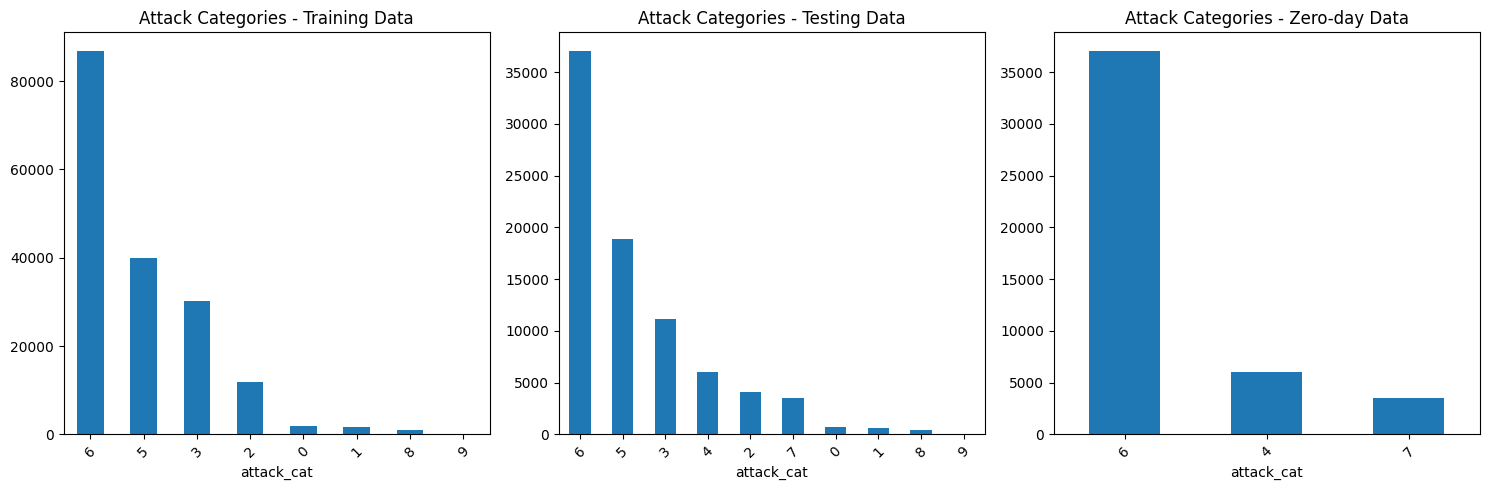


Check for Fuzzer and Reconnaissance in training data:
Fuzzers in training data: False
Reconnaissance in training data: False


In [31]:
# View attack_cat distribution in each dataset
print("attack_cat distribution in training data:")
print(X_train['attack_cat'].value_counts())
print("\n")

print("attack_cat distribution in testing data:")
print(X_test['attack_cat'].value_counts())
print("\n")

print("attack_cat distribution in zero-day data:")
print(zero_day_data['attack_cat'].value_counts())

# Visualization with bar plot
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
X_train['attack_cat'].value_counts().plot(kind='bar')
plt.title('Attack Categories - Training Data')
plt.xticks(rotation=45)

plt.subplot(1,3,2)
X_test['attack_cat'].value_counts().plot(kind='bar')
plt.title('Attack Categories - Testing Data')
plt.xticks(rotation=45)

plt.subplot(1,3,3)
zero_day_data['attack_cat'].value_counts().plot(kind='bar')
plt.title('Attack Categories - Zero-day Data')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Check if Fuzzer and Reconnaissance have been removed from training data
print("\nCheck for Fuzzer and Reconnaissance in training data:")
print(f"Fuzzers in training data: {'Fuzzers' in X_train['attack_cat'].values}")
print(f"Reconnaissance in training data: {'Reconnaissance' in X_train['attack_cat'].values}")

In [32]:
# At the start of training, add:
sample_size = int(len(X_train) * 0.5)  # Exactly 50% of the data
indices = np.random.choice(len(X_train), sample_size, replace=False)
X_train_sample = X_train.iloc[indices].values
y_train_sample = y_train[indices]

# Add print to see sample size
print(f"Using {sample_size} samples from {len(X_train)} original data (50.0%)")

Using 86708 samples from 173416 original data (50.0%)


# Training model and evaluate

In [33]:
# Train and evaluate models with different hyperparameter schemes
timestamp = time.strftime("%Y%m%d-%H%M%S")
results_df, best_agent, best_metrics = specific_scheme_search_qlearning(
    X_train, y_train, X_test, y_test, zero_day_data, zero_day_labels
)

Evaluating 5 specific hyperparameter schemes for Q-Learning
Using 86708 samples from 173416 original data (50.0%)


Evaluating Schemes:   0%|          | 0/5 [00:00<?, ?it/s]


Scheme 1/5: {'alpha': 0.01, 'gamma': 0.8, 'epsilon': 1.0, 'epsilon_decay': 0.8, 'epsilon_min': 0.05}
Performing clustering for state representation...
Cluster distribution: Min=117, Max=14180, Avg=2890.3
Using a pre-trained clusterer...
Using a pre-trained clusterer...


Episode 5/30, Reward: 49938.00, Train Accuracy: 0.7880, Epsilon: 0.3277
  Test Accuracy: 0.9418, Test Detection Rate: 0.9030, Test F1: 0.9447
  Zero-day Accuracy: 0.9187, Zero-day Detection Rate: 0.6456, Zero-day F1: 0.7653


Episode 10/30, Reward: 73124.00, Train Accuracy: 0.9217, Epsilon: 0.1074
  Test Accuracy: 0.9418, Test Detection Rate: 0.9030, Test F1: 0.9447
  Zero-day Accuracy: 0.9187, Zero-day Detection Rate: 0.6456, Zero-day F1: 0.7653


Episode 15/30, Reward: 80122.00, Train Accuracy: 0.9620, Epsilon: 0.0500
  Test Accuracy: 0.9418, Test Detection Rate: 0.9030, Test F1: 0.9447
  Zero-day Accuracy: 0.9187, Zero-day Detection Rate: 0.6456, Zero-day F1: 0.7653


Episode 20/30, Reward: 80228.00, Train Accuracy: 0.9626, Epsilon: 0.0500
  Test Accuracy: 0.9418, Test Detection Rate: 0.9030, Test F1: 0.9447
  Zero-day Accuracy: 0.9187, Zero-day Detection Rate: 0.6456, Zero-day F1: 0.7653


Episode 25/30, Reward: 80160.00, Train Accuracy: 0.9622, Epsilon: 0.0500
  Test Accuracy: 0.9418, Test Detection Rate: 0.9030, Test F1: 0.9447
  Zero-day Accuracy: 0.9187, Zero-day Detection Rate: 0.6456, Zero-day F1: 0.7653


Training Q-Learning Agent: 100%|██████████| 30/30 [00:35<00:00,  1.19s/it]

Episode 30/30, Reward: 80286.00, Train Accuracy: 0.9630, Epsilon: 0.0500
  Test Accuracy: 0.9418, Test Detection Rate: 0.9030, Test F1: 0.9447
  Zero-day Accuracy: 0.9187, Zero-day Detection Rate: 0.6456, Zero-day F1: 0.7653
Using agent with the best detection rate: 0.9030



Evaluating Schemes:  20%|██        | 1/5 [00:36<02:27, 36.81s/it]

Best model updated! Zero-day detection rate: 0.6456

Scheme 2/5: {'alpha': 0.1, 'gamma': 0.95, 'epsilon': 1.0, 'epsilon_decay': 0.95, 'epsilon_min': 0.2}
Performing clustering for state representation...
Cluster distribution: Min=90, Max=7598, Avg=2890.3
Using a pre-trained clusterer...
Using a pre-trained clusterer...


Episode 5/30, Reward: 15606.00, Train Accuracy: 0.5900, Epsilon: 0.7738
  Test Accuracy: 0.9259, Test Detection Rate: 0.8699, Test F1: 0.9282
  Zero-day Accuracy: 0.8977, Zero-day Detection Rate: 0.5224, Zero-day F1: 0.6770


Episode 10/30, Reward: 31286.00, Train Accuracy: 0.6804, Epsilon: 0.5987
  Test Accuracy: 0.9259, Test Detection Rate: 0.8699, Test F1: 0.9282
  Zero-day Accuracy: 0.8977, Zero-day Detection Rate: 0.5224, Zero-day F1: 0.6770


Episode 15/30, Reward: 42740.00, Train Accuracy: 0.7465, Epsilon: 0.4633
  Test Accuracy: 0.9259, Test Detection Rate: 0.8699, Test F1: 0.9282
  Zero-day Accuracy: 0.8977, Zero-day Detection Rate: 0.5224, Zero-day F1: 0.6770


Episode 20/30, Reward: 52230.00, Train Accuracy: 0.8012, Epsilon: 0.3585
  Test Accuracy: 0.9259, Test Detection Rate: 0.8699, Test F1: 0.9282
  Zero-day Accuracy: 0.8977, Zero-day Detection Rate: 0.5224, Zero-day F1: 0.6770


Episode 25/30, Reward: 59252.00, Train Accuracy: 0.8417, Epsilon: 0.2774
  Test Accuracy: 0.9259, Test Detection Rate: 0.8699, Test F1: 0.9282
  Zero-day Accuracy: 0.8977, Zero-day Detection Rate: 0.5224, Zero-day F1: 0.6770


Training Q-Learning Agent: 100%|██████████| 30/30 [00:35<00:00,  1.19s/it]

Episode 30/30, Reward: 64650.00, Train Accuracy: 0.8728, Epsilon: 0.2146
  Test Accuracy: 0.9259, Test Detection Rate: 0.8699, Test F1: 0.9282
  Zero-day Accuracy: 0.8977, Zero-day Detection Rate: 0.5224, Zero-day F1: 0.6770
Using agent with the best detection rate: 0.8699



Evaluating Schemes:  40%|████      | 2/5 [01:13<01:50, 36.68s/it]


Scheme 3/5: {'alpha': 0.03, 'gamma': 0.99, 'epsilon': 0.8, 'epsilon_decay': 0.99, 'epsilon_min': 0.3}
Performing clustering for state representation...
Cluster distribution: Min=358, Max=11938, Avg=2890.3
Using a pre-trained clusterer...
Using a pre-trained clusterer...


Episode 5/30, Reward: 19380.00, Train Accuracy: 0.6118, Epsilon: 0.7608
  Test Accuracy: 0.9235, Test Detection Rate: 0.8661, Test F1: 0.9257
  Zero-day Accuracy: 0.8928, Zero-day Detection Rate: 0.5016, Zero-day F1: 0.6577


Episode 10/30, Reward: 22566.00, Train Accuracy: 0.6301, Epsilon: 0.7235
  Test Accuracy: 0.8730, Test Detection Rate: 0.7742, Test F1: 0.8703
  Zero-day Accuracy: 0.8924, Zero-day Detection Rate: 0.4987, Zero-day F1: 0.6555


Episode 15/30, Reward: 25744.00, Train Accuracy: 0.6485, Epsilon: 0.6880
  Test Accuracy: 0.8730, Test Detection Rate: 0.7742, Test F1: 0.8703
  Zero-day Accuracy: 0.8924, Zero-day Detection Rate: 0.4987, Zero-day F1: 0.6555


Episode 20/30, Reward: 28214.00, Train Accuracy: 0.6627, Epsilon: 0.6543
  Test Accuracy: 0.9235, Test Detection Rate: 0.8661, Test F1: 0.9257
  Zero-day Accuracy: 0.8928, Zero-day Detection Rate: 0.5016, Zero-day F1: 0.6577


Episode 25/30, Reward: 30914.00, Train Accuracy: 0.6783, Epsilon: 0.6223
  Test Accuracy: 0.8730, Test Detection Rate: 0.7742, Test F1: 0.8703
  Zero-day Accuracy: 0.8924, Zero-day Detection Rate: 0.4987, Zero-day F1: 0.6555


Training Q-Learning Agent: 100%|██████████| 30/30 [00:36<00:00,  1.21s/it]

Episode 30/30, Reward: 33648.00, Train Accuracy: 0.6940, Epsilon: 0.5918
  Test Accuracy: 0.8730, Test Detection Rate: 0.7742, Test F1: 0.8703
  Zero-day Accuracy: 0.8924, Zero-day Detection Rate: 0.4987, Zero-day F1: 0.6555
Using agent with the best detection rate: 0.8661



Evaluating Schemes:  60%|██████    | 3/5 [01:50<01:13, 36.91s/it]


Scheme 4/5: {'alpha': 0.5, 'gamma': 0.9, 'epsilon': 0.7, 'epsilon_decay': 0.9, 'epsilon_min': 0.1}
Performing clustering for state representation...
Cluster distribution: Min=42, Max=10985, Avg=2890.3
Using a pre-trained clusterer...
Using a pre-trained clusterer...


Episode 5/30, Reward: 45366.00, Train Accuracy: 0.7616, Epsilon: 0.4133
  Test Accuracy: 0.9193, Test Detection Rate: 0.8679, Test F1: 0.9221
  Zero-day Accuracy: 0.8866, Zero-day Detection Rate: 0.5162, Zero-day F1: 0.6514


Episode 10/30, Reward: 60186.00, Train Accuracy: 0.8471, Epsilon: 0.2441
  Test Accuracy: 0.9181, Test Detection Rate: 0.8727, Test F1: 0.9215
  Zero-day Accuracy: 0.8826, Zero-day Detection Rate: 0.5296, Zero-day F1: 0.6493


Episode 15/30, Reward: 70100.00, Train Accuracy: 0.9042, Epsilon: 0.1441
  Test Accuracy: 0.8472, Test Detection Rate: 0.7369, Test F1: 0.8415
  Zero-day Accuracy: 0.8681, Zero-day Detection Rate: 0.4261, Zero-day F1: 0.5701


Episode 20/30, Reward: 74836.00, Train Accuracy: 0.9315, Epsilon: 0.1000
  Test Accuracy: 0.8472, Test Detection Rate: 0.7369, Test F1: 0.8415
  Zero-day Accuracy: 0.8681, Zero-day Detection Rate: 0.4261, Zero-day F1: 0.5701


Episode 25/30, Reward: 75170.00, Train Accuracy: 0.9335, Epsilon: 0.1000
  Test Accuracy: 0.8472, Test Detection Rate: 0.7369, Test F1: 0.8415
  Zero-day Accuracy: 0.8681, Zero-day Detection Rate: 0.4261, Zero-day F1: 0.5701


Training Q-Learning Agent: 100%|██████████| 30/30 [00:35<00:00,  1.19s/it]

Episode 30/30, Reward: 75106.00, Train Accuracy: 0.9331, Epsilon: 0.1000
  Test Accuracy: 0.8472, Test Detection Rate: 0.7369, Test F1: 0.8415
  Zero-day Accuracy: 0.8681, Zero-day Detection Rate: 0.4261, Zero-day F1: 0.5701
Using agent with the best detection rate: 0.8727



Evaluating Schemes:  80%|████████  | 4/5 [02:27<00:36, 36.78s/it]


Scheme 5/5: {'alpha': 0.2, 'gamma': 0.7, 'epsilon': 0.9, 'epsilon_decay': 0.85, 'epsilon_min': 0.01}
Performing clustering for state representation...
Cluster distribution: Min=265, Max=6707, Avg=2890.3
Using a pre-trained clusterer...
Using a pre-trained clusterer...


Episode 5/30, Reward: 43972.00, Train Accuracy: 0.7536, Epsilon: 0.3993
  Test Accuracy: 0.9235, Test Detection Rate: 0.8801, Test F1: 0.9268
  Zero-day Accuracy: 0.8928, Zero-day Detection Rate: 0.5680, Zero-day F1: 0.6850


Episode 10/30, Reward: 65368.00, Train Accuracy: 0.8769, Epsilon: 0.1772
  Test Accuracy: 0.9235, Test Detection Rate: 0.8801, Test F1: 0.9268
  Zero-day Accuracy: 0.8928, Zero-day Detection Rate: 0.5680, Zero-day F1: 0.6850


Episode 15/30, Reward: 75234.00, Train Accuracy: 0.9338, Epsilon: 0.0786
  Test Accuracy: 0.9235, Test Detection Rate: 0.8801, Test F1: 0.9268
  Zero-day Accuracy: 0.8928, Zero-day Detection Rate: 0.5680, Zero-day F1: 0.6850


Episode 20/30, Reward: 79334.00, Train Accuracy: 0.9575, Epsilon: 0.0349
  Test Accuracy: 0.9235, Test Detection Rate: 0.8801, Test F1: 0.9268
  Zero-day Accuracy: 0.8928, Zero-day Detection Rate: 0.5680, Zero-day F1: 0.6850


Episode 25/30, Reward: 81364.00, Train Accuracy: 0.9692, Epsilon: 0.0155
  Test Accuracy: 0.9235, Test Detection Rate: 0.8801, Test F1: 0.9268
  Zero-day Accuracy: 0.8928, Zero-day Detection Rate: 0.5680, Zero-day F1: 0.6850


Training Q-Learning Agent: 100%|██████████| 30/30 [00:35<00:00,  1.19s/it]

Episode 30/30, Reward: 82046.00, Train Accuracy: 0.9731, Epsilon: 0.0100
  Test Accuracy: 0.9235, Test Detection Rate: 0.8801, Test F1: 0.9268
  Zero-day Accuracy: 0.8928, Zero-day Detection Rate: 0.5680, Zero-day F1: 0.6850
Using agent with the best detection rate: 0.8801



Evaluating Schemes: 100%|██████████| 5/5 [03:04<00:00, 36.83s/it]


SCHEME EVALUATION RESULTS
Total schemes successfully evaluated: 5
Best parameters: {'alpha': 0.01, 'gamma': 0.8, 'epsilon': 1.0, 'epsilon_decay': 0.8, 'epsilon_min': 0.05}
Best zero-day detection rate: 0.6456

Scheme ranking based on zero-day detection rate:
1. Scheme 1 - Zero-day Recall: 0.6456, F1: 0.7653
2. Scheme 5 - Zero-day Recall: 0.5680, F1: 0.6850
3. Scheme 4 - Zero-day Recall: 0.5296, F1: 0.6493
4. Scheme 2 - Zero-day Recall: 0.5224, F1: 0.6770
5. Scheme 3 - Zero-day Recall: 0.5016, F1: 0.6577

MEMORY FOOTPRINT COMPARISON
  scheme  training_time_seconds  peak_ram_mb  qtable_size_mb  avg_inference_time_ms  samples_per_second  alpha  gamma  epsilon  epsilon_decay  epsilon_min
Scheme 1              36.028544  1247.386719        0.000458               0.001002       997931.001665   0.01   0.80      1.0           0.80         0.05
Scheme 2              35.808809  1249.316406        0.000458               0.002119       471853.301834   0.10   0.95      1.0           0.95         0

In [34]:
# Save results

results_df.to_pickle(f'qlearning_scheme_evaluation_{timestamp}.pkl')


In [35]:
# Display text comparison of schemes
print_scheme_comparison_qlearning(results_df)

# Save all results to text file
save_results_to_text_qlearning(results_df, f'qlearning_evaluation_results_{timestamp}.txt')



---------------------PERFORMANCE COMPARISON BETWEEN SCHEMES---------------------

-----------------------------------TEST DATA------------------------------------
Scheme     | Accuracy   | Precision  | Recall     | F1 Score   | FPR        | AUC       
--------------------------------------------------------------------------------
Scheme 1    | 0.9418     | 0.9903     | 0.9030     | 0.9447     | 0.0108     | 0.9825    
Scheme 2    | 0.9259     | 0.9950     | 0.8699     | 0.9282     | 0.0054     | 0.9690    
Scheme 3    | 0.9235     | 0.9943     | 0.8661     | 0.9257     | 0.0061     | 0.9727    
Scheme 4    | 0.9181     | 0.9760     | 0.8727     | 0.9215     | 0.0262     | 0.9577    
Scheme 5    | 0.9235     | 0.9788     | 0.8801     | 0.9268     | 0.0233     | 0.9666    

---------------------------------ZERO-DAY DATA----------------------------------
Scheme     | Accuracy   | Precision  | Recall     | F1 Score   | FPR        | AUC       
---------------------------------------------

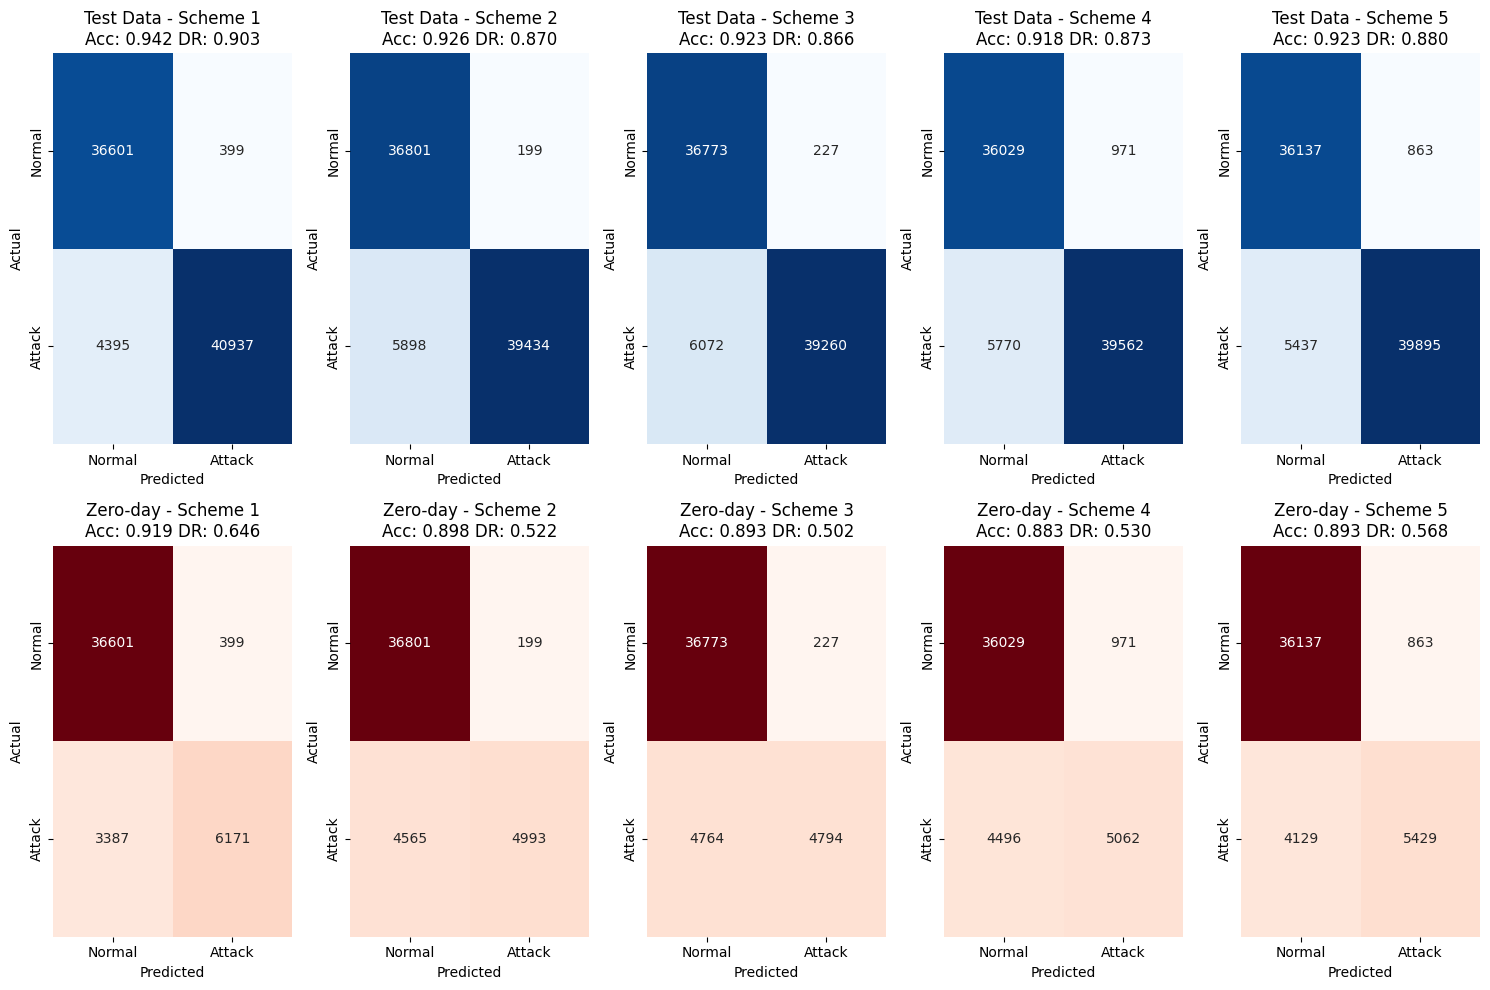

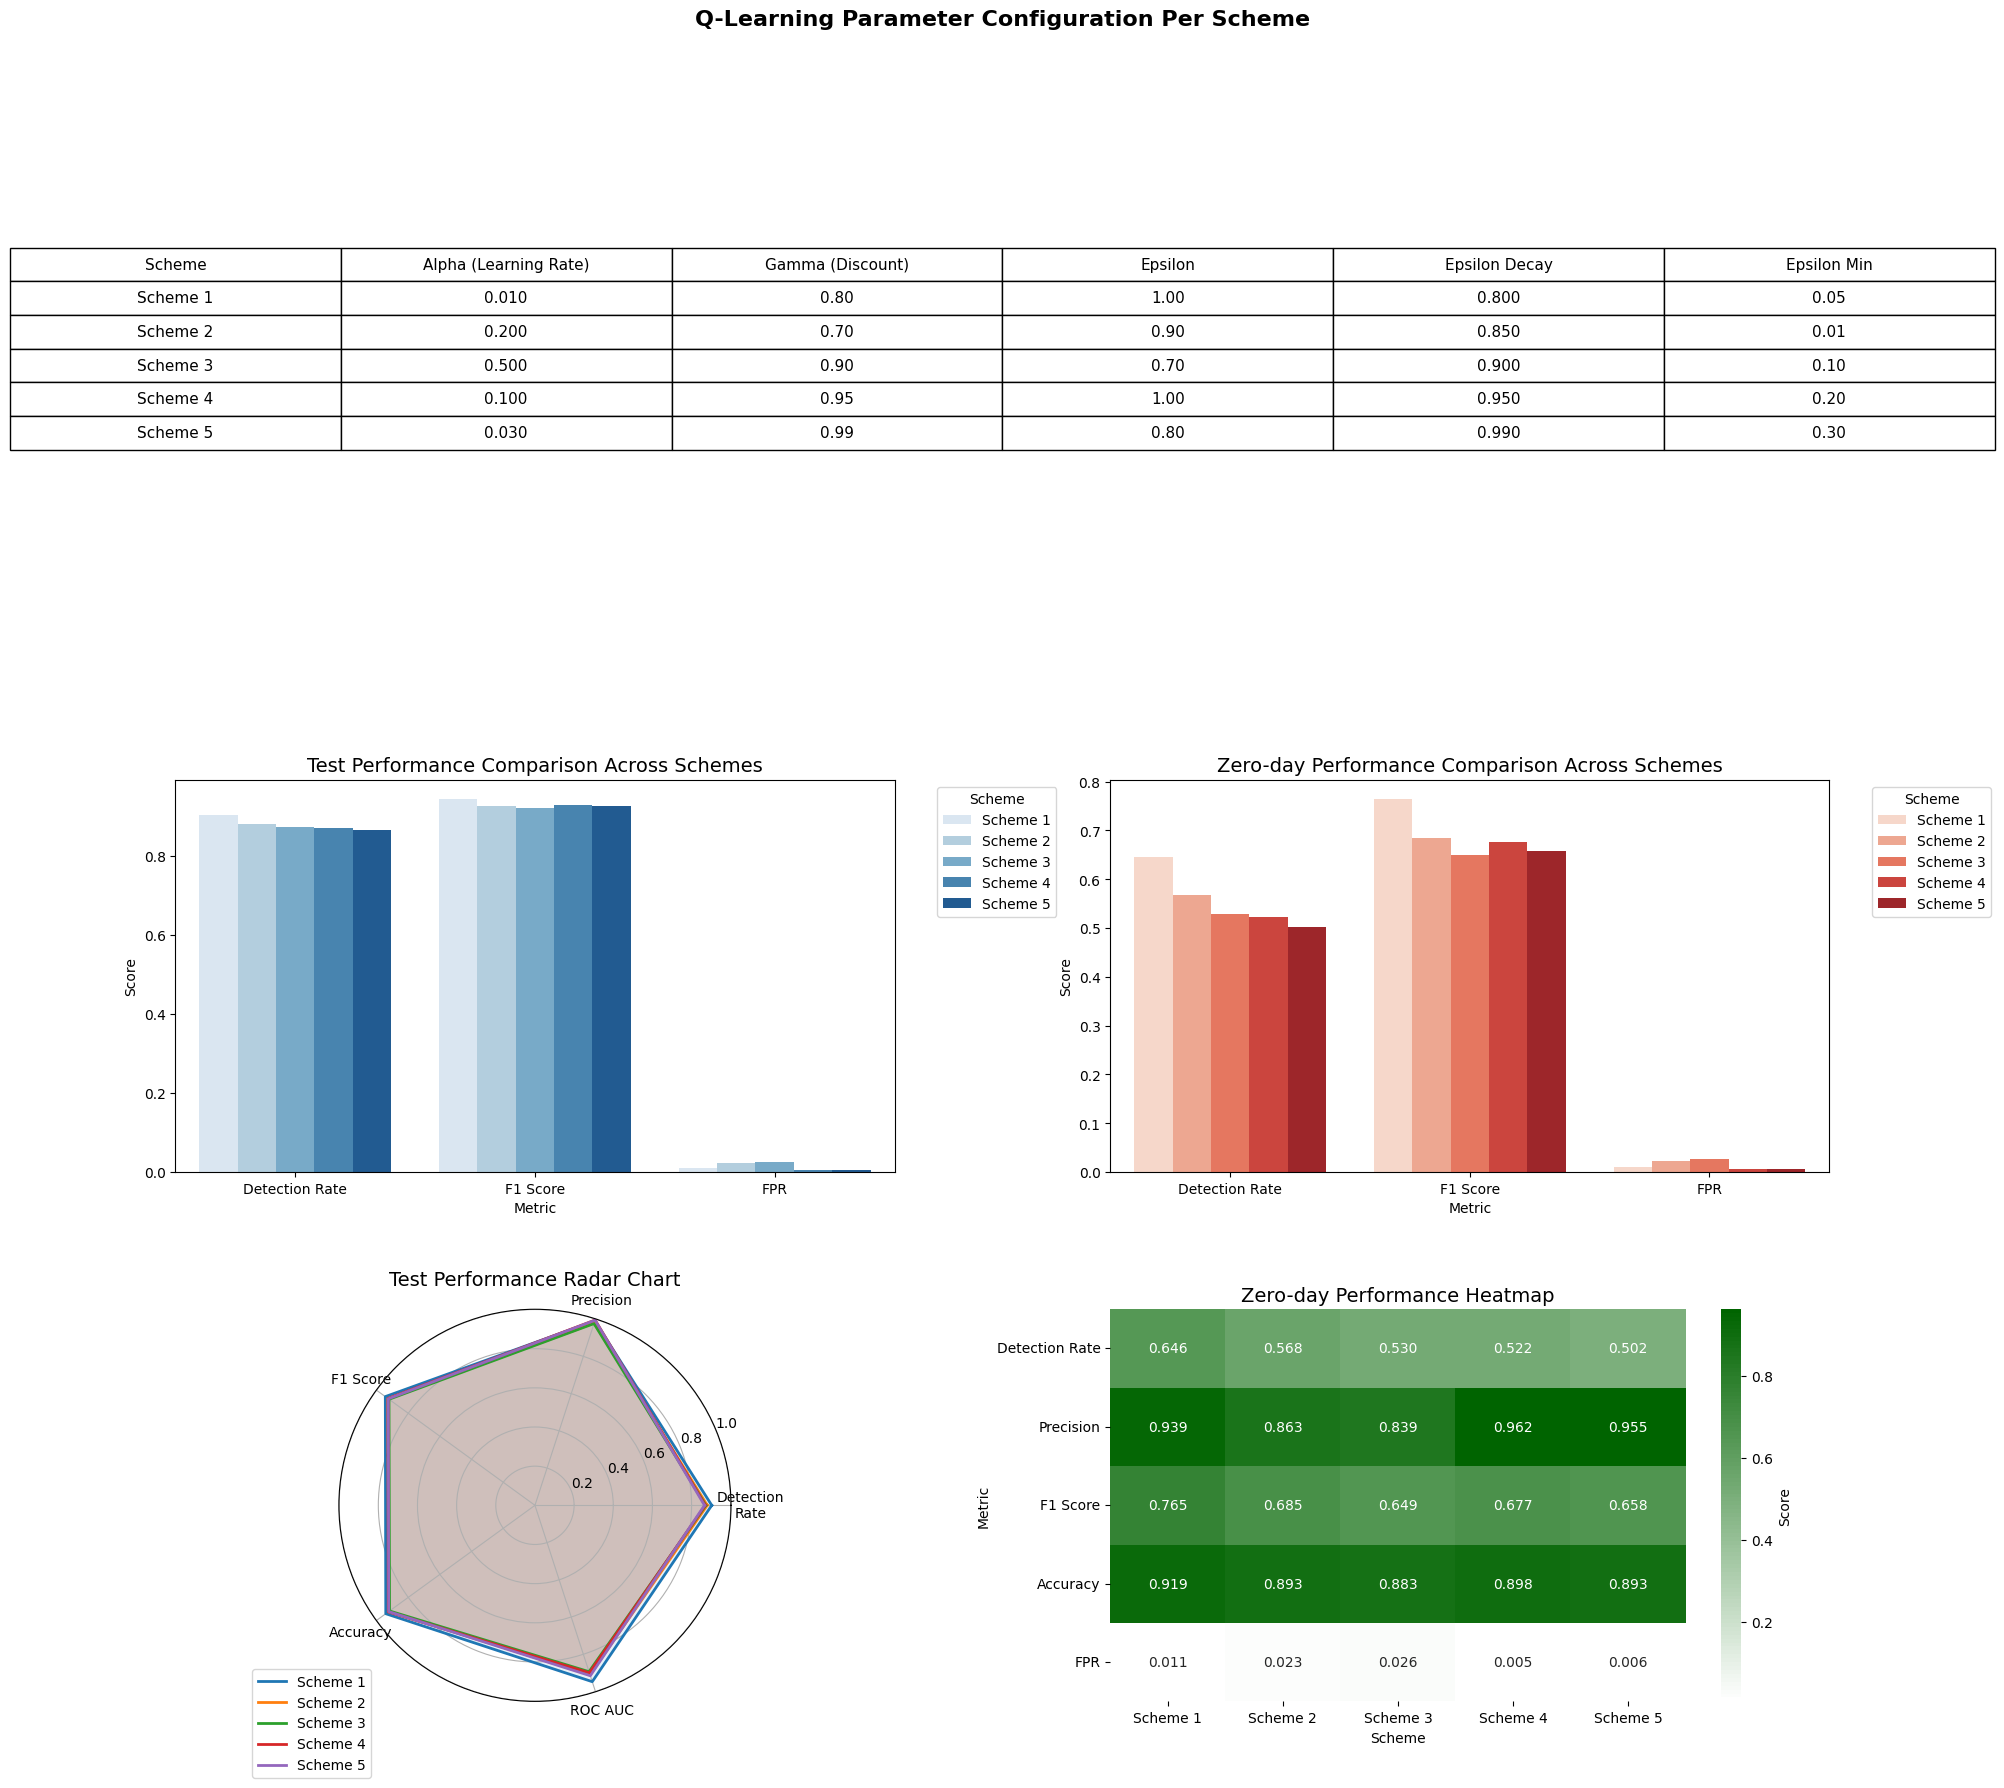

In [36]:
# Create visualizations
plot_confusion_matrices_qlearning(results_df)
visualize_model_comparison_qlearning(results_df)


In [37]:
# Save best model
if best_agent is not None:
    best_model_data = {
        'q_table': best_agent.q_table,
        'policy': best_agent.policy,
        'hyperparameters': results_df.iloc[results_df['zero_day_recall'].idxmax()].to_dict(),
        'timestamp': timestamp
    }
    joblib.dump(best_model_data, f'best_qlearning_model_{timestamp}.pkl')
    print(f"Best model saved as 'best_qlearning_model_{timestamp}.pkl'")

print(f"\nEvaluation process completed!")
print(f"- Text results saved to: qlearning_evaluation_results_{timestamp}.txt")
print(f"- Results DataFrame saved to: qlearning_scheme_evaluation_{timestamp}.pkl")
print(f"- Visualizations have been displayed and saved")

Best model saved as 'best_qlearning_model_20250619-084705.pkl'

Evaluation process completed!
- Text results saved to: qlearning_evaluation_results_20250619-084705.txt
- Results DataFrame saved to: qlearning_scheme_evaluation_20250619-084705.pkl
- Visualizations have been displayed and saved


Loading Q-Learning evaluation results...


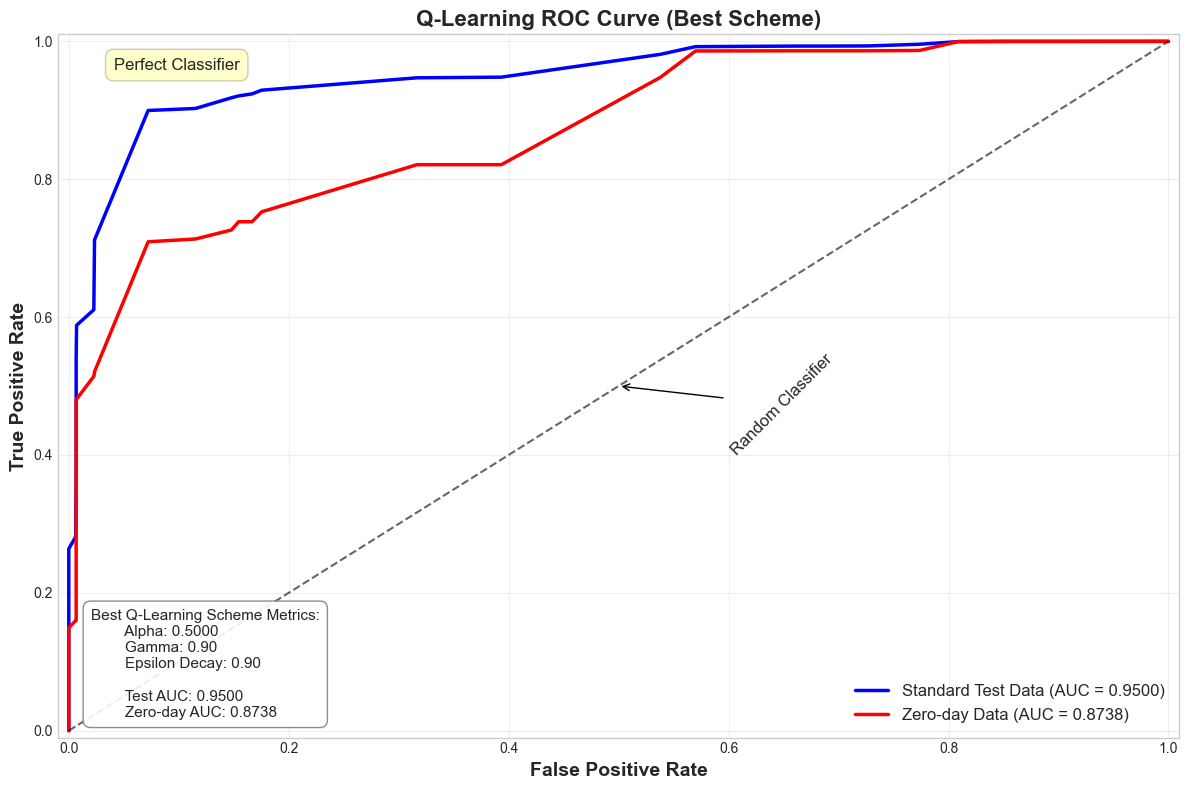

ROC curve has been saved to qlearning_roc_curve_comparison.png
Best scheme: Scheme 4
Test AUC: 0.9500
Zero-day AUC: 0.8738


In [38]:
# Replace with your actual results file path from Q-Learning evaluation
results_file = 'qlearning_scheme_evaluation_20250618-084650.pkl'
metrics = plot_qlearning_roc_curve(results_file)

if metrics:
    print(f"Best scheme: Scheme {metrics['best_scheme']}")
    print(f"Test AUC: {metrics['test_auc']:.4f}")
    print(f"Zero-day AUC: {metrics['zero_day_auc']:.4f}")


Creating overfitting visualization...


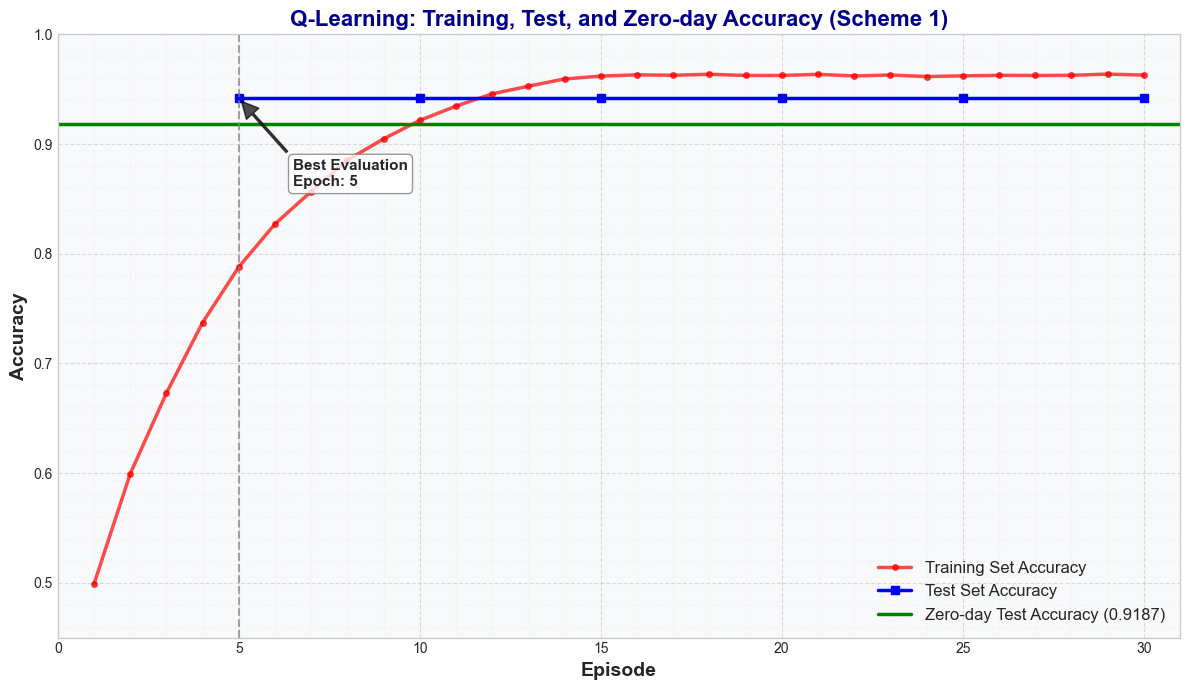

Visualization has been created and saved as 'qlearning_training_vs_test_vs_zeroday_accuracy.png'


In [39]:
# Create training vs test accuracy visualization
print("\nCreating overfitting visualization...")
visualize_training_vs_test_accuracy(f'qlearning_scheme_evaluation_{timestamp}.pkl')

print("Visualization has been created and saved as 'qlearning_training_vs_test_vs_zeroday_accuracy.png'")

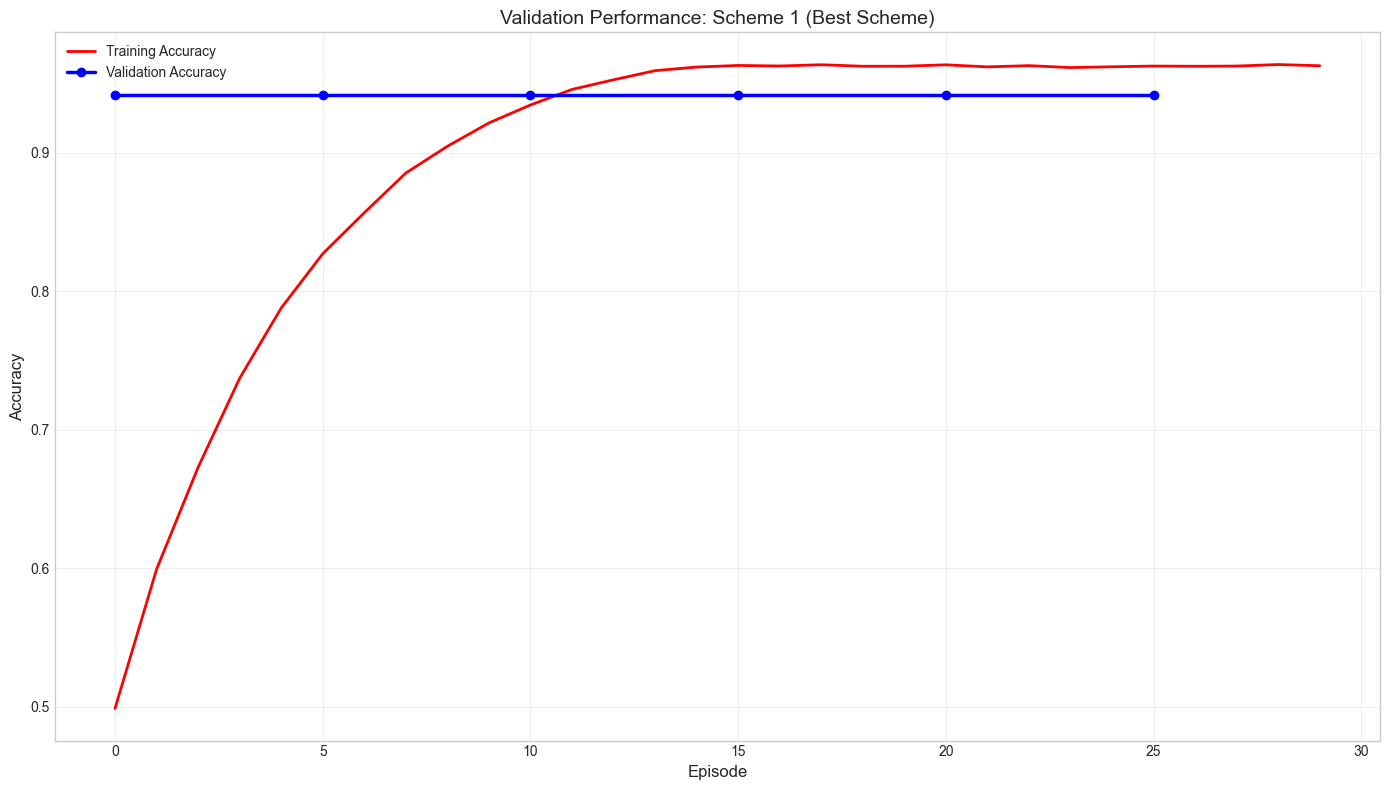

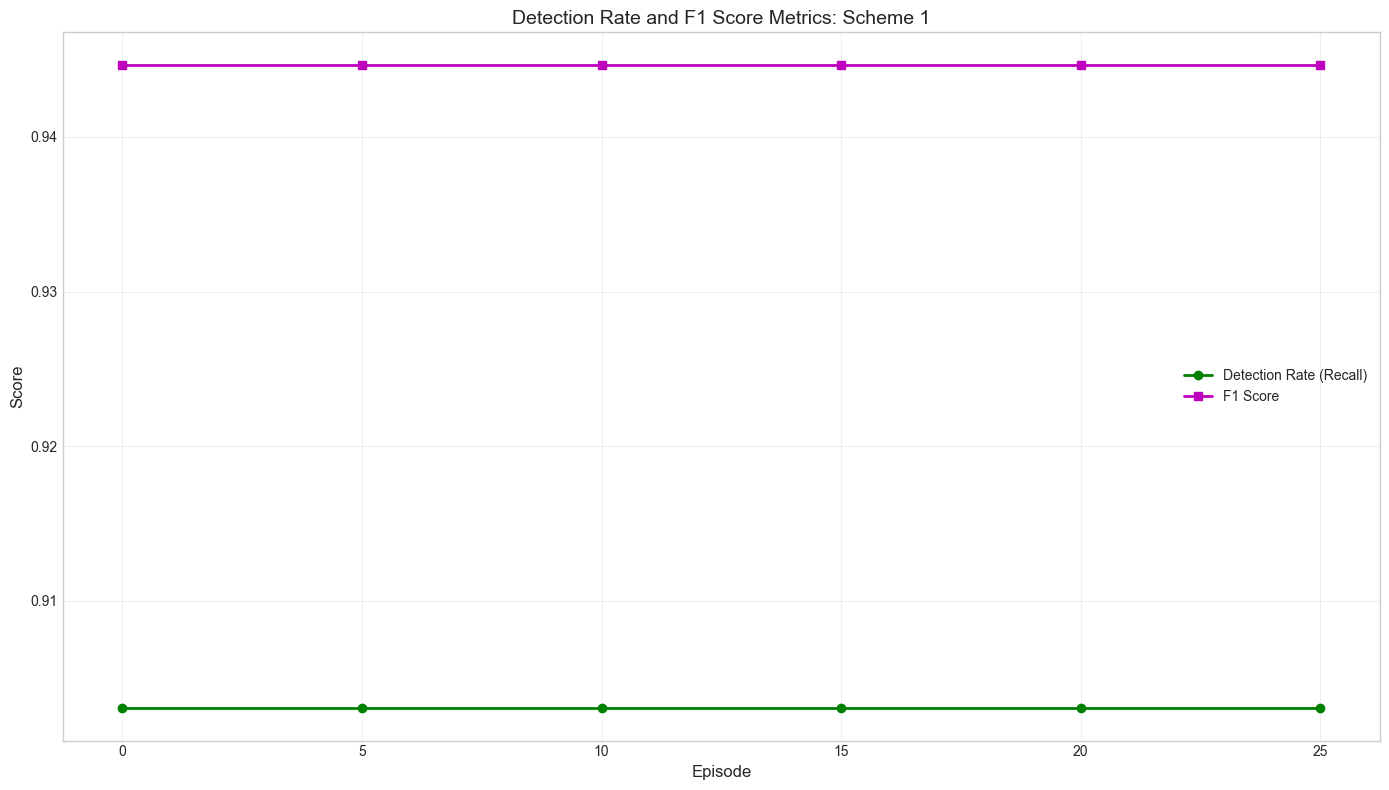

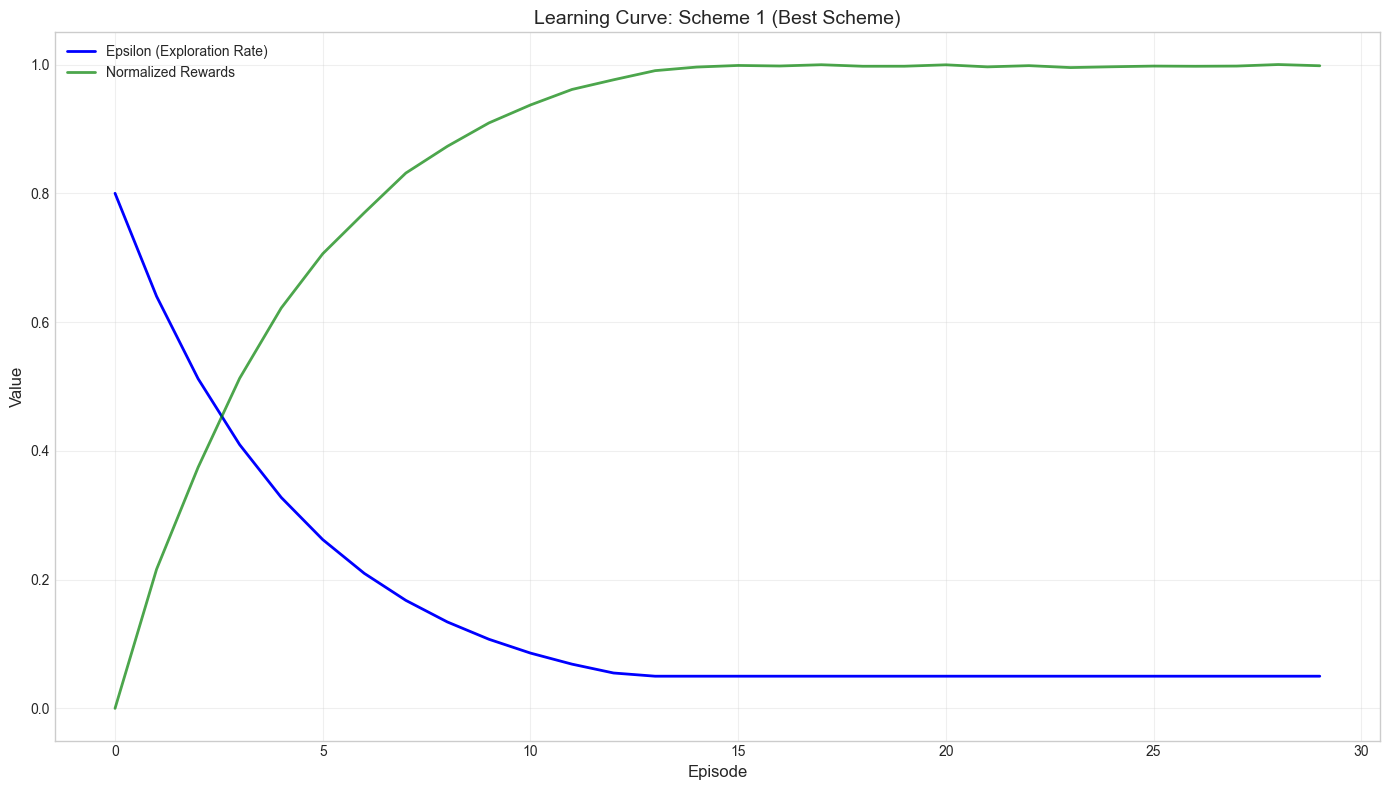

In [41]:
# Visualisasi validasi untuk skema terbaik
visualize_validation_performance(f'qlearning_scheme_evaluation_{timestamp}.pkl')

# RANDOM FOREST AND SVM

CORRECTED MACHINE LEARNING MODELS (RANDOM FOREST & SVM) EVALUATION
Loading preprocessed data...
Data loaded - Training: (173416, 20), Testing: (82332, 20), Zero-day: (46558, 20)

Training data attack categories (should NOT contain Fuzzers & Reconnaissance):
attack_cat
6    86708
5    39900
3    30250
2    11829
0     1961
1     1707
8      955
9      106
Name: count, dtype: int64

Test data attack categories (should contain ALL categories):
attack_cat
6    37000
5    18871
3    11132
4     6062
2     4089
7     3496
0      677
1      583
8      378
9       44
Name: count, dtype: int64

Zero-day data attack categories (should contain ONLY Fuzzers & Reconnaissance + Normal):
attack_cat
6    37000
4     6062
7     3496
Name: count, dtype: int64

Verification - Zero-day categories in training data:
Fuzzers in training data: False
Reconnaissance in training data: False

TRAINING RANDOM FOREST
Using 86708 samples for Random Forest (50.0% of data)
Performing hyperparameter tuning for Random F

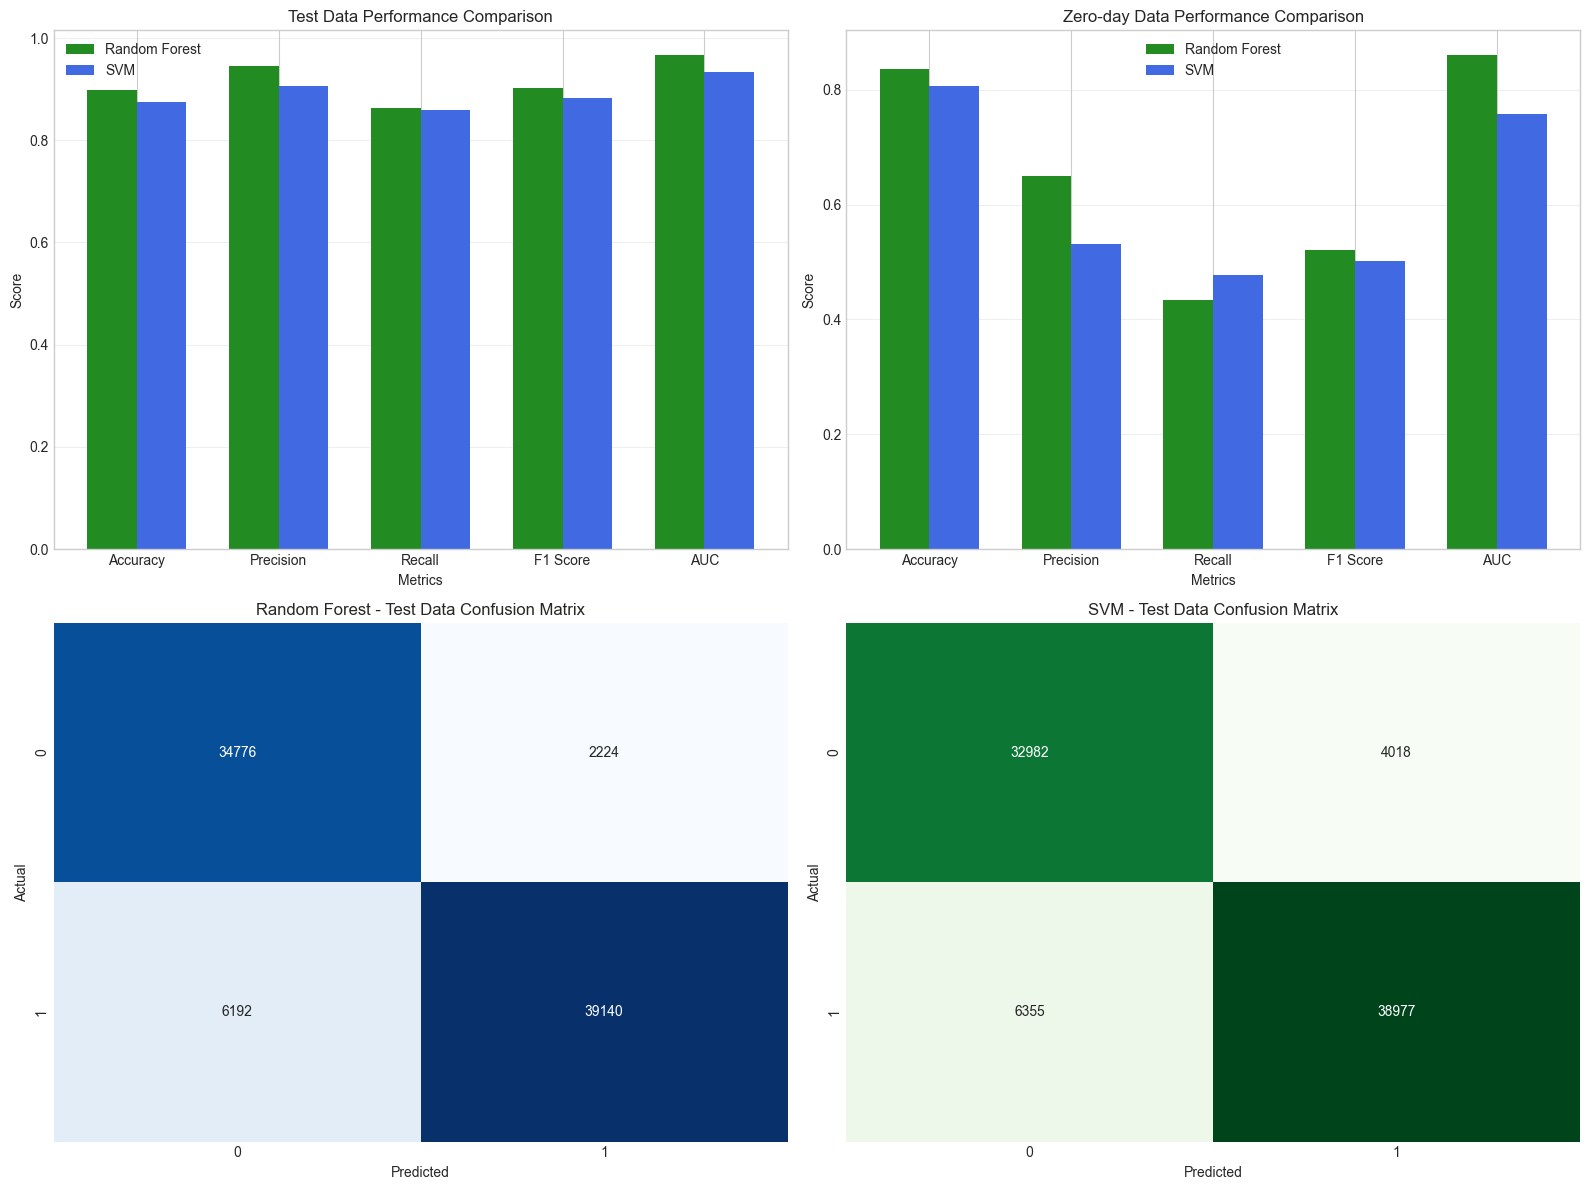

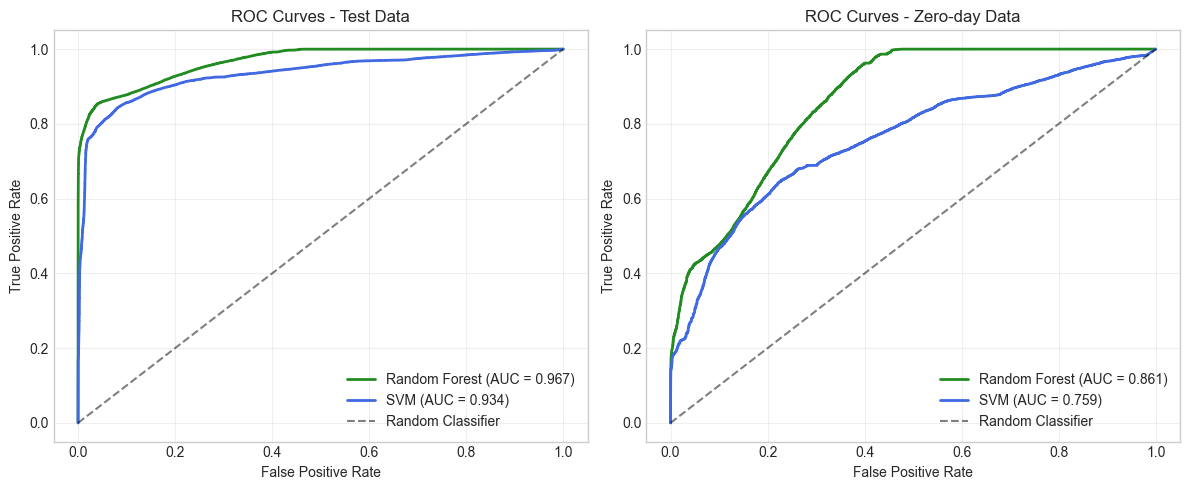

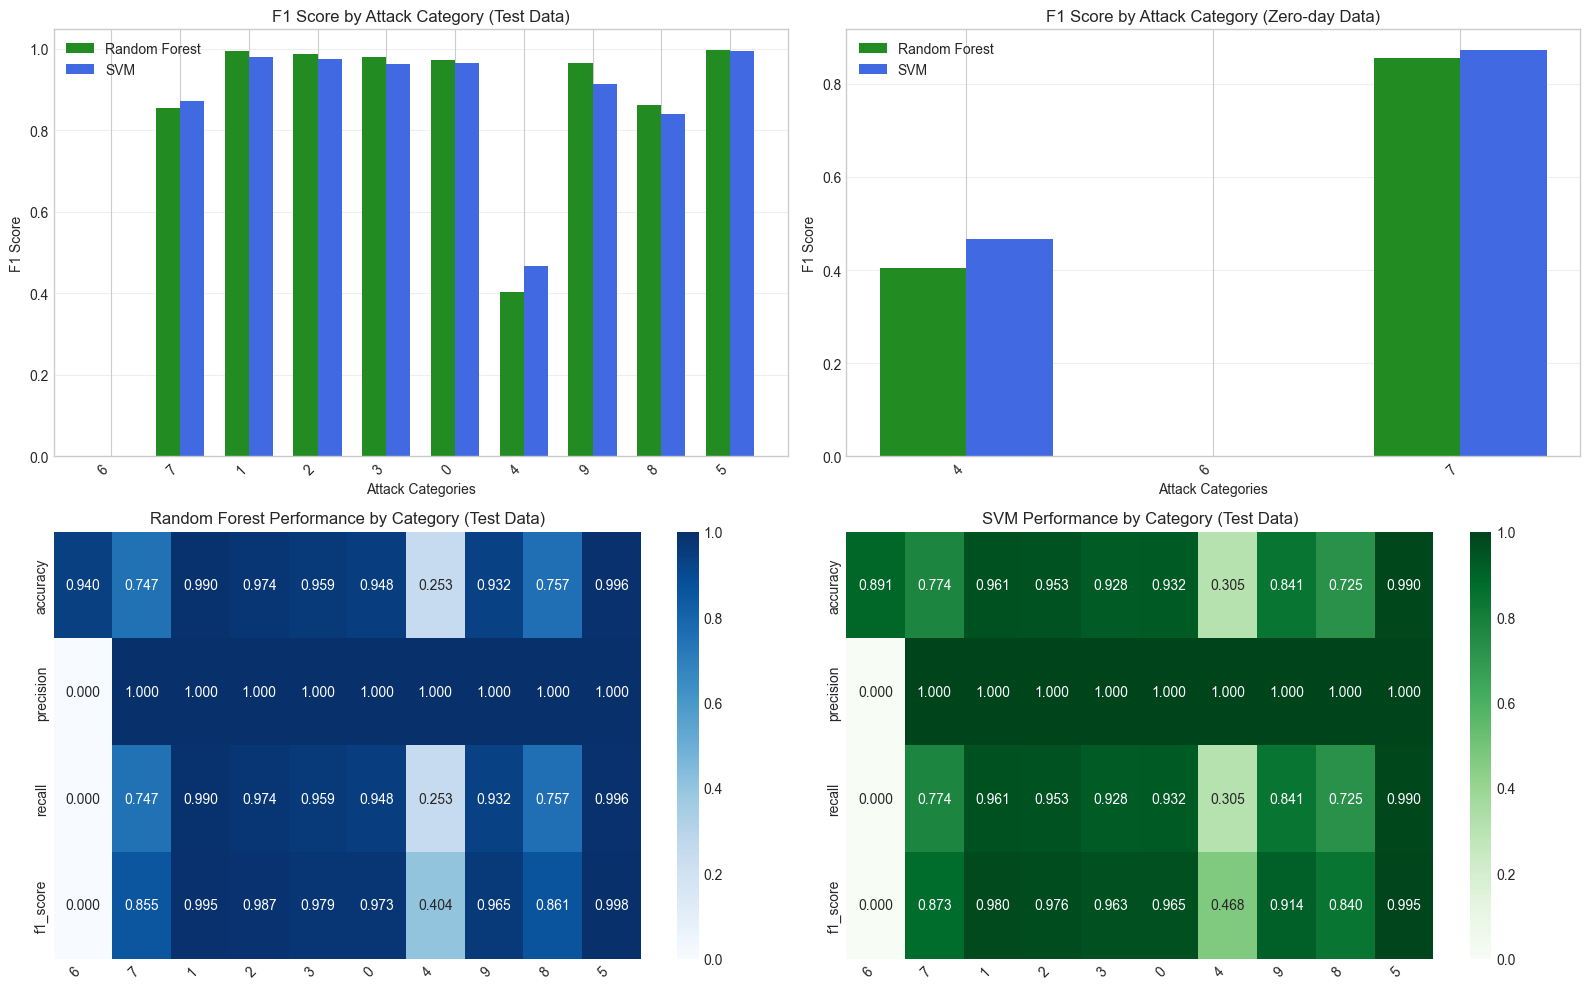

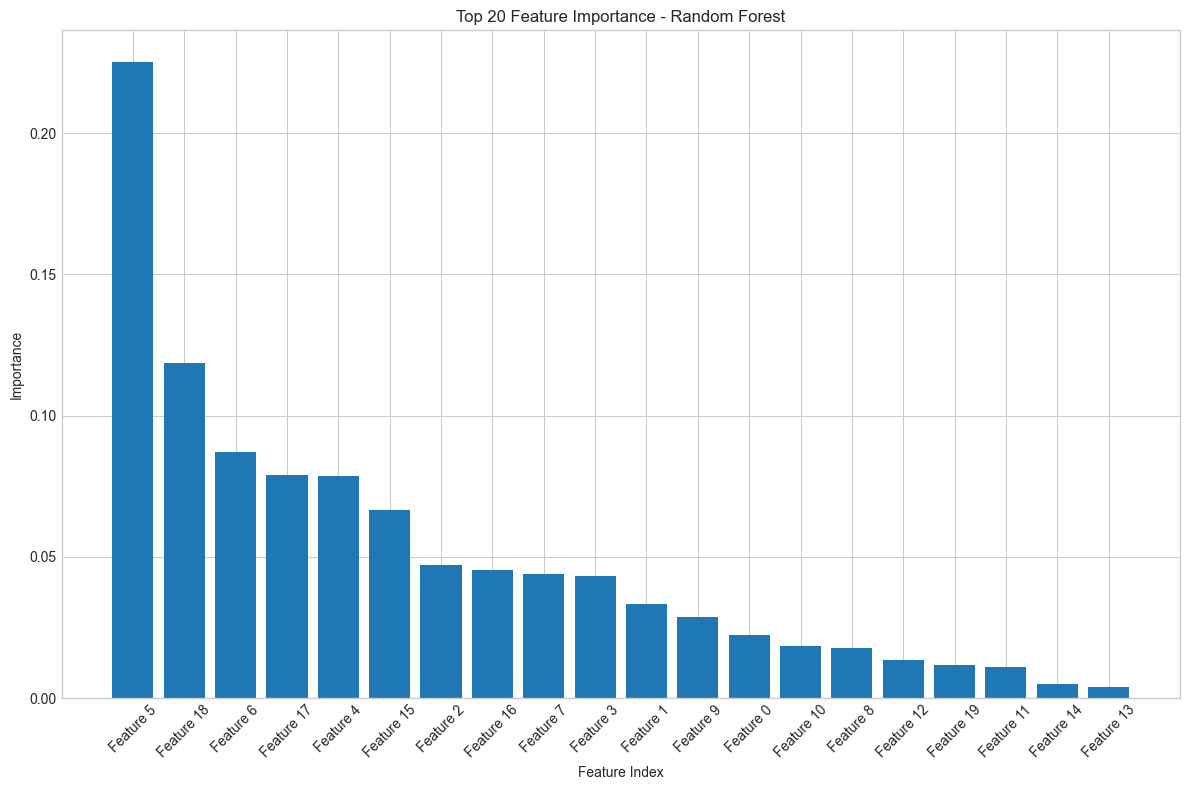


Top 20 Most Important Features (Random Forest):
1. Feature 5: 0.2251
2. Feature 18: 0.1188
3. Feature 6: 0.0870
4. Feature 17: 0.0790
5. Feature 4: 0.0785
6. Feature 15: 0.0667
7. Feature 2: 0.0472
8. Feature 16: 0.0452
9. Feature 7: 0.0438
10. Feature 3: 0.0431
11. Feature 1: 0.0332
12. Feature 9: 0.0286
13. Feature 0: 0.0225
14. Feature 10: 0.0184
15. Feature 8: 0.0176
16. Feature 12: 0.0134
17. Feature 19: 0.0119
18. Feature 11: 0.0110
19. Feature 14: 0.0050
20. Feature 13: 0.0041
Results saved to: ml_models_results_20250619-085019.pkl
Enhanced results saved to: ml_models_enhanced_results_20250619-085019.pkl
Random Forest model saved to: random_forest_model_20250619-085019.pkl
SVM model saved to: svm_model_20250619-085019.pkl
Detailed results saved to: ml_models_detailed_results_20250619-085019.txt

Corrected ML Models evaluation completed!
Key corrections made:
1. Kept attack_cat column for analysis
2. Verified training data excludes Fuzzers & Reconnaissance
3. Verified test data 

In [42]:
# CORRECTED RANDOM FOREST AND SVM IMPLEMENTATION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, 
                            f1_score, precision_recall_curve, roc_curve, auc, 
                            precision_score, recall_score)
from sklearn.model_selection import GridSearchCV, cross_val_score
import joblib
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

def evaluate_ml_model(model, X_test, y_test, model_name="Model"):
    """
    Comprehensive evaluation function for ML models
    """
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Ensure confusion matrix is 2x2
    if conf_matrix.shape == (2, 2):
        tn, fp, fn, tp = conf_matrix.ravel()
    else:
        tn = np.sum((y_test == 0) & (y_pred == 0))
        fp = np.sum((y_test == 0) & (y_pred == 1))
        fn = np.sum((y_test == 1) & (y_pred == 0))
        tp = np.sum((y_test == 1) & (y_pred == 1))
    
    # Calculate additional metrics
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate (Detection Rate)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate (Specificity)
    
    # Calculate ROC curve and AUC if probabilities available
    roc_auc = 0.5
    fpr_curve, tpr_curve = None, None
    precision_curve, recall_curve = None, None
    
    if y_pred_proba is not None:
        fpr_curve, tpr_curve, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr_curve, tpr_curve)
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    
    # Classification report
    try:
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    except Exception:
        report = {}
    
    metrics = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'detection_rate': tpr,
        'false_positive_rate': fpr,
        'true_negative_rate': tnr,
        'roc_auc': roc_auc,
        'fpr_curve': fpr_curve,
        'tpr_curve': tpr_curve,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve,
        'classification_report': report,
        'predictions': y_pred,
        'true_labels': y_test
    }
    
    return metrics

def enhanced_evaluate_ml_model(model, X_test, y_test, attack_cat_test, model_name="Model"):
    """
    Enhanced evaluation that includes attack category breakdown
    """
    # Get basic metrics
    metrics = evaluate_ml_model(model, X_test, y_test, model_name)
    
    # Add attack category analysis if available
    if attack_cat_test is not None:
        y_pred = model.predict(X_test)
        
        # Create DataFrame for analysis
        analysis_df = pd.DataFrame({
            'true_label': y_test,
            'pred_label': y_pred,
            'attack_cat': attack_cat_test
        })
        
        # Performance per attack category
        category_performance = {}
        for category in analysis_df['attack_cat'].unique():
            cat_data = analysis_df[analysis_df['attack_cat'] == category]
            if len(cat_data) > 0:
                cat_accuracy = accuracy_score(cat_data['true_label'], cat_data['pred_label'])
                cat_precision = precision_score(cat_data['true_label'], cat_data['pred_label'], zero_division=0)
                cat_recall = recall_score(cat_data['true_label'], cat_data['pred_label'], zero_division=0)
                cat_f1 = f1_score(cat_data['true_label'], cat_data['pred_label'], zero_division=0)
                
                category_performance[category] = {
                    'accuracy': cat_accuracy,
                    'precision': cat_precision,
                    'recall': cat_recall,
                    'f1_score': cat_f1,
                    'samples': len(cat_data)
                }
        
        metrics['category_performance'] = category_performance
        
        # Zero-day specific analysis
        zero_day_categories = ['Fuzzers', 'Reconnaissance']
        zero_day_data = analysis_df[analysis_df['attack_cat'].isin(zero_day_categories)]
        
        if len(zero_day_data) > 0:
            zd_accuracy = accuracy_score(zero_day_data['true_label'], zero_day_data['pred_label'])
            zd_precision = precision_score(zero_day_data['true_label'], zero_day_data['pred_label'], zero_division=0)
            zd_recall = recall_score(zero_day_data['true_label'], zero_day_data['pred_label'], zero_division=0)
            zd_f1 = f1_score(zero_day_data['true_label'], zero_day_data['pred_label'], zero_division=0)
            
            metrics['zero_day_specific'] = {
                'accuracy': zd_accuracy,
                'precision': zd_precision,
                'recall': zd_recall,
                'f1_score': zd_f1,
                'samples': len(zero_day_data)
            }
    
    return metrics

def hyperparameter_tuning_rf(X_train, y_train, cv=3):
    """
    Hyperparameter tuning for Random Forest
    """
    print("Performing hyperparameter tuning for Random Forest...")
    
    # Define parameter grid - reduced for faster execution
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }
    
    # Initialize Random Forest
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring='f1',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    print(f"Best Random Forest parameters: {grid_search.best_params_}")
    print(f"Best Random Forest CV score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_, grid_search.best_params_

def hyperparameter_tuning_svm(X_train, y_train, cv=3):
    """
    Hyperparameter tuning for SVM - simplified for computational efficiency
    """
    print("Performing hyperparameter tuning for SVM...")
    
    # Define parameter grid - simplified
    param_grid = [
        {
            'C': [0.1, 1, 10],
            'kernel': ['linear']
        },
        {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto'],
            'kernel': ['rbf']
        }
    ]
    
    # Initialize SVM
    svm = SVC(random_state=42, probability=True)
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(
        estimator=svm,
        param_grid=param_grid,
        scoring='f1',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    print(f"Best SVM parameters: {grid_search.best_params_}")
    print(f"Best SVM CV score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_, grid_search.best_params_

def train_and_evaluate_ml_models(X_train, y_train, X_test, y_test, X_zero_day, y_zero_day):
    """
    Train and evaluate Random Forest and SVM models
    """
    results = {}
    models = {}
    
    # Random Forest
    print("\n" + "="*60)
    print("TRAINING RANDOM FOREST")
    print("="*60)
    
    # Gunakan hanya 50% data, sama seperti Q-Learning
    sample_size = int(len(X_train) * 0.5)  # Tepat 50% dari data
    indices = np.random.choice(len(X_train), sample_size, replace=False)
    X_train_sample = X_train[indices]
    y_train_sample = y_train[indices]
    print(f"Using {sample_size} samples for Random Forest (50.0% of data)")

    # Hyperparameter tuning dengan 50% data
    best_rf, best_rf_params = hyperparameter_tuning_rf(X_train_sample, y_train_sample)
    
    # Train the best Random Forest model
    print("Training Random Forest with best parameters...")
    best_rf.fit(X_train_sample, y_train_sample)
    
    # Evaluate on test data
    rf_test_metrics = evaluate_ml_model(best_rf, X_test, y_test, "Random Forest (Test)")
    rf_zero_day_metrics = evaluate_ml_model(best_rf, X_zero_day, y_zero_day, "Random Forest (Zero-day)")
    
    results['random_forest'] = {
        'model': best_rf,
        'best_params': best_rf_params,
        'test_metrics': rf_test_metrics,
        'zero_day_metrics': rf_zero_day_metrics
    }
    models['random_forest'] = best_rf
    
    print(f"Random Forest Test Accuracy: {rf_test_metrics['accuracy']:.4f}")
    print(f"Random Forest Test Detection Rate: {rf_test_metrics['detection_rate']:.4f}")
    print(f"Random Forest Test F1 Score: {rf_test_metrics['f1_score']:.4f}")
    print(f"Random Forest Zero-day Accuracy: {rf_zero_day_metrics['accuracy']:.4f}")
    print(f"Random Forest Zero-day Detection Rate: {rf_zero_day_metrics['detection_rate']:.4f}")
    print(f"Random Forest Zero-day F1 Score: {rf_zero_day_metrics['f1_score']:.4f}")
    
    # SVM
    print("\n" + "="*60)
    print("TRAINING SVM")
    print("="*60)
    
    # Gunakan hanya 50% data, sama seperti Q-Learning
    sample_size = int(len(X_train) * 0.5)  # Tepat 50% dari data
    indices = np.random.choice(len(X_train), sample_size, replace=False)
    X_train_sample = X_train[indices]
    y_train_sample = y_train[indices]
    print(f"Using {sample_size} samples for SVM (50.0% of data)")

    # Hyperparameter tuning untuk SVM dengan 50% data
    best_svm, best_svm_params = hyperparameter_tuning_svm(X_train_sample, y_train_sample)
    
    # Train the best SVM model
    print("Training SVM with best parameters...")
    best_svm.fit(X_train_sample, y_train_sample)
    
    # Evaluate on test data
    svm_test_metrics = evaluate_ml_model(best_svm, X_test, y_test, "SVM (Test)")
    svm_zero_day_metrics = evaluate_ml_model(best_svm, X_zero_day, y_zero_day, "SVM (Zero-day)")
    
    results['svm'] = {
        'model': best_svm,
        'best_params': best_svm_params,
        'test_metrics': svm_test_metrics,
        'zero_day_metrics': svm_zero_day_metrics
    }
    models['svm'] = best_svm
    
    print(f"SVM Test Accuracy: {svm_test_metrics['accuracy']:.4f}")
    print(f"SVM Test Detection Rate: {svm_test_metrics['detection_rate']:.4f}")
    print(f"SVM Test F1 Score: {svm_test_metrics['f1_score']:.4f}")
    print(f"SVM Zero-day Accuracy: {svm_zero_day_metrics['accuracy']:.4f}")
    print(f"SVM Zero-day Detection Rate: {svm_zero_day_metrics['detection_rate']:.4f}")
    print(f"SVM Zero-day F1 Score: {svm_zero_day_metrics['f1_score']:.4f}")
    
    return results, models

def visualize_ml_results(results):
    """
    Create comprehensive visualizations for ML model results
    """
    # 1. Performance Comparison Bar Chart
    plt.figure(figsize=(16, 12))
    
    # Prepare data for comparison
    models = ['Random Forest', 'SVM']
    test_metrics = {
        'Accuracy': [results['random_forest']['test_metrics']['accuracy'],
                    results['svm']['test_metrics']['accuracy']],
        'Precision': [results['random_forest']['test_metrics']['precision'],
                     results['svm']['test_metrics']['precision']],
        'Recall': [results['random_forest']['test_metrics']['recall'],
                  results['svm']['test_metrics']['recall']],
        'F1 Score': [results['random_forest']['test_metrics']['f1_score'],
                    results['svm']['test_metrics']['f1_score']],
        'AUC': [results['random_forest']['test_metrics']['roc_auc'],
               results['svm']['test_metrics']['roc_auc']]
    }
    
    zero_day_metrics = {
        'Accuracy': [results['random_forest']['zero_day_metrics']['accuracy'],
                    results['svm']['zero_day_metrics']['accuracy']],
        'Precision': [results['random_forest']['zero_day_metrics']['precision'],
                     results['svm']['zero_day_metrics']['precision']],
        'Recall': [results['random_forest']['zero_day_metrics']['recall'],
                  results['svm']['zero_day_metrics']['recall']],
        'F1 Score': [results['random_forest']['zero_day_metrics']['f1_score'],
                    results['svm']['zero_day_metrics']['f1_score']],
        'AUC': [results['random_forest']['zero_day_metrics']['roc_auc'],
               results['svm']['zero_day_metrics']['roc_auc']]
    }
    
    # Test Data Performance
    plt.subplot(2, 2, 1)
    x = np.arange(len(test_metrics))
    width = 0.35
    
    rf_test_scores = [test_metrics[metric][0] for metric in test_metrics.keys()]
    svm_test_scores = [test_metrics[metric][1] for metric in test_metrics.keys()]
    
    plt.bar(x - width/2, rf_test_scores, width, label='Random Forest', color='forestgreen')
    plt.bar(x + width/2, svm_test_scores, width, label='SVM', color='royalblue')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Test Data Performance Comparison')
    plt.xticks(x, test_metrics.keys())
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # Zero-day Data Performance
    plt.subplot(2, 2, 2)
    rf_zd_scores = [zero_day_metrics[metric][0] for metric in zero_day_metrics.keys()]
    svm_zd_scores = [zero_day_metrics[metric][1] for metric in zero_day_metrics.keys()]
    
    plt.bar(x - width/2, rf_zd_scores, width, label='Random Forest', color='forestgreen')
    plt.bar(x + width/2, svm_zd_scores, width, label='SVM', color='royalblue')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Zero-day Data Performance Comparison')
    plt.xticks(x, zero_day_metrics.keys())
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # 2. Confusion Matrices
    plt.subplot(2, 2, 3)
    rf_cm = results['random_forest']['test_metrics']['confusion_matrix']
    sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Random Forest - Test Data Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plt.subplot(2, 2, 4)
    svm_cm = results['svm']['test_metrics']['confusion_matrix']
    sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.title('SVM - Test Data Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plt.tight_layout()
    plt.savefig('ml_models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. ROC Curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    # Random Forest ROC
    if results['random_forest']['test_metrics']['fpr_curve'] is not None:
        plt.plot(results['random_forest']['test_metrics']['fpr_curve'],
                results['random_forest']['test_metrics']['tpr_curve'],
                label=f'Random Forest (AUC = {results["random_forest"]["test_metrics"]["roc_auc"]:.3f})',
                color='forestgreen', linewidth=2)
    
    # SVM ROC
    if results['svm']['test_metrics']['fpr_curve'] is not None:
        plt.plot(results['svm']['test_metrics']['fpr_curve'],
                results['svm']['test_metrics']['tpr_curve'],
                label=f'SVM (AUC = {results["svm"]["test_metrics"]["roc_auc"]:.3f})',
                color='royalblue', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Test Data')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    # Zero-day ROC curves
    if results['random_forest']['zero_day_metrics']['fpr_curve'] is not None:
        plt.plot(results['random_forest']['zero_day_metrics']['fpr_curve'],
                results['random_forest']['zero_day_metrics']['tpr_curve'],
                label=f'Random Forest (AUC = {results["random_forest"]["zero_day_metrics"]["roc_auc"]:.3f})',
                color='forestgreen', linewidth=2)
    
    if results['svm']['zero_day_metrics']['fpr_curve'] is not None:
        plt.plot(results['svm']['zero_day_metrics']['fpr_curve'],
                results['svm']['zero_day_metrics']['tpr_curve'],
                label=f'SVM (AUC = {results["svm"]["zero_day_metrics"]["roc_auc"]:.3f})',
                color='royalblue', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Zero-day Data')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ml_models_roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

def visualize_category_performance(enhanced_results):
    """
    Visualize performance breakdown by attack category
    """
    plt.figure(figsize=(16, 10))
    
    # Plot 1: Test data category performance
    plt.subplot(2, 2, 1)
    if (enhanced_results['random_forest']['test_enhanced'] is not None and 
        'category_performance' in enhanced_results['random_forest']['test_enhanced']):
        
        rf_test = enhanced_results['random_forest']['test_enhanced']['category_performance']
        categories = list(rf_test.keys())
        rf_f1_scores = [rf_test[cat]['f1_score'] for cat in categories]
        
        x = np.arange(len(categories))
        width = 0.35
        
        plt.bar(x - width/2, rf_f1_scores, width, label='Random Forest', color='forestgreen')
        
        if (enhanced_results['svm']['test_enhanced'] is not None and 
            'category_performance' in enhanced_results['svm']['test_enhanced']):
            svm_test = enhanced_results['svm']['test_enhanced']['category_performance']
            svm_f1_scores = [svm_test[cat]['f1_score'] for cat in categories]
            plt.bar(x + width/2, svm_f1_scores, width, label='SVM', color='royalblue')
        
        plt.xlabel('Attack Categories')
        plt.ylabel('F1 Score')
        plt.title('F1 Score by Attack Category (Test Data)')
        plt.xticks(x, categories, rotation=45, ha='right')
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
    
    # Plot 2: Zero-day data category performance
    plt.subplot(2, 2, 2)
    if (enhanced_results['random_forest']['zero_day_enhanced'] is not None and 
        'category_performance' in enhanced_results['random_forest']['zero_day_enhanced']):
        
        rf_zd = enhanced_results['random_forest']['zero_day_enhanced']['category_performance']
        zd_categories = list(rf_zd.keys())
        rf_zd_f1_scores = [rf_zd[cat]['f1_score'] for cat in zd_categories]
        
        x = np.arange(len(zd_categories))
        
        plt.bar(x - width/2, rf_zd_f1_scores, width, label='Random Forest', color='forestgreen')
        
        if (enhanced_results['svm']['zero_day_enhanced'] is not None and 
            'category_performance' in enhanced_results['svm']['zero_day_enhanced']):
            svm_zd = enhanced_results['svm']['zero_day_enhanced']['category_performance']
            svm_zd_f1_scores = [svm_zd[cat]['f1_score'] for cat in zd_categories]
            plt.bar(x + width/2, svm_zd_f1_scores, width, label='SVM', color='royalblue')
        
        plt.xlabel('Attack Categories')
        plt.ylabel('F1 Score')
        plt.title('F1 Score by Attack Category (Zero-day Data)')
        plt.xticks(x, zd_categories, rotation=45, ha='right')
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
    
    # Plot 3: Detailed metrics heatmap for Random Forest
    plt.subplot(2, 2, 3)
    if (enhanced_results['random_forest']['test_enhanced'] is not None and 
        'category_performance' in enhanced_results['random_forest']['test_enhanced']):
        
        rf_test = enhanced_results['random_forest']['test_enhanced']['category_performance']
        categories = list(rf_test.keys())
        metrics_names = ['accuracy', 'precision', 'recall', 'f1_score']
        
        # Create heatmap data
        heatmap_data = []
        for metric in metrics_names:
            row = [rf_test[cat][metric] for cat in categories]
            heatmap_data.append(row)
        
        sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='Blues',
                   xticklabels=categories, yticklabels=metrics_names, cbar=True)
        plt.title('Random Forest Performance by Category (Test Data)')
        plt.xticks(rotation=45, ha='right')
    
    # Plot 4: Detailed metrics heatmap for SVM
    plt.subplot(2, 2, 4)
    if (enhanced_results['svm']['test_enhanced'] is not None and 
        'category_performance' in enhanced_results['svm']['test_enhanced']):
        
        svm_test = enhanced_results['svm']['test_enhanced']['category_performance']
        categories = list(svm_test.keys())
        metrics_names = ['accuracy', 'precision', 'recall', 'f1_score']
        
        # Create heatmap data
        heatmap_data = []
        for metric in metrics_names:
            row = [svm_test[cat][metric] for cat in categories]
            heatmap_data.append(row)
        
        sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='Greens',
                   xticklabels=categories, yticklabels=metrics_names, cbar=True)
        plt.title('SVM Performance by Category (Test Data)')
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('ml_models_category_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

def feature_importance_analysis(results):
    """
    Analyze feature importance for Random Forest
    """
    rf_model = results['random_forest']['model']
    
    # Get feature importance
    importance = rf_model.feature_importances_
    indices = np.argsort(importance)[::-1]
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_n = min(20, len(importance))
    
    plt.bar(range(top_n), importance[indices[:top_n]])
    plt.title(f'Top {top_n} Feature Importance - Random Forest')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.xticks(range(top_n), [f'Feature {i}' for i in indices[:top_n]], rotation=45)
    plt.tight_layout()
    plt.savefig('rf_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nTop {top_n} Most Important Features (Random Forest):")
    for i in range(top_n):
        print(f"{i+1}. Feature {indices[i]}: {importance[indices[i]]:.4f}")

def print_detailed_results(results):
    """
    Print detailed results for both models
    """
    print("\n" + "="*80)
    print(f"{'DETAILED ML MODELS EVALUATION RESULTS':-^80}")
    print("="*80)
    
    for model_name in ['random_forest', 'svm']:
        model_display_name = model_name.replace('_', ' ').title()
        
        print(f"\n{'='*60}")
        print(f"{model_display_name.upper()} RESULTS")
        print(f"{'='*60}")
        
        # Best parameters
        print(f"\nBest Parameters:")
        for param, value in results[model_name]['best_params'].items():
            print(f"  {param}: {value}")
        
        # Test data results
        test_metrics = results[model_name]['test_metrics']
        print(f"\nTest Data Performance:")
        print(f"  Accuracy:        {test_metrics['accuracy']:.4f}")
        print(f"  Precision:       {test_metrics['precision']:.4f}")
        print(f"  Recall:          {test_metrics['recall']:.4f}")
        print(f"  F1 Score:        {test_metrics['f1_score']:.4f}")
        print(f"  Detection Rate:  {test_metrics['detection_rate']:.4f}")
        print(f"  False Pos. Rate: {test_metrics['false_positive_rate']:.4f}")
        print(f"  AUC:             {test_metrics['roc_auc']:.4f}")
        
        # Zero-day data results
        zd_metrics = results[model_name]['zero_day_metrics']
        print(f"\nZero-day Data Performance:")
        print(f"  Accuracy:        {zd_metrics['accuracy']:.4f}")
        print(f"  Precision:       {zd_metrics['precision']:.4f}")
        print(f"  Recall:          {zd_metrics['recall']:.4f}")
        print(f"  F1 Score:        {zd_metrics['f1_score']:.4f}")
        print(f"  Detection Rate:  {zd_metrics['detection_rate']:.4f}")
        print(f"  False Pos. Rate: {zd_metrics['false_positive_rate']:.4f}")
        print(f"  AUC:             {zd_metrics['roc_auc']:.4f}")
        
        # Confusion Matrix
        print(f"\nConfusion Matrix (Test Data):")
        cm = test_metrics['confusion_matrix']
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            print(f"                    Predicted")
            print(f"                Normal    Attack")
            print(f"          +----------+----------+")
            print(f"  Actual  | TN: {tn:4} | FP: {fp:4} |  Normal")
            print(f"          +----------+----------+")
            print(f"          | FN: {fn:4} | TP: {tp:4} |  Attack")
            print(f"          +----------+----------+")

def save_ml_results(results, enhanced_results, timestamp):
    """
    Save ML model results and models
    """
    # Save results
    results_file = f'ml_models_results_{timestamp}.pkl'
    enhanced_results_file = f'ml_models_enhanced_results_{timestamp}.pkl'
    
    joblib.dump(results, results_file)
    joblib.dump(enhanced_results, enhanced_results_file)
    print(f"Results saved to: {results_file}")
    print(f"Enhanced results saved to: {enhanced_results_file}")
    
    # Save individual models
    rf_model_file = f'random_forest_model_{timestamp}.pkl'
    svm_model_file = f'svm_model_{timestamp}.pkl'
    
    joblib.dump(results['random_forest']['model'], rf_model_file)
    joblib.dump(results['svm']['model'], svm_model_file)
    
    print(f"Random Forest model saved to: {rf_model_file}")
    print(f"SVM model saved to: {svm_model_file}")
    
    # Save detailed text results
    text_file = f'ml_models_detailed_results_{timestamp}.txt'
    import sys
    original_stdout = sys.stdout
    
    with open(text_file, 'w') as f:
        sys.stdout = f
        print("="*80)
        print(f"{'MACHINE LEARNING MODELS EVALUATION RESULTS':-^80}")
        print(f"{'Evaluation Time: ' + time.strftime('%Y-%m-%d %H:%M:%S'):-^80}")
        print("="*80)
        print_detailed_results(results)
        
        # Add enhanced results if available
        print("\n" + "="*80)
        print(f"{'ENHANCED ANALYSIS BY ATTACK CATEGORY':-^80}")
        print("="*80)
        
        for model_name in ['random_forest', 'svm']:
            model_display_name = model_name.replace('_', ' ').title()
            print(f"\n{model_display_name} Category-wise Performance:")
            
            if (enhanced_results[model_name]['test_enhanced'] is not None and 
                'category_performance' in enhanced_results[model_name]['test_enhanced']):
                
                print("\nTest Data Performance by Category:")
                cat_perf = enhanced_results[model_name]['test_enhanced']['category_performance']
                for category, perf in cat_perf.items():
                    print(f"  {category:15}: Acc={perf['accuracy']:.3f}, Prec={perf['precision']:.3f}, "
                          f"Rec={perf['recall']:.3f}, F1={perf['f1_score']:.3f} (n={perf['samples']})")
            
            if (enhanced_results[model_name]['zero_day_enhanced'] is not None and 
                'category_performance' in enhanced_results[model_name]['zero_day_enhanced']):
                
                print("\nZero-day Data Performance by Category:")
                zd_cat_perf = enhanced_results[model_name]['zero_day_enhanced']['category_performance']
                for category, perf in zd_cat_perf.items():
                    print(f"  {category:15}: Acc={perf['accuracy']:.3f}, Prec={perf['precision']:.3f}, "
                          f"Rec={perf['recall']:.3f}, F1={perf['f1_score']:.3f} (n={perf['samples']})")
    
    sys.stdout = original_stdout
    print(f"Detailed results saved to: {text_file}")

# EXECUTION PIPELINE
print("="*80)
print("CORRECTED MACHINE LEARNING MODELS (RANDOM FOREST & SVM) EVALUATION")
print("="*80)

# Load preprocessed data (KEEP attack_cat for analysis)
print("Loading preprocessed data...")
X_train_df = pd.read_csv('preprocessed_binary_train.csv')
y_train = X_train_df.pop('label').values
# Keep attack_cat for analysis but separate it for training
attack_cat_train = X_train_df.pop('attack_cat') if 'attack_cat' in X_train_df.columns else None
X_train = X_train_df.values

X_test_df = pd.read_csv('preprocessed_binary_test.csv')
y_test = X_test_df.pop('label').values
# Keep attack_cat for analysis
attack_cat_test = X_test_df.pop('attack_cat') if 'attack_cat' in X_test_df.columns else None
X_test = X_test_df.values

# Load zero-day data
zero_day_df = pd.read_csv('preprocessed_zero_day_test.csv')
y_zero_day = zero_day_df.pop('label').values
# Keep attack_cat for analysis
attack_cat_zero_day = zero_day_df.pop('attack_cat') if 'attack_cat' in zero_day_df.columns else None
X_zero_day = zero_day_df.values

# Verify the data composition
print(f"Data loaded - Training: {X_train.shape}, Testing: {X_test.shape}, Zero-day: {X_zero_day.shape}")

if attack_cat_train is not None:
    print("\nTraining data attack categories (should NOT contain Fuzzers & Reconnaissance):")
    print(attack_cat_train.value_counts())

if attack_cat_test is not None:
    print("\nTest data attack categories (should contain ALL categories):")
    print(attack_cat_test.value_counts())

if attack_cat_zero_day is not None:
    print("\nZero-day data attack categories (should contain ONLY Fuzzers & Reconnaissance + Normal):")
    print(attack_cat_zero_day.value_counts())

# Check if Fuzzer and Reconnaissance have been removed from training data
if attack_cat_train is not None:
    print("\nVerification - Zero-day categories in training data:")
    print(f"Fuzzers in training data: {'Fuzzers' in attack_cat_train.values}")
    print(f"Reconnaissance in training data: {'Reconnaissance' in attack_cat_train.values}")

# Train and evaluate models (using only feature columns, not attack_cat)
timestamp = time.strftime("%Y%m%d-%H%M%S")
results, models = train_and_evaluate_ml_models(X_train, y_train, X_test, y_test, X_zero_day, y_zero_day)

# Enhanced evaluation with attack category analysis
print("\n" + "="*60)
print("ENHANCED EVALUATION WITH ATTACK CATEGORY ANALYSIS")
print("="*60)

enhanced_results = {}

for model_name, model_info in [('random_forest', results['random_forest']), ('svm', results['svm'])]:
    model = model_info['model']
    
    print(f"\n{model_name.replace('_', ' ').title()} Enhanced Analysis:")
    print("-" * 40)
    
    # Enhanced test evaluation
    enhanced_test = None
    if attack_cat_test is not None:
        enhanced_test = enhanced_evaluate_ml_model(model, X_test, y_test, attack_cat_test, f"{model_name} (Test)")
        
        if 'category_performance' in enhanced_test:
            print("Performance by Attack Category (Test Data):")
            for category, perf in enhanced_test['category_performance'].items():
                print(f"  {category:15}: Acc={perf['accuracy']:.3f}, Prec={perf['precision']:.3f}, "
                      f"Rec={perf['recall']:.3f}, F1={perf['f1_score']:.3f} (n={perf['samples']})")
        
        if 'zero_day_specific' in enhanced_test:
            zd_perf = enhanced_test['zero_day_specific']
            print(f"Zero-day Categories Performance: Acc={zd_perf['accuracy']:.3f}, "
                  f"Prec={zd_perf['precision']:.3f}, Rec={zd_perf['recall']:.3f}, "
                  f"F1={zd_perf['f1_score']:.3f} (n={zd_perf['samples']})")
    
    # Enhanced zero-day evaluation
    enhanced_zd = None
    if attack_cat_zero_day is not None:
        enhanced_zd = enhanced_evaluate_ml_model(model, X_zero_day, y_zero_day, attack_cat_zero_day, f"{model_name} (Zero-day)")
        
        if 'category_performance' in enhanced_zd:
            print("Performance by Attack Category (Zero-day Data):")
            for category, perf in enhanced_zd['category_performance'].items():
                print(f"  {category:15}: Acc={perf['accuracy']:.3f}, Prec={perf['precision']:.3f}, "
                      f"Rec={perf['recall']:.3f}, F1={perf['f1_score']:.3f} (n={perf['samples']})")
    
    enhanced_results[model_name] = {
        'test_enhanced': enhanced_test,
        'zero_day_enhanced': enhanced_zd
    }

# Print detailed results
print_detailed_results(results)

# Create visualizations
visualize_ml_results(results)

# Create category performance visualization
visualize_category_performance(enhanced_results)

# Feature importance analysis
feature_importance_analysis(results)

# Save results
save_ml_results(results, enhanced_results, timestamp)

print(f"\nCorrected ML Models evaluation completed!")
print("Key corrections made:")
print("1. Kept attack_cat column for analysis")
print("2. Verified training data excludes Fuzzers & Reconnaissance")
print("3. Verified test data includes all attack categories")
print("4. Verified zero-day data includes only Fuzzers & Reconnaissance")
print("5. Added category-wise performance analysis")
print("6. Enhanced evaluation with zero-day specific metrics")
print(f"\nAll results, models, and visualizations have been saved with timestamp: {timestamp}")